## Import packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import seaborn as sns
import warnings
from scipy import stats
from scipy.optimize import minimize, basinhopping
from scipy.interpolate import make_interp_spline

## Import data

In [6]:
#Paths to files
init_values_path = "C:\\Users\\jonas\\OneDrive\\CBS\\Kandidat - CBS\\3. Semester\\Python for the Financial Economist\\Eksamen\\init_values.xlsx"
covariance_matrix_path = "C:\\Users\\jonas\\OneDrive\\CBS\\Kandidat - CBS\\3. Semester\\Python for the Financial Economist\\Eksamen\\covariance_matrix.xlsx"
#init_values_path = "C:\\Users\\andre\\Documents\\3. Semester Kandidaten\\Python for the financiel Economist\\init_values.xlsx"
#covariance_matrix_path = "C:\\Users\\andre\\Documents\\3. Semester Kandidaten\\Python for the financiel Economist\\covariance_matrix.xlsx"

# Use initial values from init_values.xlsx
init_values = pd.read_excel(init_values_path, index_col=0)
x0 = init_values.values.flatten()

# Use covariance matrix from covariance_matrix.xlsx
cov_matrix = pd.read_excel(covariance_matrix_path, index_col=0).values


In [7]:
init_values

initial values
fx_spot        0.055293
EQV US         0.000000
EQV EUR        0.000000
1M EUR         0.031221
1Y EUR         0.022467
3Y EUR         0.019712
5Y EUR         0.020047
7Y EUR         0.020564
10Y EUR        0.021388
1M USD         0.045792
1Y USD         0.041673
3Y USD         0.038207
5Y USD         0.037409
7Y USD         0.037250
10Y USD        0.037381

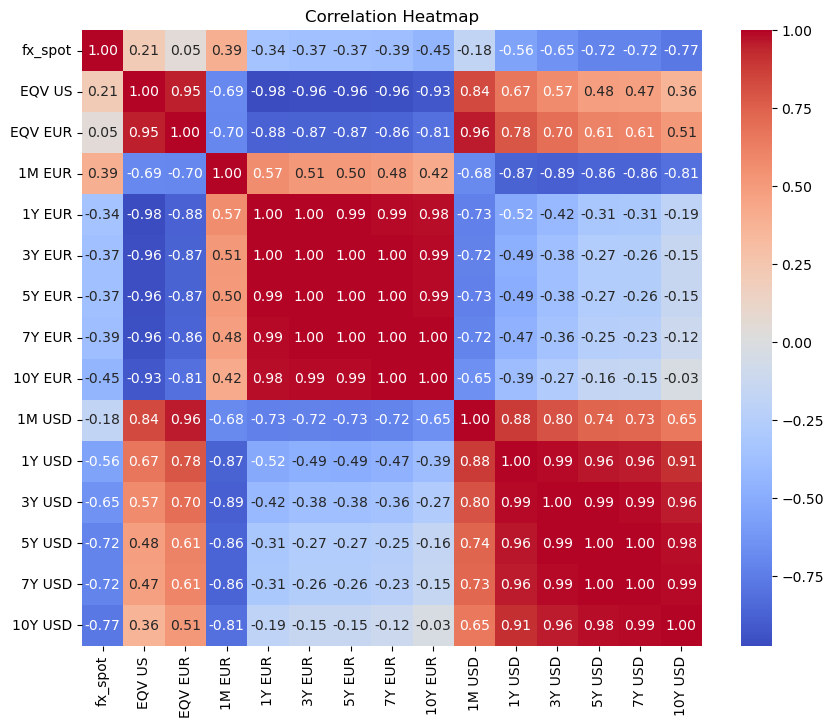

In [8]:
labels = [
    "fx_spot", "EQV US", "EQV EUR", "1M EUR", "1Y EUR", "3Y EUR",
    "5Y EUR", "7Y EUR", "10Y EUR", "1M USD", "1Y USD", "3Y USD",
    "5Y USD", "7Y USD", "10Y USD"
]


correlation_matrix = np.corrcoef(cov_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    xticklabels=labels, 
    yticklabels=labels
)
plt.title("Correlation Heatmap")
plt.show()


### Set parameters

In [9]:
delta_t = 1 / 52  # Weekly time frame
mu = np.zeros(len(cov_matrix))  
mu[1] = 0.07 * delta_t  # Update the second element
mu[2] = 0.06 * delta_t  # Update the third element

num_steps = 52  # Number of time steps (1 year)
num_simulations = 10000 # Number of simulations

### First here is the true analytical mu and covariance-matrix for t = 1, $\boldsymbol{P}_{1, \text{log}}, \boldsymbol{P}_1, \boldsymbol{P}_1^{\text{EUR}}$

In [10]:
#We need to make a function to calculate a covariance matrix for X, when log(X) is multivariate normal to we gate the same matrix for a multivariat lognormal
def compute_exp_mean_from_log(log_mean: np.ndarray, log_cov_matrix: np.ndarray) -> np.ndarray:
    """
    Computes the expected value of a random variable Y,
    given that log(X) follows a multivariate normal distribution.

    Parameters
    ----------
    log_mean:
        Mean vector of the log-transformed variable (log(X)).
    log_cov_matrix:
        Covariance matrix of the log-transformed variable (log(X)).

    Returns
    -------
    np.ndarray
        Expected value of the original variable (X).
    """

    # Calculate the expected value of Y using the log-normal distribution formula
    return np.exp(log_mean + 0.5 * np.diag(log_cov_matrix))




def compute_exp_cov_matrix(mean_vector: np.ndarray, log_cov_matrix: np.ndarray) -> np.ndarray:
    """
    Computes the covariance matrix of a random variable X,
    given that log(X) follows a multivariate normal distribution.

    Parameters
    ----------
    mean_vector:
        The mean vector of the log-transformed random variable (log(X)).
    log_cov_matrix:
        The covariance matrix of the log-transformed random variable (log(X)).

    Returns
    -------
    np.ndarray
        The covariance matrix of the original random variable (X).
    """

    # Compute the expected value of Y based on the log-normal distribution
    exp_mean_vector = compute_exp_mean_from_log(mean_vector, log_cov_matrix)

    # Use the formula to calculate the covariance matrix of Y
    return np.outer(exp_mean_vector, exp_mean_vector) * (np.exp(log_cov_matrix) - 1)


In [11]:
# weight matrix for defining the risk drivers distribution in domestic currency
weight_matrix = np.array([[-1.0, 0.0, 0.0, 0.0, 0.0],
                          [-1.0, 1.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 1.0, 0.0, 0.0],
                          [-1.0, 0.0, 0.0, 1.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 1.0]])

In [12]:
steps = 52 #(1 year)
t_hor = 1
indices_to_keep = [0, 1, 2, 12, 6]

cov_reduced = cov_matrix[np.ix_(indices_to_keep, indices_to_keep)]
mu_reduced = mu[np.ix_(indices_to_keep)]
x0_reduced = x0[np.ix_(indices_to_keep)]

B = np.diag([1.0, 1.0, 1.0, -(5.0 - t_hor), -(5.0 - t_hor)]) #To handle obligations

mu_hor = mu_reduced * steps + x0_reduced
cov_hor = cov_reduced * steps
print("Log-cov-matrix, t = 1:")
cov_hor_df = pd.DataFrame(cov_hor, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_df)
print("Log-mu, t = 1:")
mu_hor_df = pd.DataFrame(mu_hor, index=indices_to_keep, columns=["Log-mu"])
print(mu_hor_df)

#transforming to prices:
mu_hor = mu_hor  @ B.T
cov_hor = B @ cov_hor @ B.T
print("")
print("Log-cov-matrix with bond-prices, t = 1:")
cov_hor_df = pd.DataFrame(cov_hor, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_df)
print("Log-mu with bond prices, t = 1:")
mu_hor_df = pd.DataFrame(mu_hor, index=indices_to_keep, columns=["Log-mu"])
print(mu_hor_df)

#Taking exp and removing logs, so not is it log-normal, this the true P_1 cov and mu:
mu_hor_exp = compute_exp_mean_from_log(mu_hor, cov_hor)
cov_hor_exp = compute_exp_cov_matrix(mu_hor, cov_hor)
print("")
print("P_1-cov-matrix, t = 1:")
cov_hor_exp_df = pd.DataFrame(cov_hor_exp, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_exp_df)
print("P_1-mu, t = 1:")
mu_hor_exp_df = pd.DataFrame(mu_hor_exp, index=indices_to_keep, columns=["Mu_P_1"])
print(mu_hor_exp_df)

#Now in domestic currency (EUR), this is P_1_EUR
mu_hor_dom = mu_hor  @ weight_matrix.T
cov_hor_dom = weight_matrix @ cov_hor @ weight_matrix.T
mu_hor_exp_dom = compute_exp_mean_from_log(mu_hor_dom, cov_hor_dom)
cov_hor_exp_dom = compute_exp_cov_matrix(mu_hor_dom, cov_hor_dom)
print("")
print("P_1_EUR-cov-matrix, t = 1:")
cov_hor_exp_dom_df = pd.DataFrame(cov_hor_exp_dom, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_exp_dom_df)
print("P_1_EUR-mu, t = 1:")
mu_hor_exp_dom_df = pd.DataFrame(mu_hor_exp_dom, index=indices_to_keep, columns=["Mu_P_1_EUR"])
print(mu_hor_exp_dom_df)

#At final the analytical covariance-matric for PnL_1
#Multipliing (-1) in 1. row and colum (not the diagonal) because of: - 1/FX_2
cov_hor_exp_dom[0, 1:] *= -1  
cov_hor_exp_dom[1:, 0] *= -1 
print("")
print("PnL_1-cov-matrix, t = 1:")
cov_hor_exp_dom_df = pd.DataFrame(cov_hor_exp_dom, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_exp_dom_df)






Log-cov-matrix, t = 1:
          0         1         2         12        6 
0   0.005865  0.001998 -0.000245 -0.000164 -0.000020
1   0.001998  0.022256  0.017473  0.000087 -0.000164
2  -0.000245  0.017473  0.024203  0.000179 -0.000093
12 -0.000164  0.000087  0.000179  0.000061  0.000034
6  -0.000020 -0.000164 -0.000093  0.000034  0.000038
Log-mu, t = 1:
      Log-mu
0   0.055293
1   0.070000
2   0.060000
12  0.037409
6   0.020047

Log-cov-matrix with bond-prices, t = 1:
          0         1         2         12        6 
0   0.005865  0.001998 -0.000245  0.000656  0.000081
1   0.001998  0.022256  0.017473 -0.000347  0.000655
2  -0.000245  0.017473  0.024203 -0.000717  0.000371
12  0.000656 -0.000347 -0.000717  0.000973  0.000544
6   0.000081  0.000655  0.000371  0.000544  0.000603
Log-mu with bond prices, t = 1:
      Log-mu
0   0.055293
1   0.070000
2   0.060000
12 -0.149634
6  -0.080189

P_1-cov-matrix, t = 1:
          0         1         2         12        6 
0   0.006608  0.0022

# Part 1

### Simulate the evolution of $X_t$

#### Function to simulate paths

In [13]:
def simulate_paths(x0, mu, cov_matrix, num_steps, delta_t, num_simulations):
    # Initialize simulation array
    simulations = np.zeros((num_steps + 1, len(x0), num_simulations))
    simulations[0, :, :] = x0[:, None]  
    
    for t in range(1, num_steps + 1):
        # Generate random increments ΔX_t ~ N(μ, Σ)
        delta_x = np.random.multivariate_normal(mu, cov_matrix, num_simulations).T
        # Update the paths
        simulations[t, :, :] = simulations[t - 1, :, :] + delta_x

    return simulations

#### Simulate the evolution of $X_t$ with weekly time steps from time zero to the horizon and visualize the evolution of log $FX_t$

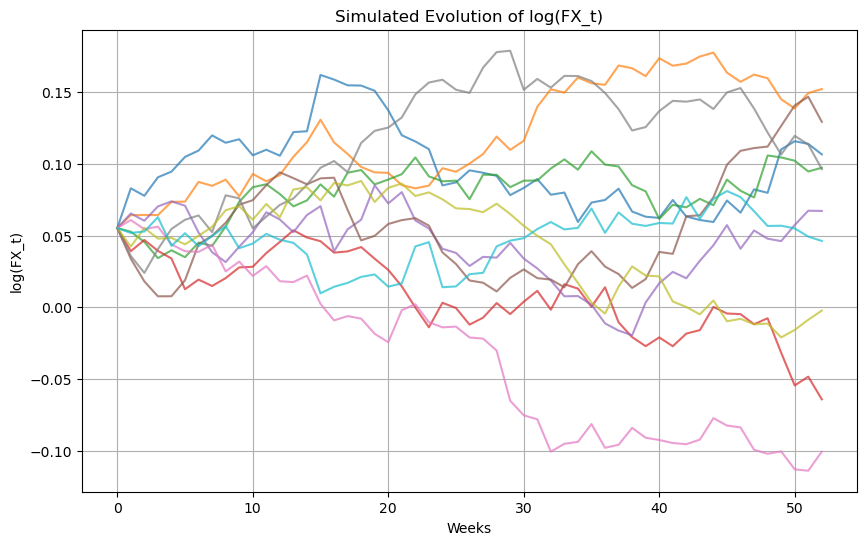

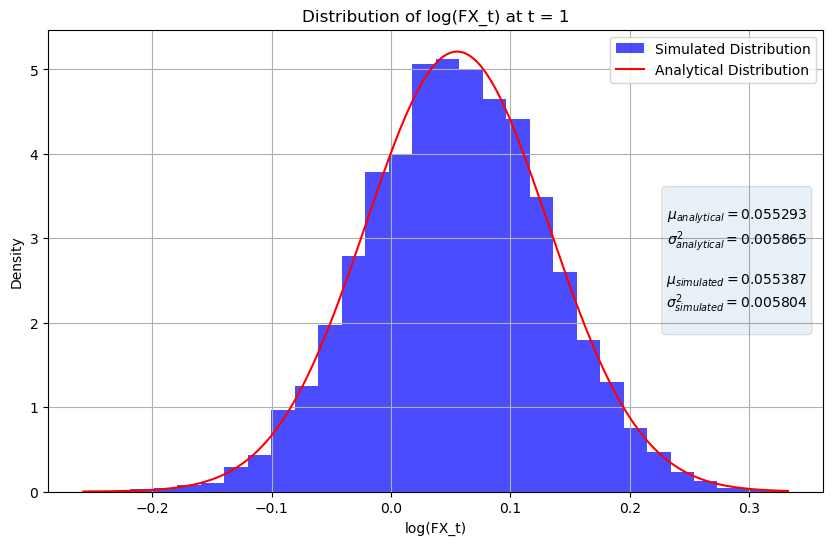

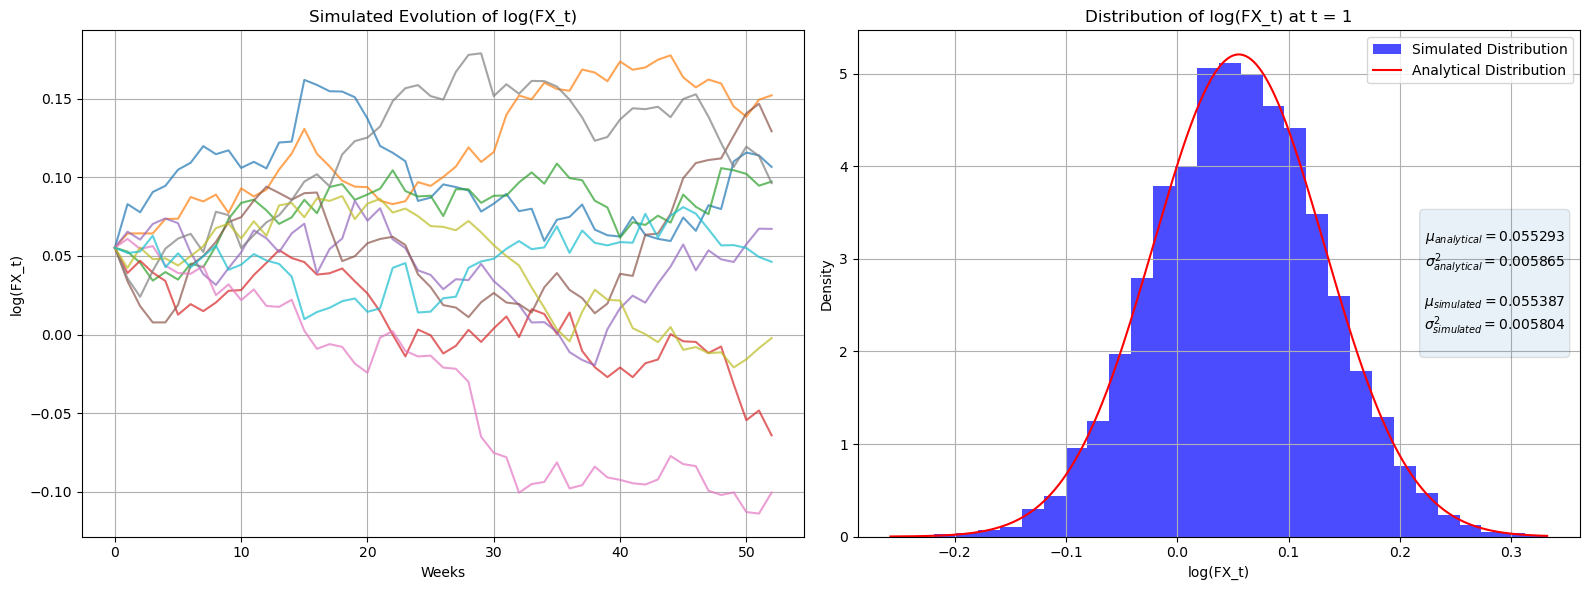

10000
Analytical mean of log(FX_t): 0.055293
Analytical variance of log(FX_t): 0.005865
Simulated mean of log(FX_t): 0.055387
Simulated variance of log(FX_t): 0.005804


In [14]:
np.random.seed(2000)  # Ensure reproducibility
# Run simulation
simulations = simulate_paths(x0, mu, cov_matrix, num_steps, delta_t, num_simulations)

# Extract log(FX_t) (first variable in X_t)
log_FX_t = simulations[:, 0, :]  # First variable represents log(FX_t)

# Plot log(FX_t) for a few simulated paths with weeks on the x-axis
weeks = np.arange(0, num_steps + 1) 
plt.figure(figsize=(10, 6))
for i in range(10): 
    plt.plot(weeks, log_FX_t[:, i], alpha=0.7)
plt.title("Simulated Evolution of log(FX_t)")
plt.xlabel("Weeks")
plt.ylabel("log(FX_t)")
plt.grid()
plt.savefig("simulated_log_FX_t.png")
plt.show()

final_log_FX_t = log_FX_t[-1, :]  # Values of log(FX_t) at t = 1
#Theoritical values for t = 1:
theoretical_mean = x0[0]  # Initial value plus expected drift (which is 0 here)
theoretical_variance = cov_matrix[0, 0] * num_steps  # Variance term for log(FX_t), it times num_steps because we are comparing with the final values
# Generate x values for theoretical PDF
x_values = np.linspace(min(final_log_FX_t), max(final_log_FX_t), 500)
theoretical_pdf = norm.pdf(x_values, loc=theoretical_mean, scale=np.sqrt(theoretical_variance))


empirical_mean = np.mean(final_log_FX_t)  # Mean of the simulated final values
empirical_variance = np.var(final_log_FX_t)   # Variance of the simulated final values, it is multiplied with 52 because it the variance we are coimparing with 


# Plot histogram of log(FX_1) (final log(FX_t) distribution) with theoretical PDF
plt.figure(figsize=(10, 6))
plt.hist(final_log_FX_t, bins=30, density=True, alpha=0.7, color='blue', label='Simulated Distribution')
plt.plot(x_values, theoretical_pdf, 'r-', label='Analytical Distribution')  # Theoretical PDF
plt.title("Distribution of log(FX_t) at t = 1")
plt.xlabel("log(FX_t)")
plt.ylabel("Density")
plt.legend()
# Add theoretical and simulated statistics as text with LaTeX symbols
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.savefig("distribution_with_theoretical.png")
plt.show()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# Left plot: Simulated paths
for i in range(10):
    axes[0].plot(weeks, log_FX_t[:, i], alpha=0.7)
axes[0].set_title("Simulated Evolution of log(FX_t)")
axes[0].set_xlabel("Weeks")
axes[0].set_ylabel("log(FX_t)")
axes[0].grid()

# Right plot: Histogram
axes[1].hist(final_log_FX_t, bins=30, density=True, alpha=0.7, color='blue', label='Simulated Distribution')
axes[1].plot(x_values, theoretical_pdf, 'r-', label='Analytical Distribution')  # Theoretical PDF
axes[1].set_title("Distribution of log(FX_t) at t = 1")
axes[1].set_xlabel("log(FX_t)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
axes[1].grid()

# Save the combined plot as an image
plt.tight_layout()
plt.savefig("combined_plots.png")
plt.show()

print(len(final_log_FX_t))
print(f"Analytical mean of log(FX_t): {theoretical_mean:.6f}")
print(f"Analytical variance of log(FX_t): {theoretical_variance:.6f}")

# Compare with simulated results
print(f"Simulated mean of log(FX_t): {empirical_mean:.6f}")
print(f"Simulated variance of log(FX_t): {empirical_variance:.6f}")


In [15]:
# Calculate the mean (mu) for each variable at the last time step
mu_simulated = np.mean(simulations[-1, :, :], axis=1).round(5)

# Calculate the covariance matrix (cov_matrix) at the last time step
cov_simulated = np.cov(simulations[-1, :, :]).round(5)

print(f"Simulated Mean (mu): {mu_simulated}")
print(f"Simulated Covariance Matrix:\n{cov_simulated}")

# Extract variances (diagonal elements of the covariance matrix)
variances = np.diag(cov_simulated)
std_devs = np.sqrt(variances)

print("\nEstimated Variances for P1:")
for i, var in enumerate(variances):
    print(f"Component {i+1}: Variance = {var:.6f}")


Simulated Mean (mu): [0.05539 0.07102 0.05942 0.0312  0.02246 0.01966 0.01997 0.02048 0.0213
 0.04587 0.0417  0.03817 0.03732 0.03714 0.03725]
Simulated Covariance Matrix:
[[ 5.800e-03  1.850e-03 -2.400e-04  1.000e-05 -1.000e-05 -2.000e-05
  -2.000e-05 -2.000e-05 -3.000e-05 -1.000e-05 -9.000e-05 -1.600e-04
  -1.600e-04 -1.500e-04 -1.400e-04]
 [ 1.850e-03  2.223e-02  1.752e-02 -0.000e+00 -1.100e-04 -1.600e-04
  -1.600e-04 -1.600e-04 -1.500e-04  6.000e-05  1.000e-04  1.300e-04
   1.000e-04  1.000e-04  8.000e-05]
 [-2.400e-04  1.752e-02  2.428e-02 -0.000e+00 -6.000e-05 -1.000e-04
  -1.000e-04 -1.000e-04 -7.000e-05  1.100e-04  1.600e-04  2.000e-04
   1.800e-04  1.700e-04  1.500e-04]
 [ 1.000e-05 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00]
 [-1.000e-05 -1.100e-04 -6.000e-05  0.000e+00  2.000e-05  2.000e-05
   2.000e-05  2.000e-05  2.000e-05  0.000e+00  2.000e-05  2.000e-05
   2

#### Analysis of the distribution and simulation of $V_1^{\text{US,local}}$

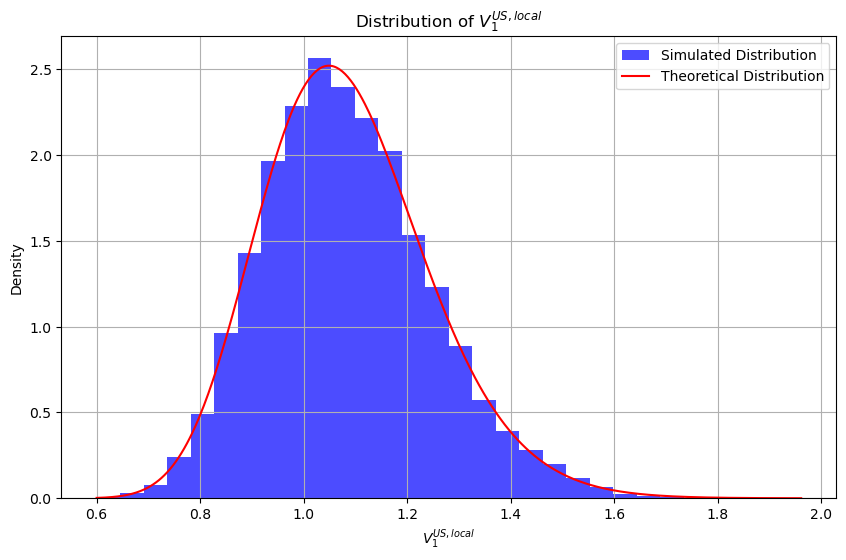

Theoretical mean: 1.084510
Empirical mean: 1.084710
Theoretical variance: 0.026471
Empirical variance: 0.026406


In [16]:
# Extract relevant parameters for log(V_US,local)
initial_log_V_US_local = x0[1]  # Second component in x0
mu_log_V_US_local = mu[1] * num_steps  # Drift over the horizon
sigma2_log_V_US_local = cov_matrix[1, 1] * num_steps  # Variance over the horizon

# Simulate log(V_US,local)
np.random.seed(2000)  # Ensure reproducibility
log_V_US_local_simulations = np.random.normal(
    loc=initial_log_V_US_local + mu_log_V_US_local,
    scale=np.sqrt(sigma2_log_V_US_local),
    size=num_simulations
)

# Transform to V_US,local
V_US_local_simulations = np.exp(log_V_US_local_simulations)

# Analytical parameters for log-normal distribution
theoretical_mean = np.exp(initial_log_V_US_local + mu_log_V_US_local + sigma2_log_V_US_local / 2)
theoretical_variance = (np.exp(sigma2_log_V_US_local) - 1) * np.exp(2 * (initial_log_V_US_local + mu_log_V_US_local) + sigma2_log_V_US_local)

# Generate x values for theoretical PDF
v_values = np.linspace(min(V_US_local_simulations), max(V_US_local_simulations), 500)
theoretical_pdf = lognorm.pdf(v_values, s=np.sqrt(sigma2_log_V_US_local), scale=np.exp(initial_log_V_US_local + mu_log_V_US_local))

# Plot histogram of V_US,local with theoretical PDF
plt.figure(figsize=(10, 6))
plt.hist(V_US_local_simulations, bins=30, density=True, alpha=0.7, color='blue', label='Simulated Distribution')
plt.plot(v_values, theoretical_pdf, 'r-', label='Theoretical Distribution')
plt.title("Distribution of $V_1^{US,local}$")
plt.xlabel("$V_1^{US,local}$")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.savefig("distribution_V_US_local.png")
plt.show()

# Calculate empirical mean and variance
empirical_mean = np.mean(V_US_local_simulations)
empirical_variance = np.var(V_US_local_simulations)

print(f"Theoretical mean: {theoretical_mean:.6f}")
print(f"Empirical mean: {empirical_mean:.6f}")
print(f"Theoretical variance: {theoretical_variance:.6f}")
print(f"Empirical variance: {empirical_variance:.6f}")


Theoretical mean of log(V^US,local): 0.070000
Theoretical variance of log(V^US,local): 0.022256
Simulated mean of log(V^US,local): 0.071018
Simulated variance of log(V^US,local): 0.022230


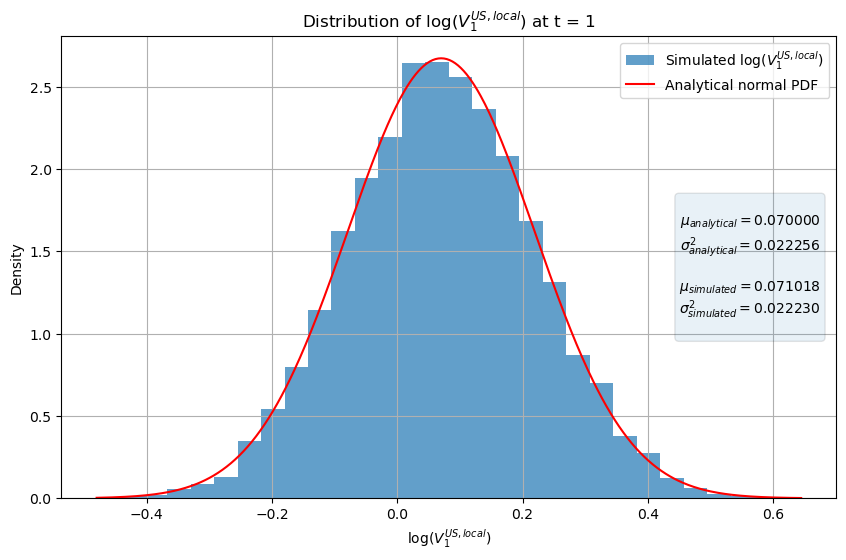

Analytical mean of V^US,local: 1.084510
Analytical variance of V^US,local: 0.026471
Simulated mean of V^US,local: 1.085611
Simulated variance of V^US,local: 0.026551


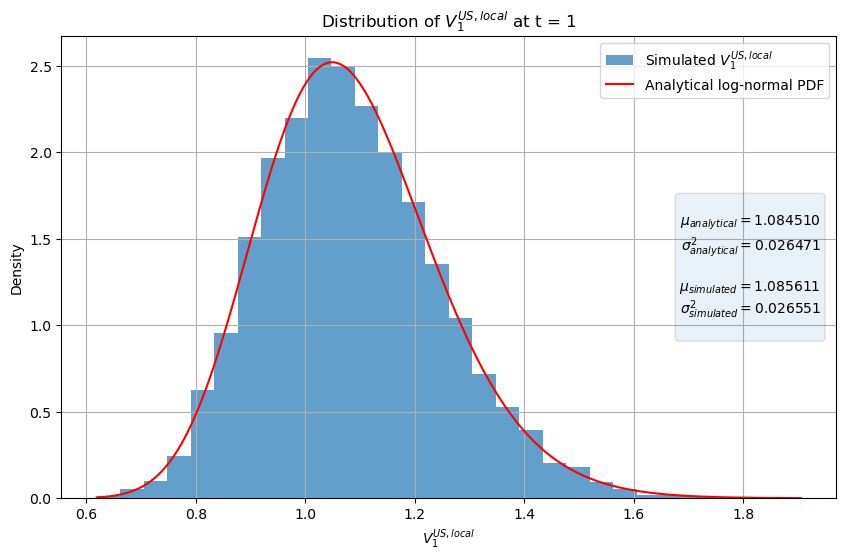

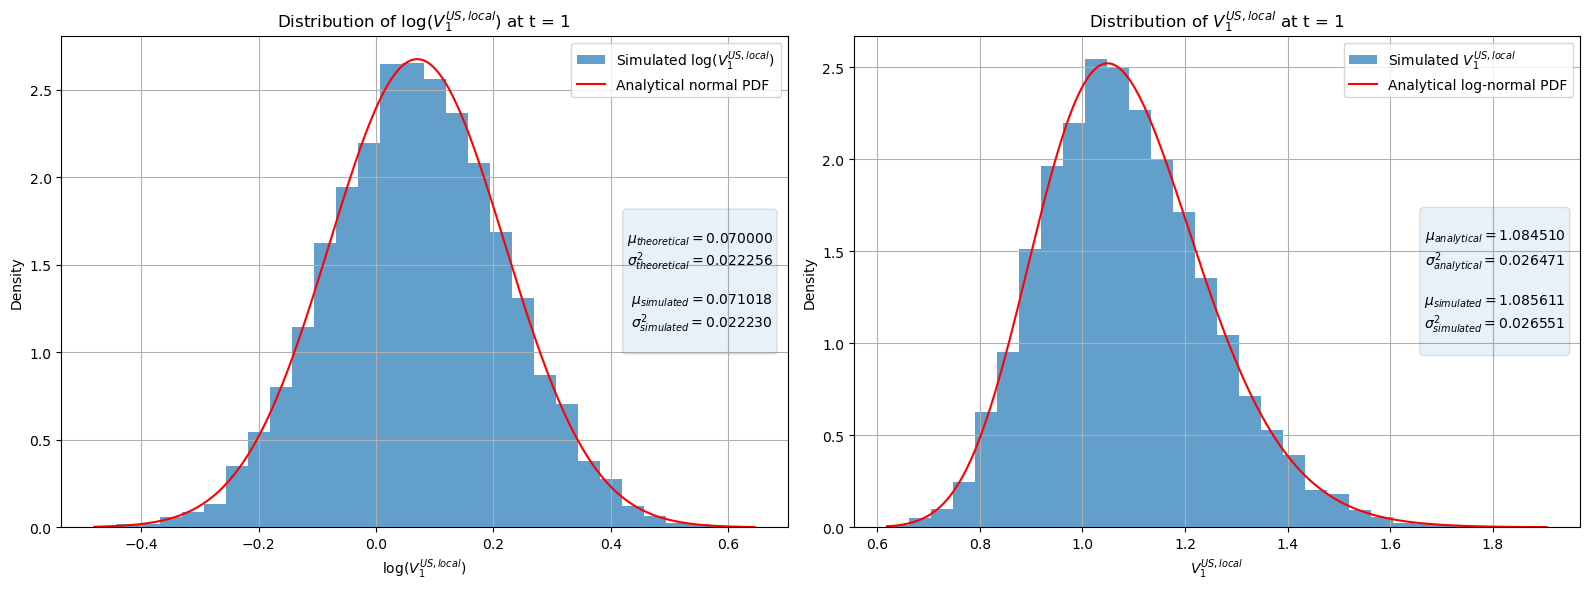

In [17]:
# Extract log(V_1^US,local)
log_V_US_local = simulations[:, 1, :]  # Second component is log(V^US,local)

# Final distribution at t = 1
final_log_V_US_local = log_V_US_local[-1, :]

# Theoretical mean and variance for log(V^US,local)
theoretical_mean_log = x0[1] + mu[1] * num_steps
theoretical_variance_log = cov_matrix[1, 1] * num_steps

# Simulated mean and variance
empirical_mean_log = np.mean(final_log_V_US_local)
empirical_variance_log = np.var(final_log_V_US_local)

print(f"Theoretical mean of log(V^US,local): {theoretical_mean_log:.6f}")
print(f"Theoretical variance of log(V^US,local): {theoretical_variance_log:.6f}")
print(f"Simulated mean of log(V^US,local): {empirical_mean_log:.6f}")
print(f"Simulated variance of log(V^US,local): {empirical_variance_log:.6f}")

# Plot histogram of log(V_1^US,local) and theoretical distribution
x_values_log = np.linspace(min(final_log_V_US_local), max(final_log_V_US_local), 500)
theoretical_pdf_log = norm.pdf(x_values_log, loc=theoretical_mean_log, scale=np.sqrt(theoretical_variance_log))

plt.figure(figsize=(10, 6))
plt.hist(final_log_V_US_local, bins=30, density=True, alpha=0.7, label='Simulated log($V_1^{US,local}$)')
plt.plot(x_values_log, theoretical_pdf_log, 'r-', label='Analytical normal PDF')
plt.title("Distribution of log($V_1^{US,local}$) at t = 1")
plt.xlabel("log($V_1^{US,local}$)")
plt.ylabel("Density")
plt.legend()

textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean_log:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance_log:.6f}$

$\\mu_{{simulated}} = {empirical_mean_log:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_log:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.show()

# Convert to V_1^US,local (exponentiate)
final_V_US_local = np.exp(final_log_V_US_local)

# Theoretical mean and variance for V^US,local
theoretical_mean = np.exp(theoretical_mean_log + theoretical_variance_log / 2)
theoretical_variance = (
    (np.exp(theoretical_variance_log) - 1)
    * np.exp(2 * theoretical_mean_log + theoretical_variance_log)
)

# Simulated mean and variance
empirical_mean = np.mean(final_V_US_local)
empirical_variance = np.var(final_V_US_local)

print(f"Analytical mean of V^US,local: {theoretical_mean:.6f}")
print(f"Analytical variance of V^US,local: {theoretical_variance:.6f}")
print(f"Simulated mean of V^US,local: {empirical_mean:.6f}")
print(f"Simulated variance of V^US,local: {empirical_variance:.6f}")


x_values = np.linspace(min(final_V_US_local), max(final_V_US_local), 500)
theoretical_pdf = lognorm.pdf(x_values, s=np.sqrt(theoretical_variance_log),
                              scale=np.exp(theoretical_mean_log))

plt.figure(figsize=(10, 6))
plt.hist(final_V_US_local, bins=30, density=True, alpha=0.7, label='Simulated $V_1^{US,local}$')
plt.plot(x_values, theoretical_pdf, 'r-', label='Analytical log-normal PDF')
plt.title("Distribution of $V_1^{US,local}$ at t = 1")
plt.xlabel("$V_1^{US,local}$")
plt.ylabel("Density")
plt.legend()
# Add theoretical and simulated statistics as text with LaTeX symbols
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot histogram of log(V_1^US,local) and theoretical distribution on the left
axes[0].hist(final_log_V_US_local, bins=30, density=True, alpha=0.7, label='Simulated log($V_1^{US,local}$)')
axes[0].plot(x_values_log, theoretical_pdf_log, 'r-', label='Analytical normal PDF')
axes[0].set_title("Distribution of log($V_1^{US,local}$) at t = 1")
axes[0].set_xlabel("log($V_1^{US,local}$)")
axes[0].set_ylabel("Density")
axes[0].legend()
textstr_log = f"""
$\\mu_{{theoretical}} = {theoretical_mean_log:.6f}$
$\\sigma^2_{{theoretical}} = {theoretical_variance_log:.6f}$

$\\mu_{{simulated}} = {empirical_mean_log:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_log:.6f}$
"""
axes[0].text(0.98, 0.5, textstr_log, transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='center', horizontalalignment='right',
             bbox=dict(boxstyle="round", alpha=0.1))
axes[0].grid()

# Plot histogram of V_1^US,local and theoretical distribution on the right
axes[1].hist(final_V_US_local, bins=30, density=True, alpha=0.7, label='Simulated $V_1^{US,local}$')
axes[1].plot(x_values, theoretical_pdf, 'r-', label='Analytical log-normal PDF')
axes[1].set_title("Distribution of $V_1^{US,local}$ at t = 1")
axes[1].set_xlabel("$V_1^{US,local}$")
axes[1].set_ylabel("Density")
axes[1].legend()
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""
axes[1].text(0.98, 0.5, textstr, transform=axes[1].transAxes, fontsize=10, 
             verticalalignment='center', horizontalalignment='right',
             bbox=dict(boxstyle="round", alpha=0.1))
axes[1].grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig("combined_plots_V1_US.png")
plt.show()


#### Calculation of the Value of a EUR or USD Zero-Coupon Bond (5Y EUR chosen) - linear, splines, boostrap and Nelson-Siegel

In [18]:
init_values = pd.read_excel(init_values_path)  # Remove index_col=0

In [19]:

def convert_to_years(label):
    if "M" in label:
        return int(label.split("M")[0]) / 12  # Convert months to years
    elif "Y" in label:
        return int(label.split("Y")[0])       # Convert years directly
    else:
        return None

def prepare_data(init_values):
    eur_data = init_values[init_values['Unnamed: 0'].str.contains('EUR') & ~init_values['Unnamed: 0'].str.contains('EQV')].copy()
    usd_data = init_values[init_values['Unnamed: 0'].str.contains('USD') & ~init_values['Unnamed: 0'].str.contains('EQV')].copy()
    eur_data["years"] = eur_data["Unnamed: 0"].apply(convert_to_years)
    usd_data["years"] = usd_data["Unnamed: 0"].apply(convert_to_years)
    return eur_data, usd_data

# Bootstrapping function
def bootstrap_spot_rates(maturities, rates):
    discount_factors = [np.exp(-r * t) for t, r in zip(maturities, rates)]
    spot_rates = [-np.log(df) / t for df, t in zip(discount_factors, maturities)]
    return spot_rates

# Nelson-Siegel yield curve function
def nelson_siegel(tau, beta0, beta1, beta2, lambda_):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda_ * tau)) / (lambda_ * tau)
    term3 = beta2 * ((1 - np.exp(-lambda_ * tau)) / (lambda_ * tau) - np.exp(-lambda_ * tau))
    return term1 + term2 + term3

# Objective function to minimize
def objective(params, tau, yields):
    beta0, beta1, beta2, lambda_ = params
    fitted_yields = nelson_siegel(tau, beta0, beta1, beta2, lambda_)
    return np.sum((fitted_yields - yields) ** 2)

# Function to fit Nelson-Siegel model
def fit_nelson_siegel(maturities, yields):
    initial_params = [0.02, -0.01, 0.01, 0.5]  # Initial guess
    result = minimize(objective, initial_params, args=(maturities, yields), bounds=[(0, None), (None, None), (None, None), (0, None)])
    return result.x

def process_yield_data_with_interpolation(init_values, save_path):
    # Prepare data
    eur_data, usd_data = prepare_data(init_values)

    # Extract known maturities and rates
    eur_maturities, eur_rates = eur_data["years"].values, eur_data["initial values"].values
    usd_maturities, usd_rates = usd_data["years"].values, usd_data["initial values"].values

    # New maturities for linear interpolation
    new_maturities = np.array([2, 4, 6, 8])

    # Linear Interpolation
    eur_interpolated_rates = np.interp(new_maturities, eur_maturities, eur_rates)
    usd_interpolated_rates = np.interp(new_maturities, usd_maturities, usd_rates)

    # Cubic Splines
    eur_spline = CubicSpline(eur_maturities, eur_rates, bc_type='natural')
    usd_spline = CubicSpline(usd_maturities, usd_rates, bc_type='natural')
    smooth_maturities = np.linspace(0.1, 10, 100)
    eur_interpolated_spline = eur_spline(smooth_maturities)
    usd_interpolated_spline = usd_spline(smooth_maturities)

    # Bootstrapped Spot Rates
    eur_bootstrapped_spot_rates = bootstrap_spot_rates(eur_maturities, eur_rates)
    usd_bootstrapped_spot_rates = bootstrap_spot_rates(usd_maturities, usd_rates)

    # Nelson-Siegel
    beta_eur = fit_nelson_siegel(eur_maturities, eur_rates)
    beta_usd = fit_nelson_siegel(usd_maturities, usd_rates)
    ns_yields_eur = nelson_siegel(smooth_maturities, *beta_eur)
    ns_yields_usd = nelson_siegel(smooth_maturities, *beta_usd)

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Plot Linear Interpolation
    axes[0].plot(eur_maturities, eur_rates, 'o-', label="EUR Known Rates", color='blue')
    axes[0].plot(new_maturities, eur_interpolated_rates, 'x--', label="EUR Linear Interpolation", color='cyan')
    axes[0].plot(usd_maturities, usd_rates, 's-', label="USD Known Rates", color='green')
    axes[0].plot(new_maturities, usd_interpolated_rates, 'x--', label="USD Linear Interpolation", color='lime')
    axes[0].set_title("Linear Interpolation (EUR & USD)")
    axes[0].set_xlabel("Maturity (Years)")
    axes[0].set_ylabel("Yield")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Cubic Splines
    axes[1].plot(eur_maturities, eur_rates, 'o', label="EUR Known Rates", color='blue')
    axes[1].plot(usd_maturities, usd_rates, 's', label="USD Known Rates", color='green')
    axes[1].plot(smooth_maturities, eur_interpolated_spline, label="EUR Cubic Spline", color='blue')
    axes[1].plot(smooth_maturities, usd_interpolated_spline, label="USD Cubic Spline", color='green')
    axes[1].set_title("Cubic Splines (EUR & USD)")
    axes[1].set_xlabel("Maturity (Years)")
    axes[1].set_ylabel("Yield")
    axes[1].legend()
    axes[1].grid(True)

    # Plot Bootstrapped Spot Rates
    axes[2].plot(eur_maturities, eur_bootstrapped_spot_rates, 'o-', label="EUR Bootstrapped Spot Rates", color='cyan')
    axes[2].plot(usd_maturities, usd_bootstrapped_spot_rates, 's-', label="USD Bootstrapped Spot Rates", color='lime')
    axes[2].set_title("Bootstrapped Spot Rates (EUR & USD)")
    axes[2].set_xlabel("Maturity (Years)")
    axes[2].set_ylabel("Spot Rate")
    axes[2].legend()
    axes[2].grid(True)

    # Plot Nelson-Siegel Fitted Curves
    axes[3].plot(eur_maturities, eur_rates, 'o', label="Observed EUR Rates", color='blue')
    axes[3].plot(smooth_maturities, ns_yields_eur, label="Nelson-Siegel EUR", color='blue')
    axes[3].plot(usd_maturities, usd_rates, 'o', label="Observed USD Rates", color='red')
    axes[3].plot(smooth_maturities, ns_yields_usd, label="Nelson-Siegel USD", color='red')
    axes[3].set_title("Nelson-Siegel Yield Curves")
    axes[3].set_xlabel("Maturity (Years)")
    axes[3].set_ylabel("Yield")
    axes[3].legend()
    axes[3].grid(True)

    # Save plot
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    # Print results
    print("Nelson-Siegel Parameters (EUR):", beta_eur)
    print("Nelson-Siegel Parameters (USD):", beta_usd)




#### Distribution of an Initial 5-Year Zero-Coupon Bond at the Horizon

0.0008511682809833435
0.0
0.02004730805076598
7.2448744255214e-07


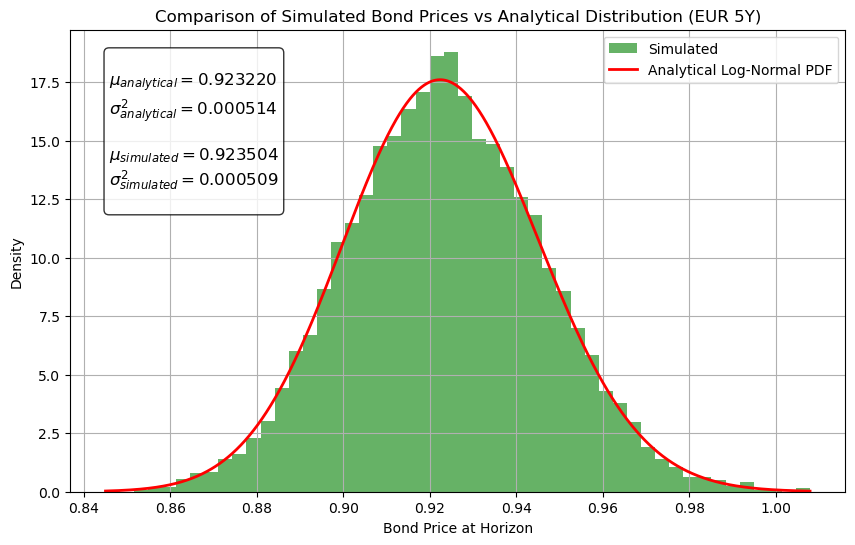

In [20]:
y5_0 = x0[6]  # Initial 5-year EUR yield
mu5 = mu[6]  # Mean change in the 5-year yield, just equal to 0
sigma5 = np.sqrt(cov_matrix[6,6])  
T = 4  # Time to maturity at the horizon
F = 1
print(sigma5)
print(mu5)
print(y5_0)
print(cov_matrix[6,6])

#Just using our simulations which we made in the beginning: 
y5_1 = simulations[:, 6, :]  ## Initial 5-year EUR yield (the 7. component in simulations)
B1_simulated = F * np.exp(-T * y5_1[-1])

# Analytical distribution parameters
mu_B1 = -T * (y5_0 + mu5*52)
sigma_B1 = T * sigma5 * np.sqrt(52)

# Generate theoretical curve for bond prices
x = np.linspace(min(B1_simulated), max(B1_simulated), 1000)
theoretical_pdf = lognorm.pdf(x, s=sigma_B1, scale=np.exp(mu_B1))


# Calculate theoretical mean and variance
theoretical_mean = np.exp(mu_B1 + (sigma_B1**2) / 2)
theoretical_variance = (np.exp(sigma_B1**2) - 1) * np.exp(2 * mu_B1 + sigma_B1**2)

# Calculate empirical mean and variance from simulated data
empirical_mean = np.mean(B1_simulated)
empirical_variance = np.var(B1_simulated)

# Text for annotations
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""

# Plot histogram with theoretical curve and text
plt.figure(figsize=(10, 6))
plt.hist(B1_simulated, bins=50, alpha=0.6, label='Simulated', density=True, color='green')
plt.plot(x, theoretical_pdf, color='red', linewidth=2, label='Analytical Log-Normal PDF')

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.title('Comparison of Simulated Bond Prices vs Analytical Distribution (EUR 5Y)')
plt.xlabel('Bond Price at Horizon')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.savefig("Simulated_bond_prices.png")
plt.show()


# P1 components

Estimated Mean Vector (mu_P1):
[1.06002153 1.08561101 1.07419135 0.86173156 0.92350416]

Estimated Covariance Matrix (Sigma_P1):
[[ 6.53976501e-03  2.12490837e-03 -3.03746481e-04  5.89131748e-04
   6.52636451e-05]
 [ 2.12490837e-03  2.65539566e-02  2.06385670e-02 -3.86347030e-04
   6.58354748e-04]
 [-3.03746481e-04  2.06385670e-02  2.84326248e-02 -6.70780584e-04
   4.02083034e-04]
 [ 5.89131748e-04 -3.86347030e-04 -6.70780584e-04  7.23715947e-04
   4.25510772e-04]
 [ 6.52636451e-05  6.58354748e-04  4.02083034e-04  4.25510772e-04
   5.08970551e-04]]


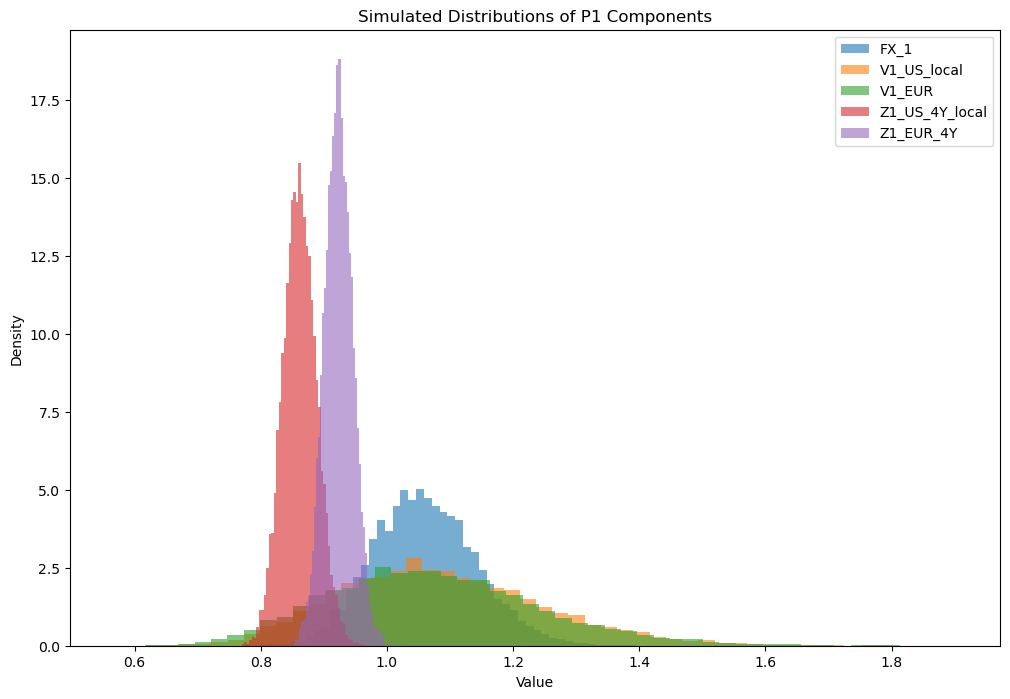

In [21]:
# Now calculating P1
# Initialize storage for P1 components
P1_components = np.zeros((num_simulations, 5))

for sim in range(num_simulations):
    log_FX_1 = simulations[:, 0, sim]  # First component
    log_V1_US_local = simulations[:, 1, sim]  # Second component
    log_V1_EUR = simulations[:, 2, sim]  # Third component
    y4_1_US = simulations[:, 12, sim]  # Assuming 4-year USD yield at horizon
    y4_1_EUR = simulations[:,6, sim]  # Assuming 4-year EUR yield at horizon
    
    # Calculate P1 components
    FX_1 = np.exp(log_FX_1[-1])
    V1_US_local = np.exp(log_V1_US_local[-1])
    V1_EUR = np.exp(log_V1_EUR[-1])
    Z1_US_4Y_local = np.exp(-4 * y4_1_US[-1])
    Z1_EUR_4Y = np.exp(-4 * y4_1_EUR[-1])
    
    P1_components[sim, :] = [FX_1, V1_US_local, V1_EUR, Z1_US_4Y_local, Z1_EUR_4Y]

# Estimate mean vector and covariance matrix
mu_P1 = np.mean(P1_components, axis=0)
Sigma_P1 = np.cov(P1_components, rowvar=False)

print("Estimated Mean Vector (mu_P1):")
print(mu_P1)
print("\nEstimated Covariance Matrix (Sigma_P1):")
print(Sigma_P1)

#Visualization of distributions
plt.figure(figsize=(12, 8))
for i, label in enumerate(["FX_1", "V1_US_local", "V1_EUR", "Z1_US_4Y_local", "Z1_EUR_4Y"]):
    plt.hist(P1_components[:, i], bins=50, alpha=0.6, label=label, density=True)
plt.title("Simulated Distributions of P1 Components")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [22]:
P1_components.shape

(10000, 5)

# P1_EUR compents

In [23]:
# Compute P_EUR_1 components
P_EUR_1 = np.zeros_like(P1_components)

# Transformations
P_EUR_1[:, 0] = 1 / P1_components[:, 0]  # 1 / FX_1
P_EUR_1[:, 1] = P1_components[:, 1] * P_EUR_1[:, 0]  # V1_US_local / FX_1
P_EUR_1[:, 2] = P1_components[:, 2]  # V1_EUR
P_EUR_1[:, 3] = P1_components[:, 3] * P_EUR_1[:, 0] # Z1_US_4Y_local / FX_1
P_EUR_1[:, 4] = P1_components[:, 4]  # Z1_EUR_4Y

## P_1 and P_1_EUR Every analytical distribution

In [24]:
#Functions to calculate Mean and variance of lognormal-distributions: 

def lognormal_mean(mu_x, var_x):
    """
    Calculate the mean of a log-normal distribution.

    Parameters:
    mu_x (float): Mean of the underlying normal distribution.
    var_x (float): Variance of the underlying normal distribution.

    Returns:
    float: Mean of the log-normal distribution.
    """
    return np.exp(mu_x + (var_x) / 2)

def lognormal_variance(mu_x, var_x):
    """
    Calculate the variance of a log-normal distribution.

    Parameters:
    mu_x (float): Mean of the underlying normal distribution.
     var_x (float): Variance of the underlying normal distribution.

    Returns:
    float: Variance of the log-normal distribution.
    """
    return (np.exp(var_x) - 1) * np.exp(2 * mu_x + var_x)

#Firstly the components in P1:
#FX_1
mu_logFX_1 = x0[0] + mu[0]*52
var_logFX_1 = cov_matrix[0,0]*52
Analytical_mean_FX_1 = lognormal_mean(mu_logFX_1, var_logFX_1)
Analytical_var_FX_1 = lognormal_variance(mu_logFX_1,var_logFX_1)

#V1_US_Local
mu_log_V1_US_Local = x0[1] + mu[1]*52
var_log_V1_US_Local = cov_matrix[1,1]*52
Analytical_mean_V1_US_Local = lognormal_mean(mu_log_V1_US_Local, var_log_V1_US_Local)
Analytical_var_V1_US_Local = lognormal_variance(mu_log_V1_US_Local,var_log_V1_US_Local)

#V1_EUR
mu_log_V1_EUR = x0[2] + mu[2]*52
var_log_V1_EUR = cov_matrix[2,2]*52
Analytical_mean_V1_EUR = lognormal_mean(mu_log_V1_EUR, var_log_V1_EUR)
Analytical_var_V1_EUR = lognormal_variance(mu_log_V1_EUR,var_log_V1_EUR)

T = 4

#Z1_USD_local
mu_y_4_1 = x0[12] + mu[12]*52
var_y_4_1 = cov_matrix[12,12]*52
mu_logZUSD_local = - T * mu_y_4_1
var_logZUSD_local = T**2*var_y_4_1
Analytical_mean_Z1_USD_local = lognormal_mean(mu_logZUSD_local, var_logZUSD_local)
Analytical_var_Z1_USD_local = lognormal_variance(mu_logZUSD_local,var_logZUSD_local)

#Z1_EUR
mu_y_4_1 = x0[6] + mu[6]*52
var_y_4_1 = cov_matrix[6,6]*52
Analytical_mean_Z1_EUR = lognormal_mean(-T*mu_y_4_1, T**2*var_y_4_1)
Analytical_var_Z1_EUR = lognormal_variance(-T*mu_y_4_1,T**2*var_y_4_1)


#Sencondly the components in P1:
#1/FX_1 ~ LogN(-mu, sigma^2)
Analytical_mean_1_FX_1 = lognormal_mean(-mu_logFX_1, var_logFX_1)
Analytical_var_1_FX_1 = lognormal_variance(-mu_logFX_1,var_logFX_1)


#V1_US
#We need the covariance: 
cov_v1_FX = cov_matrix[0,1]*52
#We need Rho (correlation)
rho = cov_v1_FX/(np.sqrt(var_log_V1_US_Local)*np.sqrt(var_logFX_1))
mu_V1_US = mu_log_V1_US_Local - mu_logFX_1

var_V1_US = var_log_V1_US_Local + var_logFX_1 - 2 * rho * np.sqrt(var_log_V1_US_Local) * np.sqrt(var_logFX_1)

Analytical_mu_V1_US = lognormal_mean(mu_V1_US, var_V1_US)
Analytical_var_V1_US = lognormal_variance(mu_V1_US,var_V1_US)

#V1_EUR is stils the same
Analytical_mean_V1_EUR
Analytical_var_V1_EUR

##Z1_USD = Z1_USD_local / FX_1
mu_logZUSD_local #Z1_USD_local mean (already calculated)
var_logZUSD_local #Z1_USD_local variance (already calculated)
mu_logFX_1 #FX_1 mean (already calculated)
var_logFX_1 #FX_1 variance (already calculated)

#Covariance is needed
cov_z1_FX = cov_matrix[12,0]*52
cov_z1_FX_new = -T*cov_z1_FX #We remember the T-factor in the covariance!
mu_Z1_new = mu_logZUSD_local - mu_logFX_1
var_Z1_new = var_logZUSD_local + var_logFX_1 - 2*cov_z1_FX_new

Analytical_mean_z1_USD = lognormal_mean(mu_Z1_new, var_Z1_new)
Analytical_var_z1_USD = lognormal_variance(mu_Z1_new,var_Z1_new)

#Z1_EUR is still the same
Analytical_mean_Z1_EUR
Analytical_var_Z1_EUR 

print("The components in P1:")
print(f"Mean of FX_1: {Analytical_mean_FX_1}")
print(f"Variance of FX_1: {Analytical_var_FX_1}")
print(f"Mean of V1_US_Local: {Analytical_mean_V1_US_Local}")
print(f"Variance of V1_US_Local: {Analytical_var_V1_US_Local}")
print(f"Mean of V1_EUR: {Analytical_mean_V1_EUR}")
print(f"Variance of V1_EUR: {Analytical_var_V1_EUR}")
print(f"Mean of Z1_USD_local: {Analytical_mean_Z1_USD_local}")
print(f"Variance of Z1_USD_local: {Analytical_var_Z1_USD_local}")
print(f"Mean of Z1_EUR: {Analytical_mean_Z1_EUR}")
print(f"Variance of Z1_EUR: {Analytical_var_Z1_EUR}")
print("")
print("The components in P1_EUR:")
print(f"Mean of 1/FX_1: {Analytical_mean_1_FX_1}")
print(f"Variance of 1/FX_1: {Analytical_var_1_FX_1}")
print("")
print("With depenpendence assumptions:")
print(f"Mean of V_1_US: {Analytical_mu_V1_US}")
print(f"Variance of V_1_US: {Analytical_var_V1_US}")
print("")
print(f"Mean of Z1_USD: {Analytical_mean_z1_USD}")
print(f"Variance of Z1_USD: {Analytical_var_z1_USD}")

The components in P1:
Mean of FX_1: 1.0599535146393084
Variance of FX_1: 0.006608171129626715
Mean of V1_US_Local: 1.084509954996659
Variance of V1_US_Local: 0.02647067952347849
Mean of V1_EUR: 1.074764595705856
Variance of V1_EUR: 0.028298786766039644
Mean of Z1_USD_local: 0.8614417208698942
Variance of Z1_USD_local: 0.0007223599509062543
Mean of Z1_EUR: 0.9232198839123239
Variance of Z1_EUR: 0.0005139198410039965

The components in P1_EUR:
Mean of 1/FX_1: 0.9489866779587082
Variance of 1/FX_1: 0.005296974403192497

With depenpendence assumptions:
Mean of V_1_US: 1.02713138521889
Variance of V_1_US: 0.025761646547379086

Mean of Z1_USD: 0.8169609715437517
Variance of Z1_USD: 0.003698641117543395


### Plotting $V_1^{\text{USD Local}}$ and $V_1^{\text{USD}}$

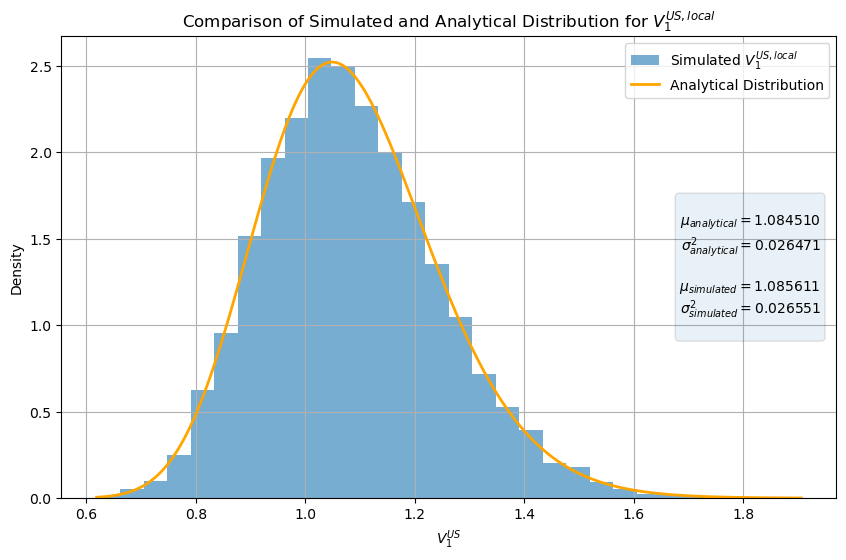

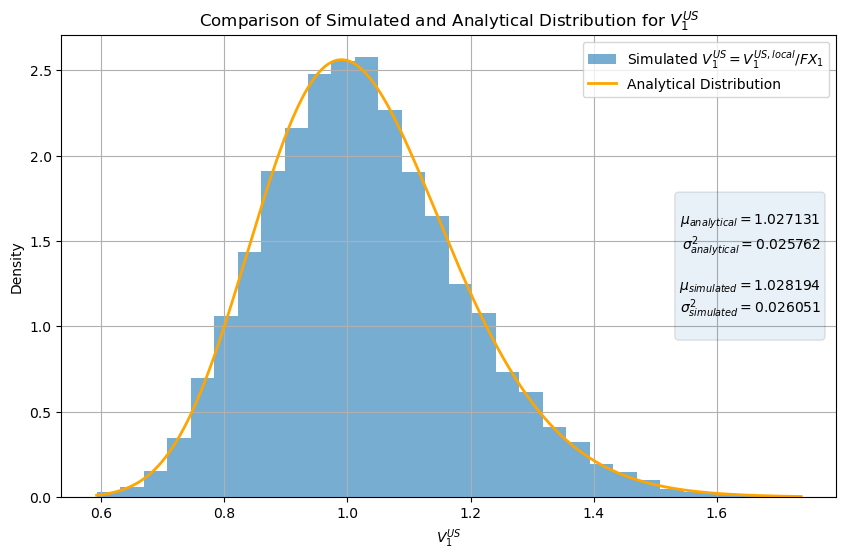

Estimated Mean Vector (mu_P1):
[1.06002153 1.08561101 1.07419135 0.86173156 0.92350416]

Estimated Mean Vector (mu_P1_EUR):
[0.94886806 1.02819406 1.07419135 0.81714404 0.92350416]

Estimated Variances for P1:
Component 1: Variance = 0.006540
Component 2: Variance = 0.026554
Component 3: Variance = 0.028433
Component 4: Variance = 0.000724
Component 5: Variance = 0.000509

Estimated Variances for P1_EUR:
Component 1: Variance = 0.005241
Component 2: Variance = 0.026054
Component 3: Variance = 0.028433
Component 4: Variance = 0.003680
Component 5: Variance = 0.000509


In [25]:
# Simulated values
empirical_mean = np.mean(P1_components[:, 1])
empirical_variance = np.var(P1_components[:, 1])

# Analytical PDF
x_vals = np.linspace(min(P1_components[:, 1]), max(P1_components[:, 1]), 500)
pdf_vals = lognorm.pdf(x_vals, s=np.sqrt(var_log_V1_US_Local), scale=np.exp(mu_log_V1_US_Local))

# Text for the plot
textstr = f"""
$\\mu_{{analytical}} = {Analytical_mean_V1_US_Local:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_V1_US_Local:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""

# Plot simulation vs analytical distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(P1_components[:, 1], bins=30, density=True, alpha=0.6, label="Simulated $V_1^{US, local}$")
ax.plot(x_vals, pdf_vals, label="Analytical Distribution", linewidth=2, color='orange')
ax.set_title("Comparison of Simulated and Analytical Distribution for $V_1^{US, local}$")
ax.set_xlabel("$V_1^{US}$")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

# Add text box
ax.text(
    0.98, 0.5, textstr, transform=ax.transAxes, fontsize=10,
    verticalalignment='center', horizontalalignment='right',
    bbox=dict(boxstyle="round", alpha=0.1)
)

plt.show()

# Simulated values
empirical_mean = np.mean(P_EUR_1[:, 1])
empirical_variance = np.var(P_EUR_1[:, 1])

# Analytical PDF
x_vals = np.linspace(min(P_EUR_1[:, 1]), max(P_EUR_1[:, 1]), 500)
pdf_vals = lognorm.pdf(x_vals, s=np.sqrt(var_V1_US), scale=np.exp(mu_V1_US))

# Text for the plot
textstr = f"""
$\\mu_{{analytical}} = {Analytical_mu_V1_US:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_V1_US:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""

# Plot simulation vs analytical distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(P_EUR_1[:, 1], bins=30, density=True, alpha=0.6, label="Simulated $V_1^{US} = V_1^{US, local} / FX_1$")
ax.plot(x_vals, pdf_vals, label="Analytical Distribution", linewidth=2, color='orange')
ax.set_title("Comparison of Simulated and Analytical Distribution for $V_1^{US}$")
ax.set_xlabel("$V_1^{US}$")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

# Add text box
ax.text(
    0.98, 0.5, textstr, transform=ax.transAxes, fontsize=10,
    verticalalignment='center', horizontalalignment='right',
    bbox=dict(boxstyle="round", alpha=0.1)
)
plt.savefig("V1_US_P1_EUR.png")
plt.show()

# Print the results from before
print("Estimated Mean Vector (mu_P1):")
print(mu_P1)

variances_P1 = np.diag(Sigma_P1)
std_devs_P1 = np.sqrt(variances_P1)

# Estimate mean vector and covariance matrix
mu_P_EUR_1 = np.mean(P_EUR_1, axis=0)
Sigma_P_EUR_1 = np.cov(P_EUR_1, rowvar=False)

print("\nEstimated Mean Vector (mu_P1_EUR):")
print(mu_P_EUR_1)

# Extract variances (diagonal elements of the covariance matrix)
variances = np.diag(Sigma_P_EUR_1)

# Compute standard deviations
std_devs = np.sqrt(variances)

print("\nEstimated Variances for P1:")
for i, var in enumerate(variances_P1):
    print(f"Component {i+1}: Variance = {var:.6f}")

print("\nEstimated Variances for P1_EUR:")
for i, var in enumerate(variances):
    print(f"Component {i+1}: Variance = {var:.6f}")

# Estimate mean vector and covariance matrix
mu_P1_EUR = np.mean(P_EUR_1, axis=0)
Sigma_P1_EUR = np.cov(P_EUR_1, rowvar=False)



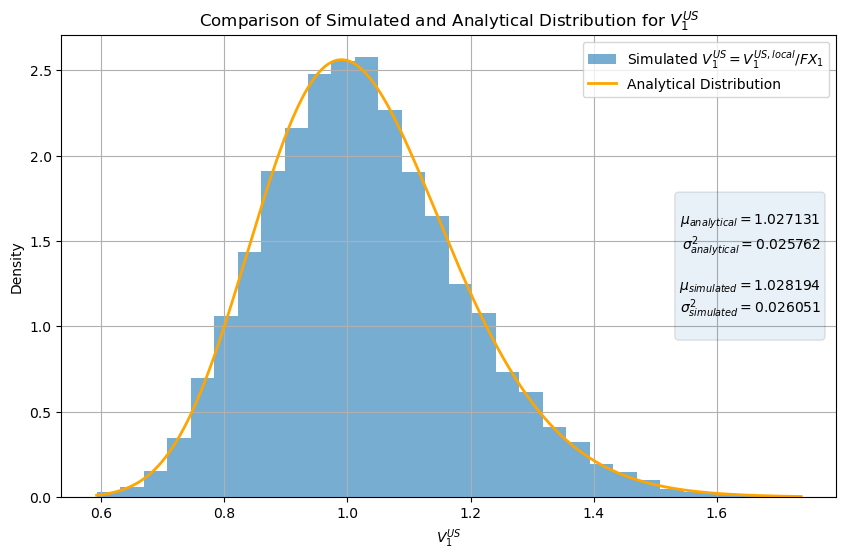

In [26]:
# Simulated values
empirical_mean = np.mean(P_EUR_1[:, 1])
empirical_variance = np.var(P_EUR_1[:, 1])

# Analytical PDF
x_vals = np.linspace(min(P_EUR_1[:, 1]), max(P_EUR_1[:, 1]), 500)
pdf_vals = lognorm.pdf(x_vals, s=np.sqrt(var_V1_US), scale=np.exp(mu_V1_US))

# Text for the plot
textstr = f"""
$\\mu_{{analytical}} = {Analytical_mu_V1_US:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_V1_US:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""

# Plot simulation vs analytical distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(P_EUR_1[:, 1], bins=30, density=True, alpha=0.6, label="Simulated $V_1^{US} = V_1^{US, local} / FX_1$")
ax.plot(x_vals, pdf_vals, label="Analytical Distribution", linewidth=2, color='orange')
ax.set_title("Comparison of Simulated and Analytical Distribution for $V_1^{US}$")
ax.set_xlabel("$V_1^{US}$")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

# Add text box
ax.text(
    0.98, 0.5, textstr, transform=ax.transAxes, fontsize=10,
    verticalalignment='center', horizontalalignment='right',
    bbox=dict(boxstyle="round", alpha=0.1)
)
plt.savefig("V1_US_P1_EUR.png")
plt.show()


### Plotting $FX_1$ and $1/FX_1$

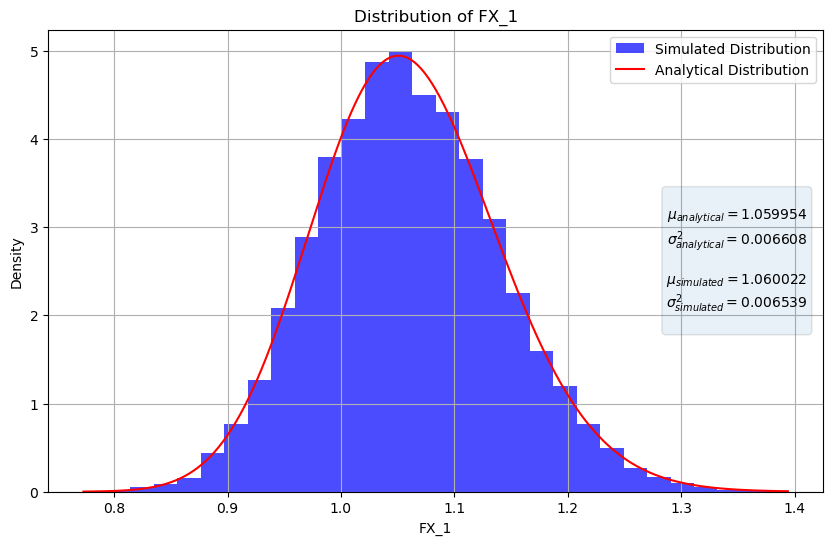

Empirical mean of FX_1: 1.060022
Empirical variance of FX_1: 0.006539
Theoretical mean of FX_1: 1.059954
Theoretical variance of FX_1: 0.006608


In [27]:
# Simulate paths for FX_t instead of log(FX_t)
fx_simulations = np.exp(simulations[:, 0, :])  # Transform log(FX_t) to FX_t

# Extract FX_1 (final FX value at horizon)
fx_1 = fx_simulations[-1, :]  # Values of FX_t at t = 1

mu_logFX_1 = x0[0] + mu[0]*52
var_logFX_1 = cov_matrix[0,0]*52
Analytical_mean_FX_1 = lognormal_mean(mu_logFX_1, var_logFX_1)
Analytical_var_FX_1 = lognormal_variance(mu_logFX_1,var_logFX_1)

# Calculate empirical mean and variance
empirical_mean_fx = np.mean(fx_1)
empirical_variance_fx = np.var(fx_1)

# Generate x values for theoretical PDF
x_values_fx = np.linspace(min(fx_1), max(fx_1), 500)
pdf_vals = lognorm.pdf(x_values_fx, s=np.sqrt(var_logFX_1), scale=np.exp(mu_logFX_1))

# Plot histogram of FX_1 (final FX_t distribution) with theoretical PDF
plt.figure(figsize=(10, 6))
plt.hist(fx_1, bins=30, density=True, alpha=0.7, color='blue', label='Simulated Distribution')
plt.plot(x_values_fx, pdf_vals, 'r-', label='Analytical Distribution')
plt.title("Distribution of FX_1")
plt.xlabel("FX_1")
plt.ylabel("Density")
plt.legend()

textstr_fx = f"""
$\\mu_{{analytical}} = {Analytical_mean_FX_1:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_FX_1:.6f}$

$\\mu_{{simulated}} = {empirical_mean_fx:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_fx:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr_fx, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.savefig("distribution_fx_with_theoretical.png")
plt.show()

print(f"Empirical mean of FX_1: {empirical_mean_fx:.6f}")
print(f"Empirical variance of FX_1: {empirical_variance_fx:.6f}")
print(f"Theoretical mean of FX_1: {Analytical_mean_FX_1:.6f}")
print(f"Theoretical variance of FX_1: {Analytical_var_FX_1:.6f}")


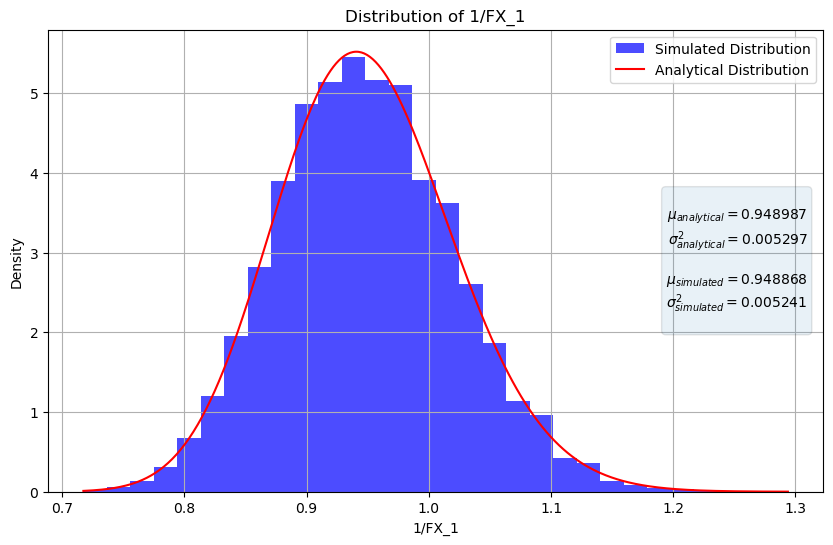

Empirical mean of 1/FX_1: 0.948868
Empirical variance of 1/FX_1: 0.005241
Theoretical mean of 1/FX_1: 0.948987
Theoretical variance of 1/FX_1: 0.005297


In [28]:
# Calculate 1/FX_t from simulations
inverse_fx_simulations = 1 / np.exp(simulations[:, 0, :])  # Inverse of FX_t

# Extract 1/FX_1 (final value at the horizon)
inverse_fx_1 = inverse_fx_simulations[-1, :]  # Values of 1/FX_t at t = 1

# Calculate empirical mean and variance for 1/FX_1
empirical_mean_inverse_fx = np.mean(inverse_fx_1)
empirical_variance_inverse_fx = np.var(inverse_fx_1)

# Generate x-values for theoretical PDF
x_values_inverse_fx = np.linspace(min(inverse_fx_1), max(inverse_fx_1), 500)
pdf_vals = lognorm.pdf(x_values_inverse_fx, s=np.sqrt(var_logFX_1), scale=np.exp(-mu_logFX_1))

# Plot histogram for 1/FX_1 with theoretical PDF
plt.figure(figsize=(10, 6))
plt.hist(inverse_fx_1, bins=30, density=True, alpha=0.7, color='blue', label='Simulated Distribution')
plt.plot(x_values_inverse_fx, pdf_vals, 'r-', label='Analytical Distribution')
plt.title("Distribution of 1/FX_1")
plt.xlabel("1/FX_1")
plt.ylabel("Density")
plt.legend()

textstr_inverse_fx = f"""
$\\mu_{{analytical}} = {Analytical_mean_1_FX_1:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_1_FX_1:.6f}$

$\\mu_{{simulated}} = {empirical_mean_inverse_fx:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_inverse_fx:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr_inverse_fx, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.savefig("distribution_inverse_fx_with_theoretical.png")
plt.show()

print(f"Empirical mean of 1/FX_1: {empirical_mean_inverse_fx:.6f}")
print(f"Empirical variance of 1/FX_1: {empirical_variance_inverse_fx:.6f}")
print(f"Theoretical mean of 1/FX_1: {Analytical_mean_1_FX_1:.6f}")
print(f"Theoretical variance of 1/FX_1: {Analytical_var_1_FX_1:.6f}")


### $V_1^{\text{USD}}$ again

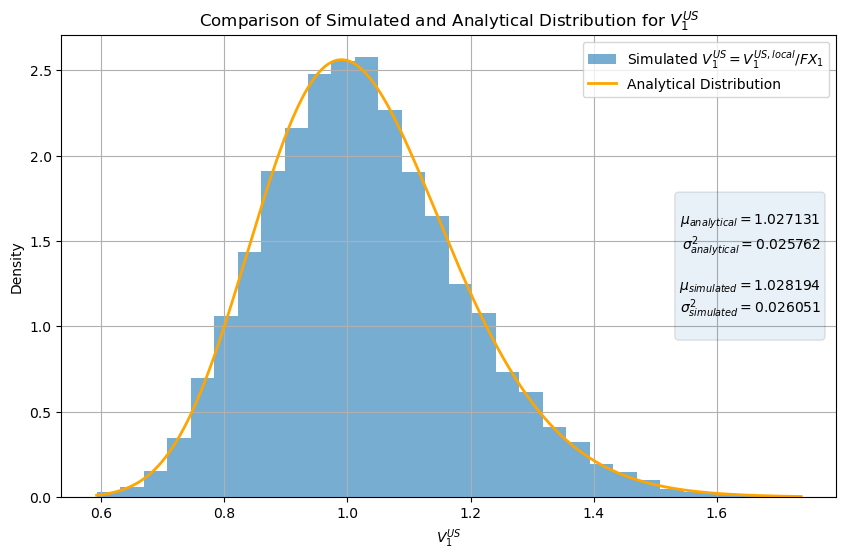

In [29]:
#Simulated values
empirical_mean = np.mean(P_EUR_1[:, 1])
empirical_variance = np.var(P_EUR_1[:, 1])


#Analytical pdf
x_vals = np.linspace(min(P_EUR_1[:, 1]), max(P_EUR_1[:, 1]), 500)
pdf_vals = lognorm.pdf(x_vals, s=np.sqrt(var_V1_US), scale=np.exp(mu_V1_US))

textstr = f"""
$\\mu_{{analytical}} = {Analytical_mu_V1_US:.6f}$
$\\sigma^2_{{analytical}} = {Analytical_var_V1_US:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(P_EUR_1[:, 1], bins=30, density=True, alpha=0.6, label="Simulated $V_1^{US} = V_1^{US, local} / FX_1$")
ax.plot(x_vals, pdf_vals, label="Analytical Distribution", linewidth=2, color='orange')
ax.set_title("Comparison of Simulated and Analytical Distribution for $V_1^{US}$")
ax.set_xlabel("$V_1^{US}$")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

ax.text(
    0.98, 0.5, textstr, transform=ax.transAxes, fontsize=10,
    verticalalignment='center', horizontalalignment='right',
    bbox=dict(boxstyle="round", alpha=0.1)
)
plt.savefig("V1_US_P1_EUR.png")
plt.show()


# Plots for P_1 and P_1_EUR

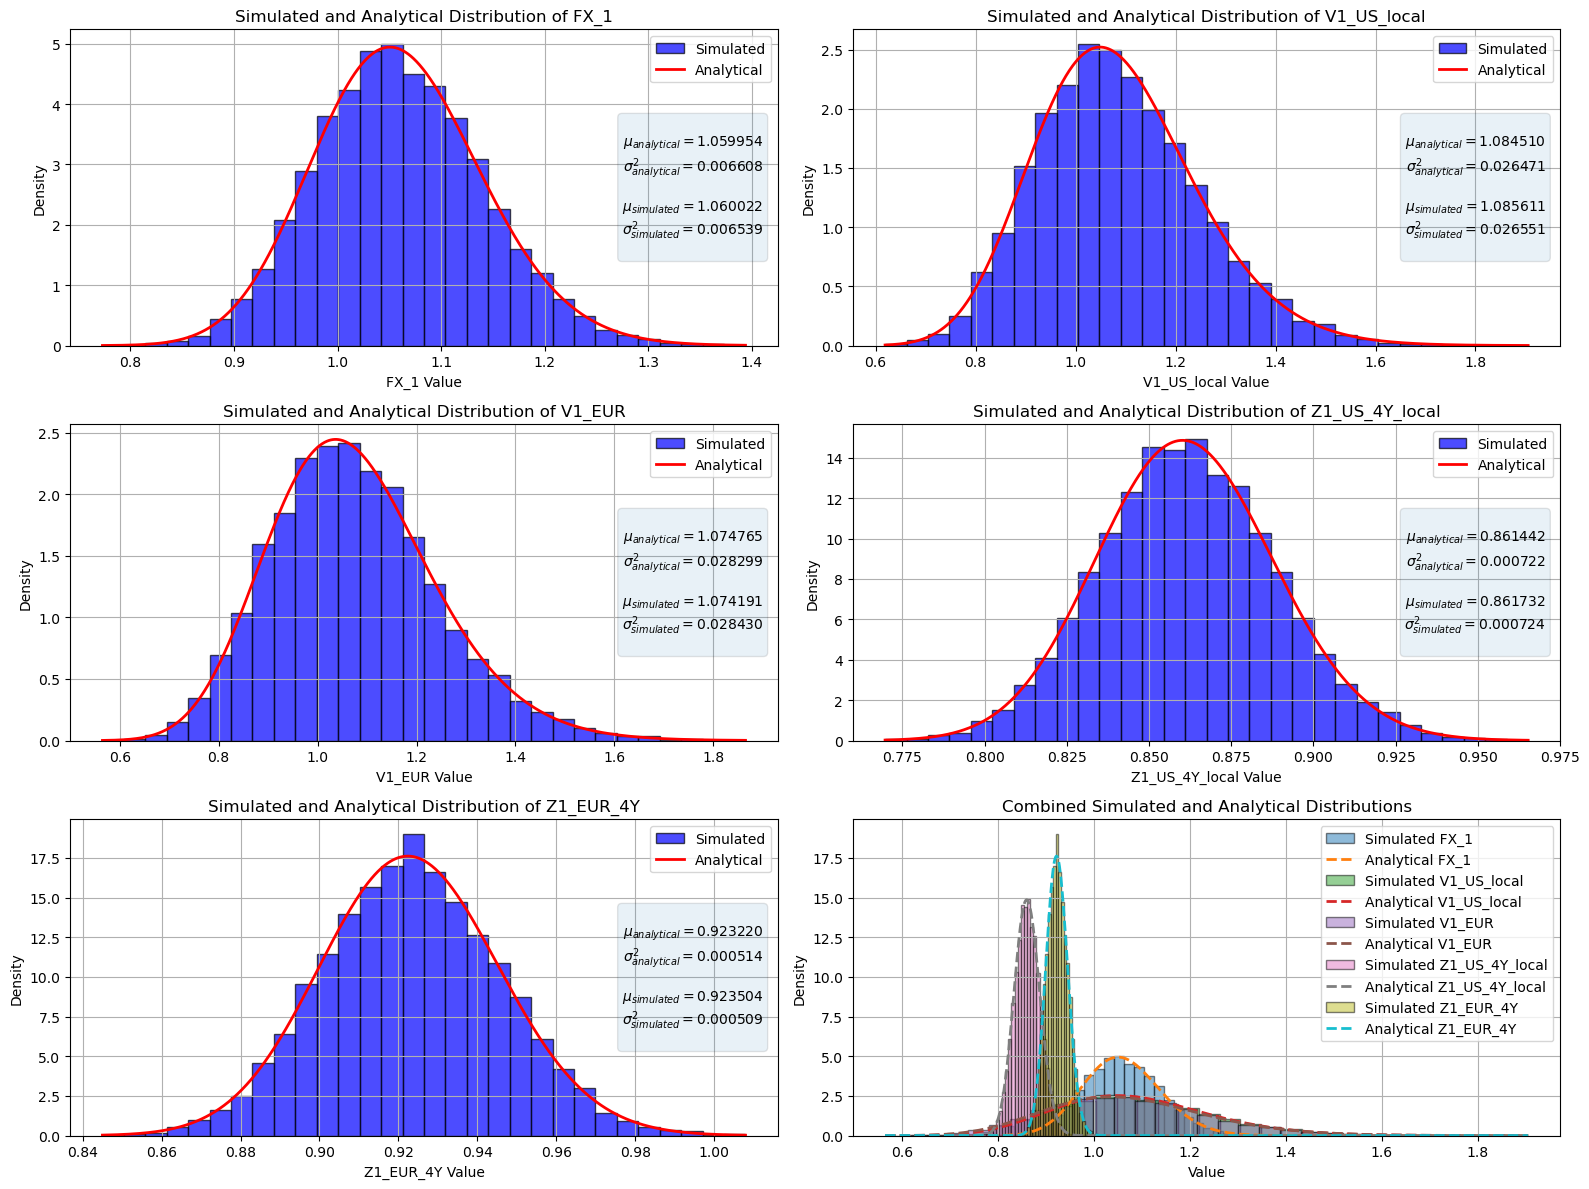

In [30]:
component_labels = ["FX_1", "V1_US_local", "V1_EUR", "Z1_US_4Y_local", "Z1_EUR_4Y"]

analytical_means = [
    Analytical_mean_FX_1,
    Analytical_mean_V1_US_Local,
    Analytical_mean_V1_EUR,
    Analytical_mean_Z1_USD_local,
    Analytical_mean_Z1_EUR,
]

analytical_vars = [
    Analytical_var_FX_1,
    Analytical_var_V1_US_Local,
    Analytical_var_V1_EUR,
    Analytical_var_Z1_USD_local,
    Analytical_var_Z1_EUR,
]

# Function to compute lognormal parameters from mean and variance
def compute_lognorm_params(mean, var):
    sigma = np.sqrt(np.log(1 + var / mean**2))  
    mu = np.log(mean) - 0.5 * sigma**2  
    return mu, sigma

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot individual histograms
for i, label in enumerate(component_labels):
    row, col = divmod(i, 2)  # Determine position in grid
    data = P1_components[:, i]
    
    empirical_mean = np.mean(data)
    empirical_variance = np.var(data)
    
    mean = analytical_means[i]
    var = analytical_vars[i]
    mu, sigma = compute_lognorm_params(mean, var)
    
    axes[row, col].hist(data, bins=30, alpha=0.7, density=True, color="blue", edgecolor="black", label="Simulated")
    
    # Add analytical log-normal distribution
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    axes[row, col].plot(x, pdf, 'r-', linewidth=2, label="Analytical")
    
    textstr = f"""
$\\mu_{{analytical}} = {mean:.6f}$
$\\sigma^2_{{analytical}} = {var:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""
    axes[row, col].text(0.98, 0.5, textstr, transform=axes[row, col].transAxes, fontsize=10, 
                        verticalalignment='center', horizontalalignment='right',
                        bbox=dict(boxstyle="round", alpha=0.1))
    
    axes[row, col].set_title(f"Simulated and Analytical Distribution of {label}")
    axes[row, col].set_xlabel(f"{label} Value")
    axes[row, col].set_ylabel("Density")
    axes[row, col].legend()  
    axes[row, col].grid(True)

row, col = divmod(5, 2)
combined_ax = axes[row, col]
x_combined = np.linspace(P1_components.min(), P1_components.max(), 1000)

for i, label in enumerate(component_labels):
    data = P1_components[:, i]
    
    combined_ax.hist(data, bins=30, alpha=0.5, density=True, label=f"Simulated {label}", edgecolor="black")
    
    # Add analytical log-normal distribution
    mean = analytical_means[i]
    var = analytical_vars[i]
    mu, sigma = compute_lognorm_params(mean, var)
    pdf = lognorm.pdf(x_combined, s=sigma, scale=np.exp(mu))
    combined_ax.plot(x_combined, pdf, linewidth=2, linestyle="--", label=f"Analytical {label}")

combined_ax.set_title("Combined Simulated and Analytical Distributions")
combined_ax.set_xlabel("Value")
combined_ax.set_ylabel("Density")
combined_ax.legend(loc="best")
combined_ax.grid(True)

plt.tight_layout()
plt.savefig("P1_simulations_with_boxes.png")
plt.show()


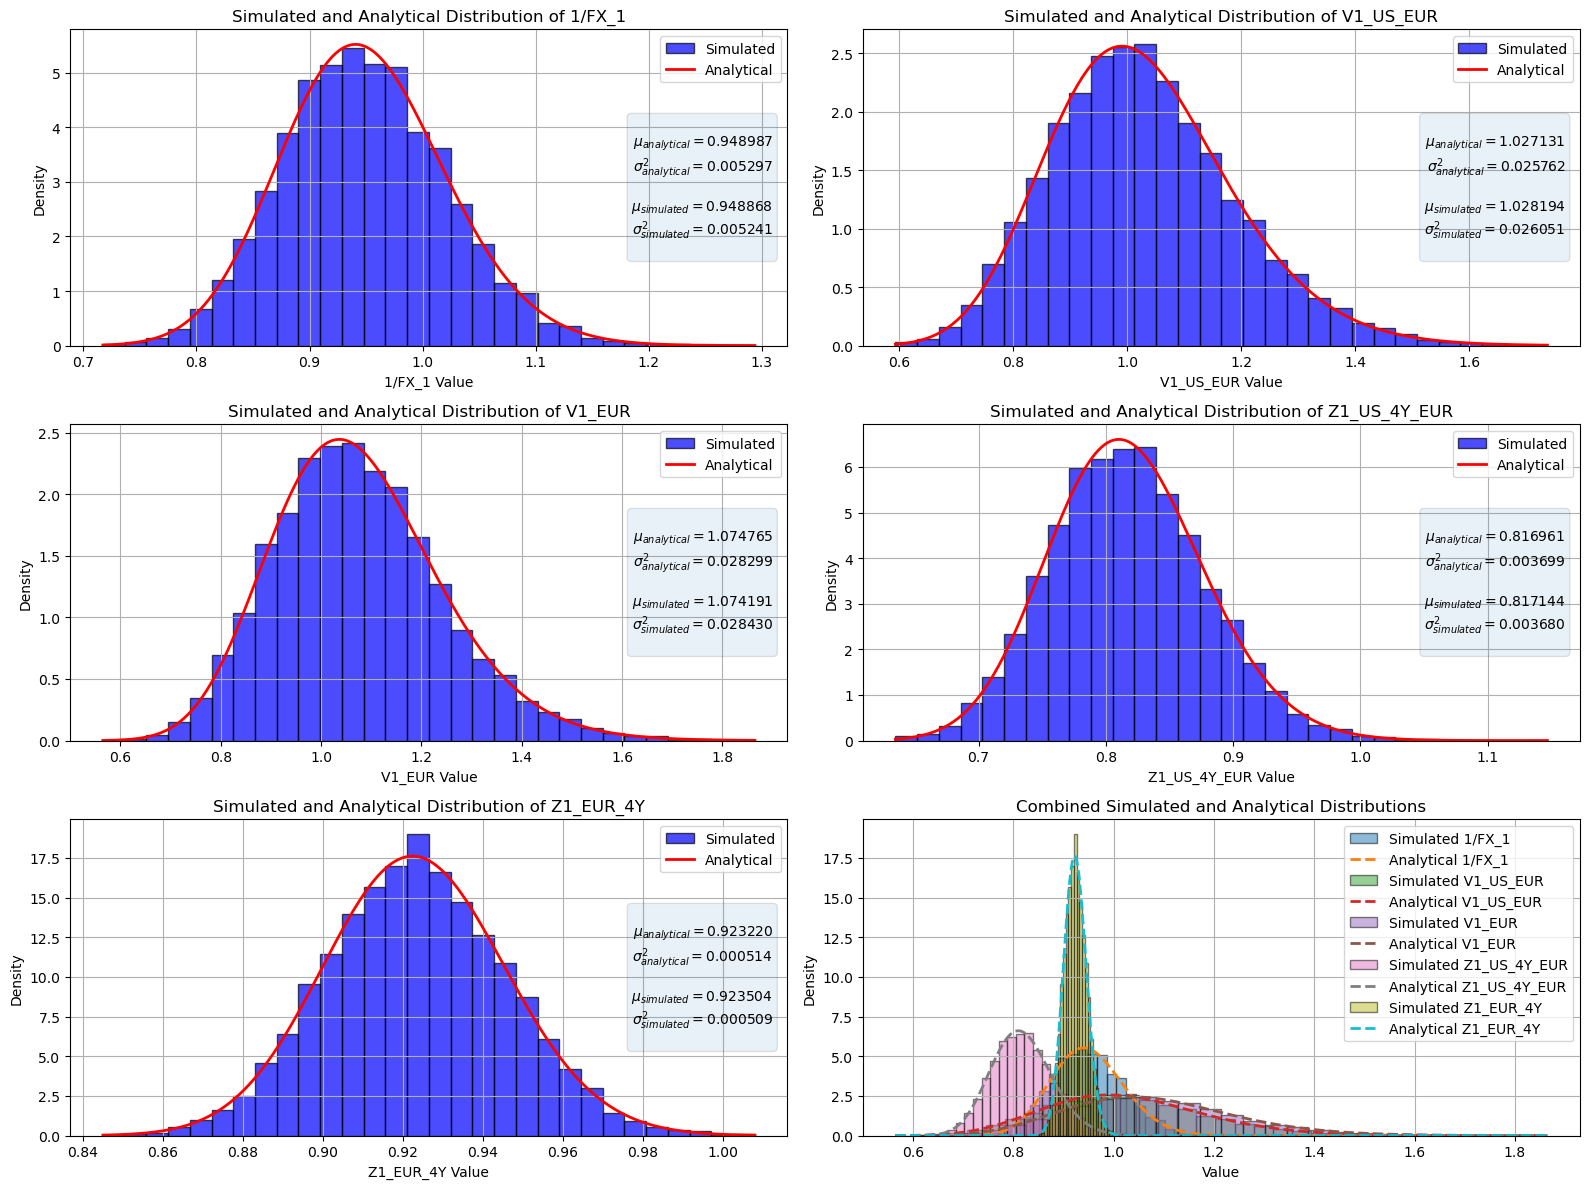

In [31]:
component_labels = ["1/FX_1", "V1_US_EUR", "V1_EUR", "Z1_US_4Y_EUR", "Z1_EUR_4Y"]

analytical_means = [
    Analytical_mean_1_FX_1,
    Analytical_mu_V1_US, 
    Analytical_mean_V1_EUR,
    Analytical_mean_z1_USD,
    Analytical_mean_Z1_EUR,
]

analytical_vars = [
    Analytical_var_1_FX_1,
    Analytical_var_V1_US,  
    Analytical_var_V1_EUR,
    Analytical_var_z1_USD,
    Analytical_var_Z1_EUR,
]


fig, axes = plt.subplots(3, 2, figsize=(16, 12))


for i, label in enumerate(component_labels):
    row, col = divmod(i, 2) 
    data = P_EUR_1[:, i]
    
    empirical_mean = np.mean(data)
    empirical_variance = np.var(data)
    
    # Compute analytical statistics
    mean = analytical_means[i]
    var = analytical_vars[i]
    mu, sigma = compute_lognorm_params(mean, var)
    
    # Plot histogram
    axes[row, col].hist(data, bins=30, alpha=0.7, density=True, color="blue", edgecolor="black", label="Simulated")
    
    # Add analytical log-normal distribution
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    axes[row, col].plot(x, pdf, 'r-', linewidth=2, label="Analytical")
    
    textstr = f"""
$\\mu_{{analytical}} = {mean:.6f}$
$\\sigma^2_{{analytical}} = {var:.6f}$

$\\mu_{{simulated}} = {empirical_mean:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance:.6f}$
"""
    axes[row, col].text(0.98, 0.5, textstr, transform=axes[row, col].transAxes, fontsize=10, 
                        verticalalignment='center', horizontalalignment='right',
                        bbox=dict(boxstyle="round", alpha=0.1))
    
    axes[row, col].set_title(f"Simulated and Analytical Distribution of {label}")
    axes[row, col].set_xlabel(f"{label} Value")
    axes[row, col].set_ylabel("Density")
    axes[row, col].legend()  
    axes[row, col].grid(True)

row, col = divmod(5, 2)
combined_ax = axes[row, col]
x_combined = np.linspace(P_EUR_1.min(), P_EUR_1.max(), 1000)

for i, label in enumerate(component_labels):
    data = P_EUR_1[:, i]
    
    combined_ax.hist(data, bins=30, alpha=0.5, density=True, label=f"Simulated {label}", edgecolor="black")
    
    # Add analytical log-normal distribution
    mean = analytical_means[i]
    var = analytical_vars[i]
    mu, sigma = compute_lognorm_params(mean, var)
    pdf = lognorm.pdf(x_combined, s=sigma, scale=np.exp(mu))
    combined_ax.plot(x_combined, pdf, linewidth=2, linestyle="--", label=f"Analytical {label}")

# Customize combined plot layout
combined_ax.set_title("Combined Simulated and Analytical Distributions")
combined_ax.set_xlabel("Value")
combined_ax.set_ylabel("Density")
combined_ax.legend(loc="best")
combined_ax.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.savefig("P1_EUR_simulations_with_boxes.png")
plt.show()


## Analytical Mean Vector and Variances for $\boldsymbol{P}_1^{\text{EUR}}$

In [32]:
#Saving mu again:
mu = np.zeros(len(cov_matrix))  # Initialize with zeroes
mu[1] = 0.07 * delta_t  
mu[2] = 0.06 * delta_t 

In [33]:
#Mean vector for P_1_EUR
print(analytical_means)
#Variances for P_1_EUR
print(analytical_vars)

[0.9489866779587082, 1.02713138521889, 1.074764595705856, 0.8169609715437517, 0.9232198839123239]
[0.005296974403192497, 0.025761646547379086, 0.028298786766039644, 0.003698641117543395, 0.0005139198410039965]


# Part 2 - $PnL_1$

The PnL vector is defined as:
$$
\[
\mathbf{PnL}_1 = 
\begin{bmatrix}
\frac{1}{F_0^1} - \frac{1}{FX_1} \\
V_{US}^1 - V_{US}^0 \\
V_{EUR}^1 - V_{EUR}^0 \\
Z_{USD,4Y}^1 - Z_{USD,5Y}^0 \\
Z_{EUR,4Y}^1 - Z_{EUR,5Y}^0
\end{bmatrix}.
\]
$$

#### Forward

In [34]:
# Extract relevant values
fx_kurs = init_values.iloc[0]['initial values']
one_year_EUR = init_values.iloc[4]['initial values']
one_year_USD = init_values.iloc[10]['initial values']
fx_linear = np.exp(fx_kurs)
inverse_spot = 1/fx_linear
rate_differential = one_year_USD - one_year_EUR
forward_price = fx_linear * np.exp(rate_differential)

print(f"FX spot rate (EUR/USD): {fx_kurs:.8f}")
print(f"1-year EUR yield: {one_year_EUR:.8f}")
print(f"1-year USD yield: {one_year_USD:.8f}")
print(f"FX spot rate (EUR/USD) in linear scale: {fx_linear:.8f}")
print(f"Inverse FX spot rate (USD/EUR) in linear scale: {inverse_spot:.8f}")
print(f"Interest rate differential (USD - EUR): {rate_differential:.8f}")
print(f"1-year FX forward price (EUR/USD): {forward_price:.8f}")


V0_US = np.exp(init_values.iloc[1]['initial values'])*1/fx_linear
V0_EUR = np.exp(init_values.iloc[2]['initial values'])


y_t_USD_5Y = init_values.iloc[12]['initial values']  
Z0_USD_Y_price = 1 * np.exp(-y_t_USD_5Y * 5)  
Z0_USD_Y_price_eur = Z0_USD_Y_price*(1/fx_linear)

y_t_EUR_5Y = (init_values.iloc[6]['initial values'])
Z0_EUR_Y_price = 1 * np.exp(-y_t_EUR_5Y * 5)  
Z_EUR_5Y = np.exp(init_values.iloc[6]['initial values'])


print(f"Interest rate differential (USD - EUR): {rate_differential:.8f}")
print(f"1-year : {V0_EUR:.8f}")
print(f"Z_USD_5Y: {Z0_USD_Y_price:.8f}")
print(f"Z0_USD_Y_price_eur: {Z0_USD_Y_price_eur:.8f}")
print(f"Z0_EUR_Y_price: {Z0_EUR_Y_price:.8f}")


FX spot rate (EUR/USD): 0.05529279
1-year EUR yield: 0.02246653
1-year USD yield: 0.04167324
FX spot rate (EUR/USD) in linear scale: 1.05685000
Inverse FX spot rate (USD/EUR) in linear scale: 0.94620807
Interest rate differential (USD - EUR): 0.01920671
1-year FX forward price (EUR/USD): 1.07734480
Interest rate differential (USD - EUR): 0.01920671
1-year : 1.00000000
Z_USD_5Y: 0.82940812
Z0_USD_Y_price_eur: 0.78479266
Z0_EUR_Y_price: 0.90462341


In [35]:
PNL1 = P_EUR_1.copy() #Need to be a copy otherwise we will change P_EUR_1
PNL1[:,0] = 1/forward_price-P_EUR_1[:, 0]
PNL1[:,1] = P_EUR_1[:, 1]-V0_US
PNL1[:,2] = P_EUR_1[:, 2]-V0_EUR
PNL1[:,3] = P_EUR_1[:, 3]-Z0_USD_Y_price_eur
PNL1[:,4] = P_EUR_1[:, 4]-Z0_EUR_Y_price

In [36]:
PNL1_FX = 1/forward_price-P_EUR_1[:, 0]
PNL1_VUS = P_EUR_1[:, 1]-V0_US
PNL1_VEUR = P_EUR_1[:, 2]-V0_EUR
PNL1_ZUSD = P_EUR_1[:, 3]-Z0_USD_Y_price_eur
PNL1_ZEUR = P_EUR_1[:, 4]-Z0_EUR_Y_price

In [37]:
pnl_analytical_means = [
    1 / forward_price - analytical_means[0],                  # PNL1_FX
    analytical_means[1] - V0_US,                             # PNL2_VUS
    analytical_means[2] - V0_EUR,                            # PNL3_VEUR
    analytical_means[3] - Z0_USD_Y_price_eur,                # PNL4_ZUSD
    analytical_means[4] - Z0_EUR_Y_price                     # PNL5_ZEUR
]

pnl_analytical_vars = [
    analytical_vars[0], 
    analytical_vars[1],  
    analytical_vars[2],  
    analytical_vars[3],  
    analytical_vars[4]   
]

pnl_analytical_means = np.array(pnl_analytical_means)
pnl_analytical_vars = np.array(pnl_analytical_vars)

print("Analytical Means:", pnl_analytical_means)
print("Analytical Variances:", pnl_analytical_vars)


Analytical Means: [-0.02077873  0.08092331  0.0747646   0.03216831  0.01859647]
Analytical Variances: [0.00529697 0.02576165 0.02829879 0.00369864 0.00051392]


In [38]:
# Simulated means pnl
print(np.mean(PNL1_FX))
print(np.mean(PNL1_VUS))
print(np.mean(PNL1_VEUR))
print(np.mean(PNL1_ZUSD))
print(np.mean(PNL1_ZEUR))

-0.0206601173981778
0.08198599360626171
0.07419134573538433
0.032351375181257254
0.018880747136756807


In [39]:
# Simulated variance pnl
print(np.var(PNL1_FX))
print(np.var(PNL1_VUS))
print(np.var(PNL1_VEUR))
print(np.var(PNL1_ZUSD))
print(np.var(PNL1_ZEUR))

0.005240782847314706
0.02605101599811614
0.028429781512169627
0.0036796637662875695
0.0005089196543710883


In [40]:
pnl_1_forward_analytical_mean= 1/forward_price-analytical_means[:1]
print("pnl1 mean",pnl_1_forward_analytical_mean)
pnl_1_forward_analytical_var= analytical_vars[:1]
print("pnl1 var",pnl_1_forward_analytical_var)
pnl_2_VUS_analytical_mean=analytical_means[1:2]-V0_US
print("pnl2 mean",pnl_2_VUS_analytical_mean)
pnl_2_VUS_analytical_var= analytical_vars[1:2]
print("pnl2 var",pnl_2_VUS_analytical_var)
pnl_3_VEUR_analytical_mean=analytical_means[2:3]-V0_EUR
print("pnl3 mean",pnl_3_VEUR_analytical_mean)
pnl_3_VEUR_analytical_var= analytical_vars[2:3]
print("pnl3 var",pnl_3_VEUR_analytical_var)
pnl_4_ZUSD_analytical_mean=analytical_means[3:4]-Z0_USD_Y_price_eur
print("pnl4 mean",pnl_4_ZUSD_analytical_mean)
pnl_4_ZUSD_analytical_var= analytical_vars[3:4]
print("pnl4 var",pnl_4_ZUSD_analytical_var)
pnl_5_ZEUR_analytical_mean=analytical_means[4:5]-Z0_EUR_Y_price
print("pnl5 mean",pnl_5_ZEUR_analytical_mean)
pnl_5_ZEUR_analytical_var= analytical_vars[4:5]
print("pnl5 var",pnl_5_ZEUR_analytical_var)

pnl1 mean [-0.02077873]
pnl1 var [0.005296974403192497]
pnl2 mean [0.08092331]
pnl2 var [0.025761646547379086]
pnl3 mean [0.0747646]
pnl3 var [0.028298786766039644]
pnl4 mean [0.03216831]
pnl4 var [0.003698641117543395]
pnl5 mean [0.01859647]
pnl5 var [0.0005139198410039965]


In [41]:
PNL_matrix = np.vstack([PNL1_FX, PNL1_VUS, PNL1_VEUR, PNL1_ZUSD, PNL1_ZEUR])

In [42]:
pd.DataFrame(PNL_matrix)

0         1         2         3         4         5         6     \
0  0.029398  0.069423  0.020981 -0.138064 -0.006770  0.049558 -0.177617   
1 -0.034107 -0.014669  0.180877  0.089721  0.023939 -0.044547  0.212639   
2 -0.044432  0.117178  0.233063  0.001474 -0.026404  0.064971  0.150509   
3 -0.005736  0.007710 -0.014601  0.116326  0.069606  0.028524  0.124010   
4  0.019823  0.067765 -0.009496  0.023083  0.047423  0.067778 -0.001895   

       7         8         9     ...      9990      9991      9992      9993  \
0  0.020107 -0.074048 -0.026536  ... -0.052415  0.100941  0.004756 -0.023663   
1  0.053022  0.130121  0.129054  ...  0.170970 -0.096353 -0.003266  0.352990   
2 -0.046375  0.234039  0.142237  ...  0.145964  0.029151  0.037298  0.148144   
3  0.011380  0.076048  0.055752  ...  0.054805 -0.079523 -0.009672  0.062666   
4  0.022249  0.025794  0.022879  ...  0.041101 -0.005854 -0.000445  0.063212   

       9994      9995      9996      9997      9998      9999  
0  0.061886  0.127814  0.013695 -0.051934 -0.045660 -0.047484  
1  0.084430  0.014257  0.200565  0.226280 -0.008853  0.071169  
2 -0.153990 -0.044081  0.048907  0.202359  0.114736 -0.001479  
3 -0.035028 -0.070501  0.028594  0.094136  0.037025  0.083585  
4  0.036618  0.032829  0.034659  0.041104 -0.011262  0.046250  

[5 rows x 10000 columns]

## Visualization of $PnL_1$ components

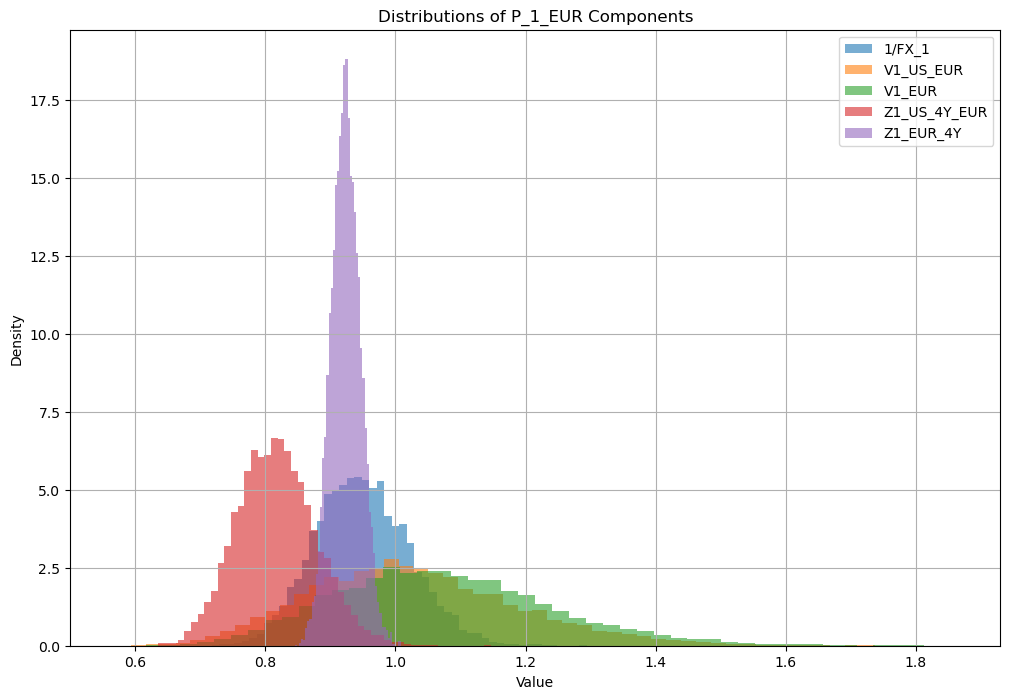

In [43]:
PnL_vars = [P_EUR_1[:, 0], P_EUR_1[:, 1], P_EUR_1[:, 2], P_EUR_1[:, 3], P_EUR_1[:, 4]]
labels = ["1/FX_1", "V1_US_EUR", "V1_EUR", "Z1_US_4Y_EUR", "Z1_EUR_4Y"]

# Plot each distribution
plt.figure(figsize=(12, 8))
for pnl, label in zip(PnL_vars, labels):
    plt.hist(pnl, bins=50, alpha=0.6, density=True, label=label)

plt.title("Distributions of P_1_EUR Components")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

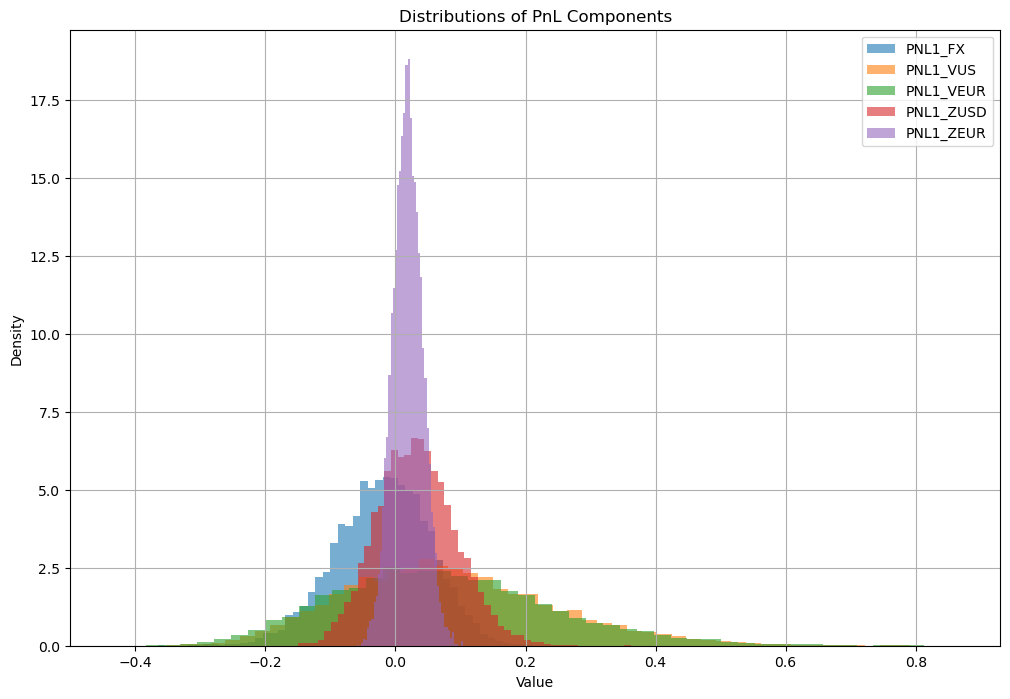

In [44]:
PnL_vars = [PNL1_FX, PNL1_VUS, PNL1_VEUR, PNL1_ZUSD, PNL1_ZEUR]
labels = ["PNL1_FX", "PNL1_VUS", "PNL1_VEUR", "PNL1_ZUSD", "PNL1_ZEUR"]

# Plot each distribution
plt.figure(figsize=(12, 8))
for pnl, label in zip(PnL_vars, labels):
    plt.hist(pnl, bins=50, alpha=0.6, density=True, label=label)

plt.title("Distributions of PnL Components")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

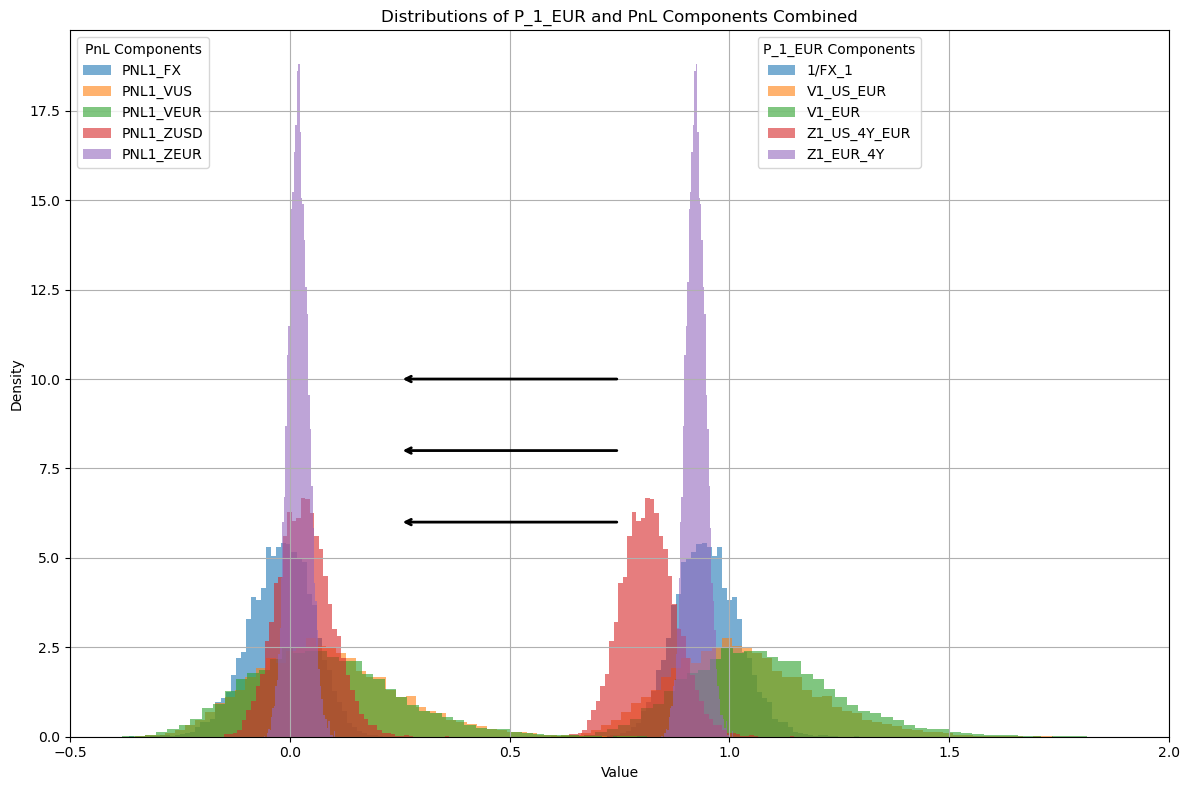

In [45]:
# Data
PnL_vars_1 = [P_EUR_1[:, 0], P_EUR_1[:, 1], P_EUR_1[:, 2], P_EUR_1[:, 3], P_EUR_1[:, 4]]
labels_1 = ["1/FX_1", "V1_US_EUR", "V1_EUR", "Z1_US_4Y_EUR", "Z1_EUR_4Y"]

PnL_vars_2 = [PNL1_FX, PNL1_VUS, PNL1_VEUR, PNL1_ZUSD, PNL1_ZEUR]
labels_2 = ["PNL1_FX", "PNL1_VUS", "PNL1_VEUR", "PNL1_ZUSD", "PNL1_ZEUR"]

color_map = {
    "1/FX_1": "#1f77b4",       # BLue
    "PNL1_FX": "#1f77b4",       
    "V1_US_EUR": "#ff7f0e",    # Orange
    "PNL1_VUS": "#ff7f0e",
    "V1_EUR": "#2ca02c",       # Green
    "PNL1_VEUR": "#2ca02c",
    "Z1_US_4Y_EUR": "#d62728", # Red
    "PNL1_ZUSD": "#d62728",
    "Z1_EUR_4Y": "#9467bd",    # purple
    "PNL1_ZEUR": "#9467bd"
}

fig, ax = plt.subplots(figsize=(12, 8))

for pnl, label in zip(PnL_vars_1, labels_1):
    ax.hist(pnl, bins=50, alpha=0.6, density=True, label=label, color=color_map[label])

handles_1, labels_1_used = ax.get_legend_handles_labels()

for pnl, label in zip(PnL_vars_2, labels_2):
    ax.hist(pnl, bins=50, alpha=0.6, density=True, label=label, color=color_map[label])

handles_all, labels_all = ax.get_legend_handles_labels()

ax.legend().remove()

first_set_count = len(labels_1_used)

legend1 = ax.legend(handles_all[:first_set_count], labels_all[:first_set_count], loc='upper center', 
                    bbox_to_anchor=(0.7, 1.0), title='P_1_EUR Components')
ax.add_artist(legend1)

legend2 = ax.legend(handles_all[first_set_count:], labels_all[first_set_count:], loc='upper left', title='PnL Components')

ax.set_title("Distributions of P_1_EUR and PnL Components Combined")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.grid(True)
ax.set_xlim(-0.5, 2.0)  
arrow_positions = [(0.25, 10), (0.25, 8), (0.25, 6)]  
text_positions = [(0.75, 10), (0.75, 8), (0.75, 6)]    

for (x_arrow, y_arrow), (x_text, y_text) in zip(arrow_positions, text_positions):
    ax.annotate(
        '',  
        xy=(x_arrow, y_arrow),          
        xytext=(x_text, y_text),        
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )

plt.tight_layout()
plt.savefig("PNL_1_and_P_1_EUR_comparison.png")
plt.show()


So the vector on PnL's has a distribution, we can calculate that. 
The important things to notive is that the fx forward today is known, the initial values they are known (constant A in this formula Y = A + BX).
What we have talked about often in this course is that it will not stricly follow af lognormal distribution but a shifted lognormal distribution, 
and that will also be the case here where we are substracting some values that is a constant, so we know what kind of distribution that this guy
is using standard tricks in the course

So the vector on PnL's has a distribution, we can calculate that. 
Regarding the question: "Can we derive the distribution of the PnL of the portfolio?", then we can assumne for an aribitrary h, what is the distribution. 
Is the weighted sum of the variables, do we know what the distribution is?

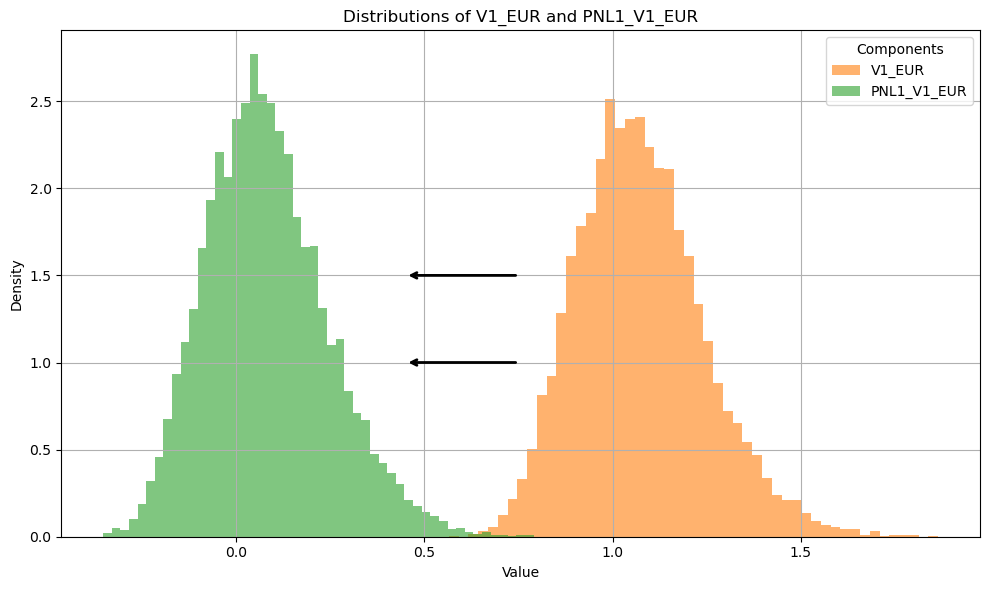

In [46]:

PnL_vars_1_single = [P_EUR_1[:, 2]]  # V1_US_EUR
labels_1_single = ["V1_EUR"]

PnL_vars_2_single = [PNL1_VUS]  # PNL1_VUS
labels_2_single = ["PNL1_V1_EUR"]

color_map = {
    "V1_EUR": "#ff7f0e",  # Orange
    "PNL1_V1_EUR": "#2ca02c"
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot (V1_US_EUR)
for pnl, label in zip(PnL_vars_1_single, labels_1_single):
    ax.hist(pnl, bins=50, alpha=0.6, density=True, label=label, color=color_map[label])

# Plot (PNL1_VUS)
for pnl, label in zip(PnL_vars_2_single, labels_2_single):
    ax.hist(pnl, bins=50, alpha=0.6, density=True, label=label, color=color_map[label])

ax.legend(loc='upper right', title="Components")

ax.set_title("Distributions of V1_EUR and PNL1_V1_EUR")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.grid(True)

arrow_positions = [(0.45, 1.5), (0.45, 1)]   
text_positions = [(0.75, 1.5), (0.75, 1)]  
for (x_arrow, y_arrow), (x_text, y_text) in zip(arrow_positions, text_positions):
    ax.annotate(
        '',  
        xy=(x_arrow, y_arrow),          
        xytext=(x_text, y_text),         
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )
plt.tight_layout()
plt.savefig("PNL1_VUS_and_V1_US_EUR_comparison.png")
plt.show()


In [47]:
PnL_means = [np.mean(pnl) for pnl in PnL_vars]
print("Expected (means):", PnL_means)


Expected (means): [-0.0206601173981778, 0.08198599360626171, 0.07419134573538433, 0.032351375181257254, 0.018880747136756807]


In [48]:
PnL_vars

[array([ 0.02939766,  0.06942295,  0.02098098, ..., -0.05193427,
        -0.04565999, -0.0474842 ]),
 array([-0.03410743, -0.0146687 ,  0.18087721, ...,  0.22627952,
        -0.00885344,  0.07116894]),
 array([-0.04443192,  0.11717817,  0.23306264, ...,  0.2023594 ,
         0.11473591, -0.00147877]),
 array([-0.00573612,  0.00770964, -0.01460094, ...,  0.09413601,
         0.03702474,  0.08358457]),
 array([ 0.01982282,  0.06776517, -0.00949603, ...,  0.04110359,
        -0.011262  ,  0.04624978])]

In [49]:
PnL_matrix = np.array(PnL_vars).T  # Transpose

PnL_cov_matrix = np.cov(PnL_matrix, rowvar=False)
print("CovarianceMatrix:")
print(PnL_cov_matrix)


CovarianceMatrix:
[[ 5.24130698e-03 -3.85215533e-03 -2.66367231e-04 -4.01398646e-03
   5.87249870e-05]
 [-3.85215533e-03  2.60536214e-02  1.98550431e-02  2.43618805e-03
   5.61295410e-04]
 [-2.66367231e-04  1.98550431e-02  2.84326248e-02 -4.04594880e-04
   4.02083034e-04]
 [-4.01398646e-03  2.43618805e-03 -4.04594880e-04  3.68003177e-03
   3.53201367e-04]
 [ 5.87249870e-05  5.61295410e-04  4.02083034e-04  3.53201367e-04
   5.08970551e-04]]


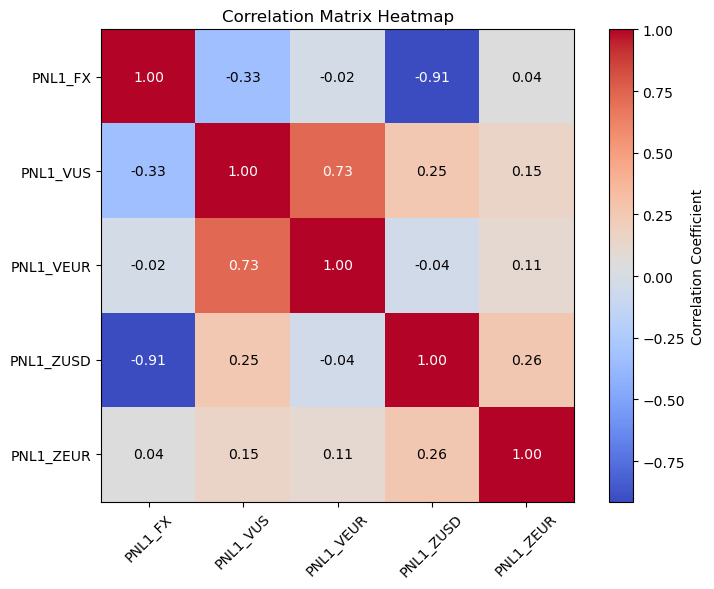

In [50]:
diag = np.sqrt(np.diag(PnL_cov_matrix))
outer_diag = np.outer(diag, diag)
correlation_matrix = PnL_cov_matrix / outer_diag
np.fill_diagonal(correlation_matrix, 1)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="none", aspect="equal")
plt.colorbar(label="Correlation Coefficient")
plt.title("Correlation Matrix Heatmap")
plt.xticks(ticks=np.arange(5), labels=["PNL1_FX", "PNL1_VUS", "PNL1_VEUR", "PNL1_ZUSD", "PNL1_ZEUR"], rotation=45)
plt.yticks(ticks=np.arange(5), labels=["PNL1_FX", "PNL1_VUS", "PNL1_VEUR", "PNL1_ZUSD", "PNL1_ZEUR"])

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix[i, j]:.2f}",
                 ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")

plt.tight_layout()
plt.show()

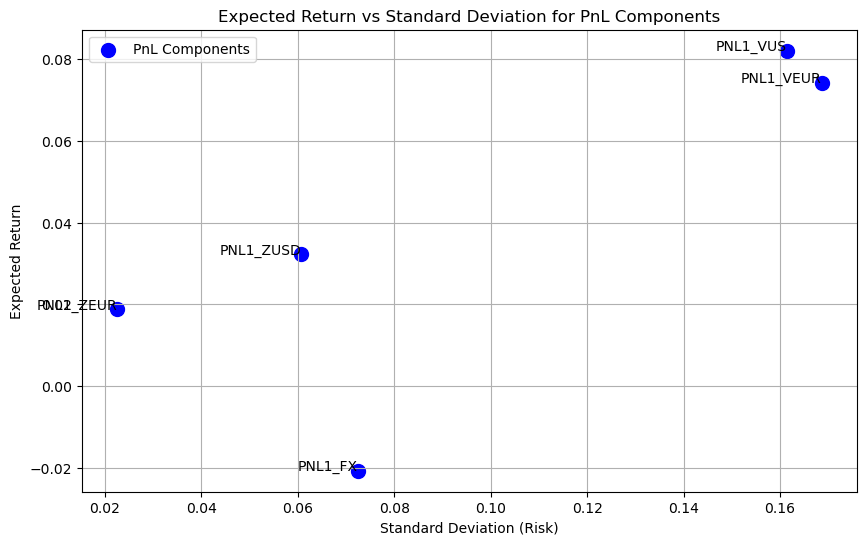

pnl expected return [-0.0206601173981778, 0.08198599360626171, 0.07419134573538433, 0.032351375181257254, 0.018880747136756807]
pnl std [0.07239687 0.16141134 0.16861976 0.06066327 0.02256038]


In [51]:
pnl_std_devs = np.sqrt(np.diag(PnL_cov_matrix))  
pnl_expected_returns = PnL_means 

plt.figure(figsize=(10, 6))
plt.scatter(pnl_std_devs, pnl_expected_returns, color="blue", label="PnL Components", s=100)

pnl_labels = ["PNL1_FX", "PNL1_VUS", "PNL1_VEUR", "PNL1_ZUSD", "PNL1_ZEUR"]
for std_dev, exp_return, label in zip(pnl_std_devs, pnl_expected_returns, pnl_labels):
    plt.text(std_dev, exp_return, label, fontsize=10, ha="right")

plt.title("Expected Return vs Standard Deviation for PnL Components")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()
plt.show()

print("pnl expected return", pnl_expected_returns)
print("pnl std",pnl_std_devs)

## Consider three different portfolios:

In [52]:
pd.DataFrame(PnL_cov_matrix)

0         1         2         3         4
0  0.005241 -0.003852 -0.000266 -0.004014  0.000059
1 -0.003852  0.026054  0.019855  0.002436  0.000561
2 -0.000266  0.019855  0.028433 -0.000405  0.000402
3 -0.004014  0.002436 -0.000405  0.003680  0.000353
4  0.000059  0.000561  0.000402  0.000353  0.000509

In [53]:
PnL_cov_matrix = np.cov(PnL_matrix, rowvar=False)
PnL_means = [np.mean(pnl) for pnl in PnL_vars]
portfolio_investment = [
    np.array([1, 0, 0, 0]),  
    np.array([0, 0, 1, 0]),  
    np.array([0.2, 0.2, 0.3, 0.3])  
]
prices = np.array([V0_US, V0_EUR,Z0_USD_Y_price_eur ,Z0_EUR_Y_price ])
portfolio_holdings = [investment / prices for investment in portfolio_investment]

for i, holding in enumerate(portfolio_holdings, 1):
    print(f"Portfolio {i} holdings: {holding}")
    

Portfolio 1 holdings: [1.05685 0.      0.      0.     ]
Portfolio 2 holdings: [0.         0.         1.27422191 0.        ]
Portfolio 3 holdings: [0.21137    0.2        0.38226657 0.33162971]


In [54]:
portfolio_1_holdings = portfolio_holdings[0]
portfolio_2_holdings = portfolio_holdings[1]
portfolio_3_holdings =portfolio_holdings[2]

#### Check to see if the PnL_cov_matrix is positive semidefinite

In [55]:
def is_positive_semidefinite(matrix):
    """
    Checks if a given matrix is positive semidefinite (PSD) using multiple methods.

    Parameters:
    - matrix (numpy.ndarray): Input matrix to check.

    Returns:
    - results (dict): Dictionary containing the results of each method.
    """
    results = {}

    # Method 1: Check eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    results["Eigenvalues"] = np.all(eigenvalues >= 0)
    print(f"Eigenvalues >= 0: {results['Eigenvalues']}")

    # Method 2: Cholesky decomposition (fails if not PSD)
    try:
        np.linalg.cholesky(matrix)
        results["Cholesky"] = True
    except np.linalg.LinAlgError:
        results["Cholesky"] = False
    print(f"Cholesky decomposition: {results['Cholesky']}")

    # Method 3: Principal minors
    results["Principal Minors"] = True
    for k in range(1, len(matrix) + 1):
        minor = matrix[:k, :k]
        if np.linalg.det(minor) < 0:
            results["Principal Minors"] = False
            break
    print(f"Principal minors non-negative: {results['Principal Minors']}")

    # Method 4: Symmetry check
    results["Symmetry"] = np.allclose(matrix, matrix.T)
    print(f"Symmetry: {results['Symmetry']}")

    # Final result: Matrix is PSD if all checks pass
    results["Is Positive Semidefinite"] = (
        results["Eigenvalues"]
        and results["Cholesky"]
        and results["Principal Minors"]
        and results["Symmetry"]
    )
    print(f"Is Positive Semidefinite: {results['Is Positive Semidefinite']}")

    return results

results = is_positive_semidefinite(PnL_cov_matrix)

Eigenvalues >= 0: True
Cholesky decomposition: True
Principal minors non-negative: True
Symmetry: True
Is Positive Semidefinite: True


## Define the hedge ratio as the amount USD hedged

In [56]:
def calculate_usd_exposure(portfolio_holdings, fx_linear):
    """
    Calculates USD exposure for a given portfolio of assets, considering only assets 1 and 4.

    Parameters:
    - portfolio_holdings (numpy.ndarray): Portfolio weight vector (length 4 or 5).
    - fx_linear (float): Exchange rate (or multiplier for USD exposure).

    Returns:
    - usd_exposure (float): Total USD exposure for the portfolio.
    """
    # If the vector length is 5, remove the first element
    if len(portfolio_holdings) == 5:
        portfolio_holdings = portfolio_holdings[1:]
    portfolio_holdings = portfolio_holdings*prices*fx_linear
    
    # Calculate USD exposure using only assets 1 and 4 and now the third element because forward is removed
    usd_exposure = portfolio_holdings[0] + portfolio_holdings[2]
    return usd_exposure


def calculate_hedge_percentage(h1, usd_exposure):
    """
    Calculates the hedge percentage based on the number of forward contracts (h1)
    and the USD exposure of the portfolio.

    Parameters:
    - h1 (float): The number of forward contracts.
    - usd_exposure (float): The total USD exposure of the portfolio.

    Returns:
    - hedge_percentage (float): The hedge percentage (value between 0 and 1, or 0% and 100%).
    """
    if usd_exposure == 0:
        raise ValueError("USD exposure cannot be zero for hedge percentage calculation.")
    
    # Calculate hedge percentage
    hedge_percentage = h1 / usd_exposure
    return hedge_percentage

def calculate_min_var_hedge_ratio_with_holdings(cov_mat, portfolio_holdings123):
    sigma_12 = cov_mat[0, 1:] 
    sigma_11 = cov_mat[0, 0]   
    
    h1_portfolio = -np.dot(sigma_12, portfolio_holdings123) / sigma_11
    return h1_portfolio

    

def calculate_h1_from_hedge_percentage(hedge_percentage, portfolio_holdings):
    """
    Calculates the number of forward contracts (h1) needed based on a given hedge percentage 
    and the portfolio's USD exposure.

    Parameters:
    - hedge_percentage (float): The desired hedge percentage (value between 0 and 1).
    - portfolio_holdings (numpy.ndarray): Portfolio weight vector (length 4 or 5).
    - fx_linear (float): Exchange rate (or multiplier for USD exposure).

    Returns:
    - h1 (float): The number of forward contracts needed to achieve the hedge percentage.
    """
    # Calculate USD exposure
    usd_exposure = calculate_usd_exposure(portfolio_holdings, fx_linear)
    
    # Check if USD exposure is zero
    if usd_exposure == 0:
        raise ValueError("USD exposure cannot be zero when calculating h1.")
    
    # Calculate h1 based on the hedge percentage
    h1 = hedge_percentage * usd_exposure
    return h1


In [57]:
h1_for_hedge_percentage = [
    calculate_h1_from_hedge_percentage(1.5, portfolio_1_holdings),
    calculate_h1_from_hedge_percentage(-1, portfolio_1_holdings),
    calculate_h1_from_hedge_percentage(1.5, portfolio_2_holdings),
    calculate_h1_from_hedge_percentage(-1, portfolio_2_holdings),
    calculate_h1_from_hedge_percentage(1.5, portfolio_3_holdings),
    calculate_h1_from_hedge_percentage(-1, portfolio_3_holdings),
]

In [58]:
h1_for_hedge_percentage

[1.5852750000000002,
 -1.05685,
 1.5852749999999998,
 -1.0568499999999998,
 0.7926375000000001,
 -0.528425]

In [59]:
print("Portefolio 1 holdings", portfolio_1_holdings)
print("Portefolio 2 holdings", portfolio_2_holdings)
print("Portefolio 3 holdings", portfolio_3_holdings)

Portefolio 1 holdings [1.05685 0.      0.      0.     ]
Portefolio 2 holdings [0.         0.         1.27422191 0.        ]
Portefolio 3 holdings [0.21137    0.2        0.38226657 0.33162971]


In [60]:
PnL_cov_matrix = np.cov(PnL_matrix, rowvar=False)
optimal_hedge_porfolio1_h1= calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_1_holdings)
optimal_hedge_porfolio2_h1= calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_2_holdings)
optimal_hedge_porfolio3_h1= calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_3_holdings)
usd_exposure_1 = calculate_usd_exposure(portfolio_1_holdings, fx_linear)
usd_exposure_2 = calculate_usd_exposure(portfolio_2_holdings, fx_linear)
usd_exposure_3 = calculate_usd_exposure(portfolio_3_holdings, fx_linear)
hedge_percentage_1 = calculate_hedge_percentage(optimal_hedge_porfolio1_h1, usd_exposure_1)
hedge_percentage_2 = calculate_hedge_percentage(optimal_hedge_porfolio2_h1, usd_exposure_2)
hedge_percentage_3 = calculate_hedge_percentage(optimal_hedge_porfolio3_h1, usd_exposure_3)



In [61]:

optimal_hedge_porfolio1_h1 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_1_holdings)
print(f"Optimal hedge number of contracts (h1) for Portfolio 1: {optimal_hedge_porfolio1_h1}")

optimal_hedge_porfolio2_h1 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_2_holdings)
print(f"Optimal hedge number of contracts (h1) for Portfolio 2: {optimal_hedge_porfolio2_h1}")

optimal_hedge_porfolio3_h1 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=PnL_cov_matrix, portfolio_holdings123=portfolio_3_holdings)
print(f"Optimal hedge number of contracts(h1) for Portfolio 3: {optimal_hedge_porfolio3_h1}")

usd_exposure_1 = calculate_usd_exposure(portfolio_1_holdings, fx_linear)
print(f"USD exposure for Portfolio 1: {usd_exposure_1}")

usd_exposure_2 = calculate_usd_exposure(portfolio_2_holdings, fx_linear)
print(f"USD exposure for Portfolio 2: {usd_exposure_2}")

usd_exposure_3 = calculate_usd_exposure(portfolio_3_holdings, fx_linear)
print(f"USD exposure for Portfolio 3: {usd_exposure_3}")

hedge_percentage_1 = calculate_hedge_percentage(optimal_hedge_porfolio1_h1, usd_exposure_1)
print(f"Hedge percentage for Portfolio 1: {hedge_percentage_1}")

hedge_percentage_2 = calculate_hedge_percentage(optimal_hedge_porfolio2_h1, usd_exposure_2)
print(f"Hedge percentage for Portfolio 2: {hedge_percentage_2:.2f}%")

hedge_percentage_3 = calculate_hedge_percentage(optimal_hedge_porfolio3_h1, usd_exposure_3)
print(f"Hedge percentage for Portfolio 3: {hedge_percentage_3:.2f}%")


Optimal hedge number of contracts (h1) for Portfolio 1: 0.7767433544568584
Optimal hedge number of contracts (h1) for Portfolio 2: 0.9758461951174797
Optimal hedge number of contracts(h1) for Portfolio 3: 0.4545510156535004
USD exposure for Portfolio 1: 1.05685
USD exposure for Portfolio 2: 1.0568499999999998
USD exposure for Portfolio 3: 0.528425
Hedge percentage for Portfolio 1: 0.7349608312029695
Hedge percentage for Portfolio 2: 0.92%
Hedge percentage for Portfolio 3: 0.86%


In [62]:
portfolio_1_with_optimal_number_of_forwards = np.append(optimal_hedge_porfolio1_h1, portfolio_1_holdings)
portfolio_2_with_optimal_number_of_forwards = np.append(optimal_hedge_porfolio2_h1, portfolio_2_holdings)
portfolio_3_with_optimal_number_of_forwards = np.append(optimal_hedge_porfolio3_h1, portfolio_3_holdings)
print(portfolio_1_with_optimal_number_of_forwards)
print(portfolio_2_with_optimal_number_of_forwards)
print(portfolio_3_with_optimal_number_of_forwards)

[0.77674335 1.05685    0.         0.         0.        ]
[0.9758462  0.         0.         1.27422191 0.        ]
[0.45455102 0.21137    0.2        0.38226657 0.33162971]


### Calculate and plot minimum variance for number of forward contracts from -1 to 1.5

In [63]:
def calculate_and_plot_min_variance_points(PnL_matrix, h2_list, h1_values, h2_labels=None):
    """
    Calculates and plots portfolio expected return against standard deviation (risk) as h1 changes,
    marking the point with the lowest variance for each portfolio.

    Parameters:
    - PnL_matrix (numpy.ndarray): A matrix of PnL simulations (rows = scenarios, columns = portfolio components).
    - h2_list (list of numpy.ndarray): A list of weight vectors for different portfolios (excluding h1).
    - h1_values (numpy.ndarray): Test values for h1 (hedging component).
    - h2_labels (list of str, optional): Descriptions of each portfolio for the plot legend.

    Returns:
    - min_variance_points (list of tuples): A list of (mean return, std deviation, h1 value) for the minimum variance point of each portfolio.
    """

    min_variance_points = []

    if h2_labels is None:
        h2_labels = [f"Portfolio {i+1}" for i in range(len(h2_list))]

    plt.figure(figsize=(12, 8))

    for i, h2 in enumerate(h2_list):
        portfolio_means = []
        portfolio_std_devs = []

        for h1_test in h1_values:
            # Combine h1 and h2 to create portfolio weights
            weights = np.concatenate(([h1_test], h2))
            
            # Calculate total portfolio PnL using matrix multiplication
            portfolio_pnl = np.dot(PnL_matrix, weights)
            
            # Calculate mean return and standard deviation
            mean_return = np.mean(portfolio_pnl)
            std_dev = np.std(portfolio_pnl)

            portfolio_means.append(mean_return)
            portfolio_std_devs.append(std_dev)

        # Find the minimum variance point
        min_std_dev = min(portfolio_std_devs)
        min_index = portfolio_std_devs.index(min_std_dev)
        min_mean_return = portfolio_means[min_index]
        min_h1 = h1_values[min_index]

        min_variance_points.append((min_mean_return, min_std_dev, min_h1))

        line, = plt.plot(portfolio_std_devs, portfolio_means, label=h2_labels[i], linewidth=2)

        line_color = line.get_color()

        plt.scatter(min_std_dev, min_mean_return, color=line_color, zorder=5, label=f"{h2_labels[i]} Min Variance")
        plt.text(
            min_std_dev,
            min_mean_return,
            f"h1 = {min_h1:.2f}\nσ = {min_std_dev:.2f}\nReturn = {min_mean_return:.5f}",
            fontsize=10,
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=line_color)
        )

    plt.title("Expected Return vs Risk (σ) with Minimum Variance Points", fontsize=14)
    plt.xlabel("Standard Deviation (Risk)", fontsize=12)
    plt.ylabel("Expected Return", fontsize=12)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()
    plt.savefig("Expected Return vs Risk (σ) with Minimum Variance Points")
    return min_variance_points

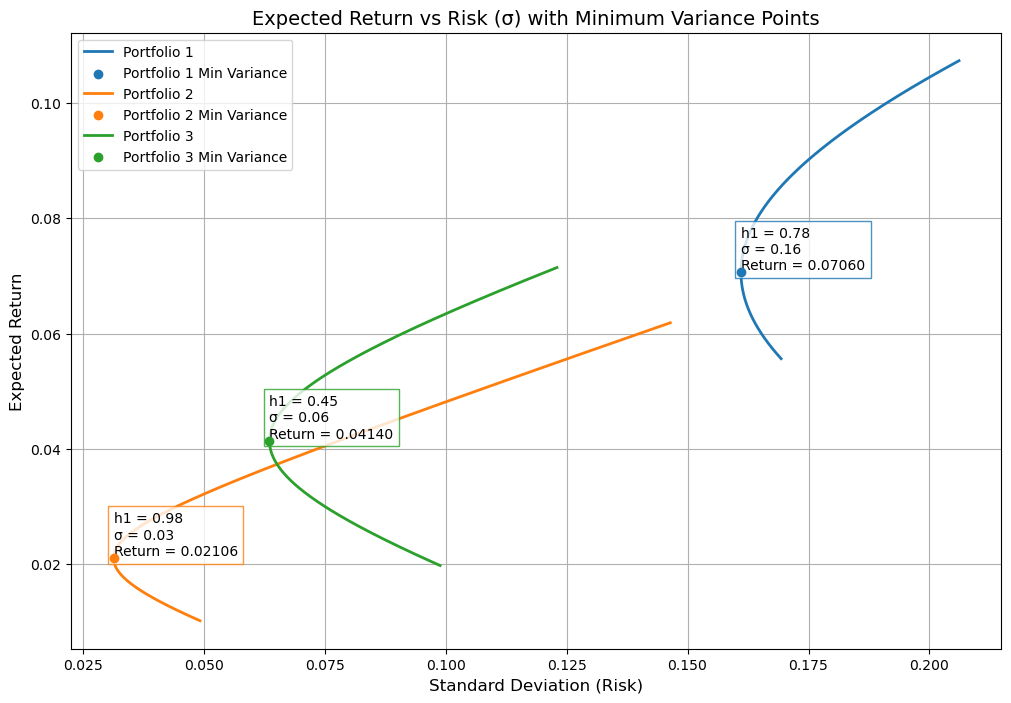

<Figure size 640x480 with 0 Axes>

In [64]:
h2_labels = ["Portfolio 1", "Portfolio 2", "Portfolio 3"]
h1_values = np.linspace(-1, 1.5, 10000)
portfolio_metrics_list = calculate_and_plot_min_variance_points(
    PnL_matrix=PnL_matrix,
    h2_list=portfolio_holdings,
    h1_values=h1_values,
    h2_labels=h2_labels
)


## calculate_and_plot_min_variance_points_with_hedge_percentage

In [65]:
def calculate_and_plot_min_variance_points_with_hedge_percentage(
    PnL_matrix, h2_list, h1_ranges, h2_labels=None):
    """
    Calculates and plots portfolio expected return against standard deviation (risk) as h1 changes,
    marking the point with the lowest variance for each portfolio and showing the hedge percentage in the boxes.

    Parameters:
    - PnL_matrix (numpy.ndarray): A matrix of PnL simulations (rows = scenarios, columns = portfolio components).
    - h2_list (list of numpy.ndarray): A list of weight vectors for different portfolios (excluding h1).
    - h1_ranges (list of tuple): A list of (start, end) ranges for h1 values, one for each portfolio.
    - h2_labels (list of str, optional): Descriptions of each portfolio for the plot legend.

    Returns:
    - min_variance_points (list of tuples): A list of (mean return, std deviation, hedge percentage) for the minimum variance point of each portfolio.
    """
    portfolio_holdings = h2_list
    min_variance_points = []

    if h2_labels is None:
        h2_labels = [f"Portfolio {i+1}" for i in range(len(h2_list))]

    plt.figure(figsize=(12, 10))

    for i, (h2, h1_range, holdings) in enumerate(zip(h2_list, h1_ranges, portfolio_holdings)):
        portfolio_means = []
        portfolio_std_devs = []
        hedge_percentages = []

        usd_exposure = calculate_usd_exposure(holdings, fx_linear)

        h1_values = np.linspace(h1_range[0], h1_range[1], 10000)

        for h1_test in h1_values:
            # Combine h1 and h2 to create portfolio weights
            weights = np.concatenate(([h1_test], h2))
            
            # Calculate total portfolio PnL using matrix multiplication
            portfolio_pnl = np.dot(PnL_matrix, weights)
            
            # Calculate mean return and standard deviation
            mean_return = np.mean(portfolio_pnl)
            std_dev = np.std(portfolio_pnl)

            # Calculate hedge percentage
            hedge_percentage = calculate_hedge_percentage(h1_test, usd_exposure)

            portfolio_means.append(mean_return)
            portfolio_std_devs.append(std_dev)
            hedge_percentages.append(hedge_percentage)

        min_std_dev = min(portfolio_std_devs)
        min_index = portfolio_std_devs.index(min_std_dev)
        min_mean_return = portfolio_means[min_index]
        min_hedge_percentage = hedge_percentages[min_index]

        min_variance_points.append((min_mean_return, min_std_dev, min_hedge_percentage))

        line, = plt.plot(portfolio_std_devs, portfolio_means, label=h2_labels[i], linewidth=2)

        # Get the color of the current line
        line_color = line.get_color()

        # Mark the minimum variance point
        plt.scatter(min_std_dev, min_mean_return, color=line_color, zorder=5, label=f"{h2_labels[i]} Min Variance")
        plt.text(
            min_std_dev,
            min_mean_return,
            f"Hedge % = {min_hedge_percentage:.2%}\nσ = {min_std_dev:.2%}\nReturn = {min_mean_return:.2%}",
            fontsize=10,
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=line_color)
        )

        # Add points for boundary h1 values
        for h1_fixed in h1_range:
            weights_fixed = np.concatenate(([h1_fixed], h2))
            portfolio_pnl_fixed = np.dot(PnL_matrix, weights_fixed)
            mean_fixed = np.mean(portfolio_pnl_fixed)
            std_fixed = np.std(portfolio_pnl_fixed)

            hedge_percentage_fixed = calculate_hedge_percentage(h1_fixed, usd_exposure)

            point_label = "max" if h1_fixed == h1_range[0] else "min"
            marker_shape = "^" if h1_fixed == h1_range[0] else "s" 
            
            plt.scatter(std_fixed, mean_fixed, color=line_color, marker=marker_shape, zorder=5, label=f"{h2_labels[i]} Hedge {point_label}")
            plt.text(
                std_fixed,
                mean_fixed,
                f"Hedge % = {hedge_percentage_fixed:.2%}\nσ = {std_fixed:.2%}\nReturn = {mean_fixed:.2%}",
                fontsize=7,
                ha="right" if h1_fixed == h1_range[0] else "left",
                va="bottom",
                bbox=dict(facecolor="white", alpha=0.8, edgecolor=line_color)
            )


    plt.title("Expected Return vs Risk (σ) with Minimum Variance and Hedge Percentages", fontsize=14)
    plt.xlabel("Standard Deviation (Risk)", fontsize=12)
    plt.ylabel("Expected Return", fontsize=12)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2%}"))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2%}"))
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig("Expected Return vs Risk (σ) with Minimum Variance and Hedge Percentages")
    plt.show()
    return min_variance_points


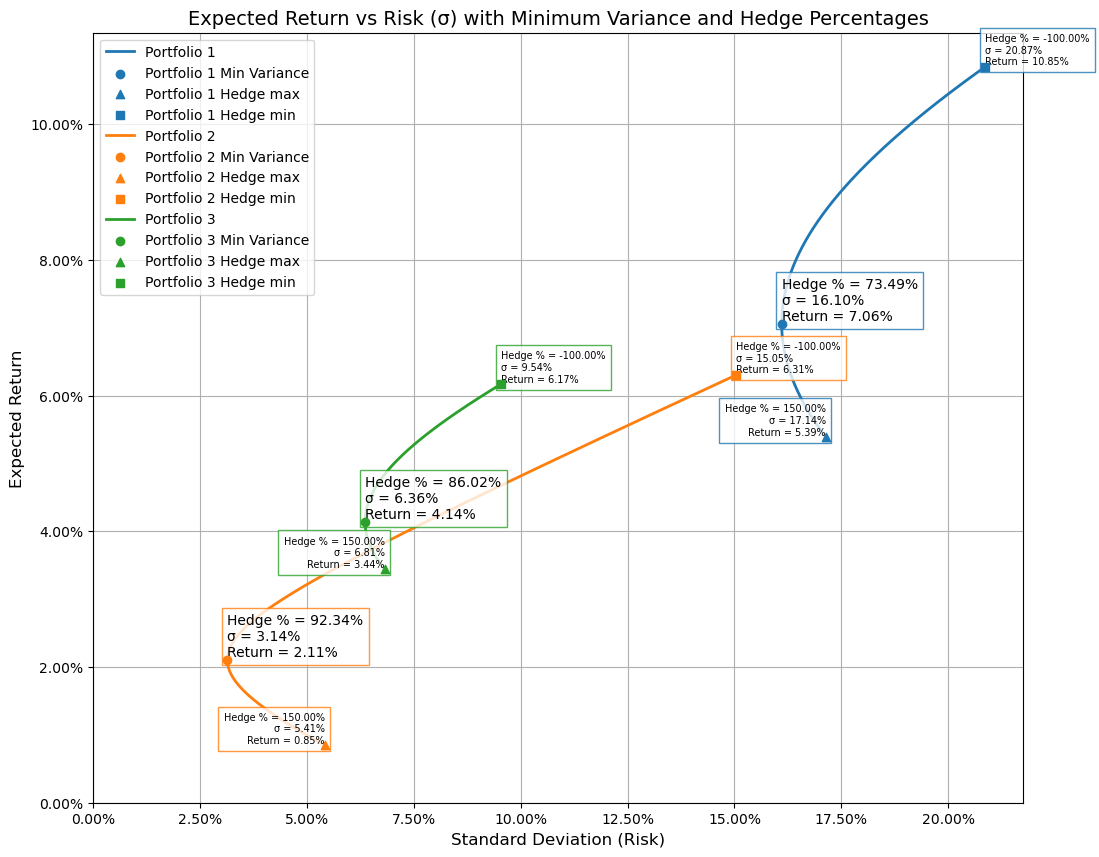

Portfolio 1:
  Mean Return = 7.06%
  Standard Deviation (Risk) = 16.10%
  Minimum Variance Hedge Percentage = 73.49%
Portfolio 2:
  Mean Return = 2.11%
  Standard Deviation (Risk) = 3.14%
  Minimum Variance Hedge Percentage = 92.34%
Portfolio 3:
  Mean Return = 4.14%
  Standard Deviation (Risk) = 6.36%
  Minimum Variance Hedge Percentage = 86.02%

Minimum Variance Hedge Percentage for Portfolio 3:
86.02%
Last Minimum Variance Hedge Percentage: 86.02%


In [66]:
h2_labels = ["Portfolio 1", "Portfolio 2", "Portfolio 3"]
h1_ranges = [
    (h1_for_hedge_percentage[0], h1_for_hedge_percentage[1]),  
    (h1_for_hedge_percentage[2], h1_for_hedge_percentage[3]),  
    (h1_for_hedge_percentage[4], h1_for_hedge_percentage[5])  
]
portfolio_metrics_list = calculate_and_plot_min_variance_points_with_hedge_percentage(
    PnL_matrix=PnL_matrix,
    h2_list=portfolio_holdings,
    h1_ranges=h1_ranges,
    h2_labels=h2_labels
)

min_variance_hedge_percentages = {}

for label, (mean_return, std_dev, hedge_percentage) in zip(h2_labels, portfolio_metrics_list):
    min_variance_hedge_percentages[label] = hedge_percentage
    print(f"{label}:")
    print(f"  Mean Return = {mean_return:.2%}")
    print(f"  Standard Deviation (Risk) = {std_dev:.2%}")
    print(f"  Minimum Variance Hedge Percentage = {hedge_percentage:.2%}")

print("\nMinimum Variance Hedge Percentage for Portfolio 3:")
print(f"{min_variance_hedge_percentages['Portfolio 3']:.2%}")

last_hedge_percentage = list(min_variance_hedge_percentages.values())[-1]

print(f"Last Minimum Variance Hedge Percentage: {last_hedge_percentage:.2%}")


### Plot the portfolio CVAR for the mixed portfolio

In [67]:
def calculate_and_plot_min_cvar_with_hedge_ratio(
    PnL_matrix, portfolio_holdings, h1_values, alpha=0.05):
    """
    Calculates and plots portfolio expected return against CVaR (risk) for a single portfolio,
    marking points with the hedge ratio instead of h1.

    Parameters:
    - PnL_matrix (numpy.ndarray): A matrix of PnL simulations (rows = scenarios, columns = portfolio components).
    - portfolio_holdings (numpy.ndarray): The weight vector for the portfolio (excluding h1).
    - h1_values (numpy.ndarray): Test values for h1 (hedging component).
    - alpha (float): Confidence level for CVaR calculation (default is 0.05).
    - fx_linear (function, optional): A function to calculate the FX exposure if required.

    Returns:
    - points (dict): A dictionary of calculated points for plotting.
    """

    def calculate_cvar(pnl, alpha):
        """
        Calculate the CVaR for a given PnL distribution and confidence level.
        """
        var = np.percentile(pnl, alpha * 100)  # Value-at-Risk (VaR)
        cvar = pnl[pnl <= var].mean()  # Conditional Value-at-Risk (CVaR)
        return cvar

    def calculate_hedge_ratio(h1, usd_exposure):
        """
        Calculate the hedge ratio based on h1 and USD exposure.
        """
        return h1 / usd_exposure if usd_exposure != 0 else 0

    usd_exposure = calculate_usd_exposure(portfolio_holdings, fx_linear)

    portfolio_means = []
    portfolio_cvars = []
    hedge_ratios = []

    for h1_test in h1_values:
        weights = np.concatenate(([h1_test], portfolio_holdings))
        
        # Calculate total portfolio PnL using matrix multiplication
        portfolio_pnl = np.dot(PnL_matrix, weights)
        
        # Calculate mean return and CVaR
        mean_return = np.mean(portfolio_pnl)
        cvar = calculate_cvar(portfolio_pnl, alpha)

        # Calculate hedge ratio
        hedge_ratio = calculate_hedge_ratio(h1_test, usd_exposure)

        portfolio_means.append(mean_return)
        portfolio_cvars.append(cvar)
        hedge_ratios.append(hedge_ratio)

    portfolio_means = np.array(portfolio_means)
    portfolio_cvars = np.array(portfolio_cvars)
    hedge_ratios = np.array(hedge_ratios)

    max_cvar_index = np.argmax(portfolio_cvars)
    max_hedge_index = np.argmax(hedge_ratios)
    min_hedge_index = np.argmin(hedge_ratios)

    optimal_cvar_hedge_ratio = hedge_ratios[max_cvar_index]

    points = {
        "max_cvar_point": (portfolio_means[max_cvar_index], portfolio_cvars[max_cvar_index], hedge_ratios[max_cvar_index]),
        "max_hedge_point": (portfolio_means[max_hedge_index], portfolio_cvars[max_hedge_index], hedge_ratios[max_hedge_index]),
        "min_hedge_point": (portfolio_means[min_hedge_index], portfolio_cvars[min_hedge_index], hedge_ratios[min_hedge_index]),
    }

    # Plot expected return vs CVaR
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_cvars, portfolio_means, label="Portfolio with Hedge Ratio", linewidth=2)

    # Mark the points on the plot
    for label, color, marker, key in zip(
        ["Max CVaR", "Max Hedge", "Min Hedge"], 
        ["blue", "green", "red"], 
        ["o", "s", "^"], 
        ["max_cvar_point", "max_hedge_point", "min_hedge_point"]
    ):
        point = points[key]
        plt.scatter(point[1], point[0], color=color, marker=marker, zorder=5, label=f"{label} Point")
        plt.text(
            point[1],
            point[0],
            f"{label}:\nHedge Ratio = {point[2]:.2%}\nCVaR = {point[1]:.4%}\nReturn = {point[0]:.4%}",
            fontsize=10,
            ha="left",
            va="top",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=color)
        )

    plt.title("Expected Return vs Risk (CVaR) with Hedge Ratios for multi-asset portfolio", fontsize=14)
    plt.xlabel("Conditional Value at Risk (CVaR)", fontsize=12)
    plt.ylabel("Expected Return", fontsize=12)

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

    plt.xlim(right=0)
    plt.ylim(bottom=0)

    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig("Expected Return vs Risk (CVaR) for Multi-asset portfolio")
    plt.show()

    return points, optimal_cvar_hedge_ratio


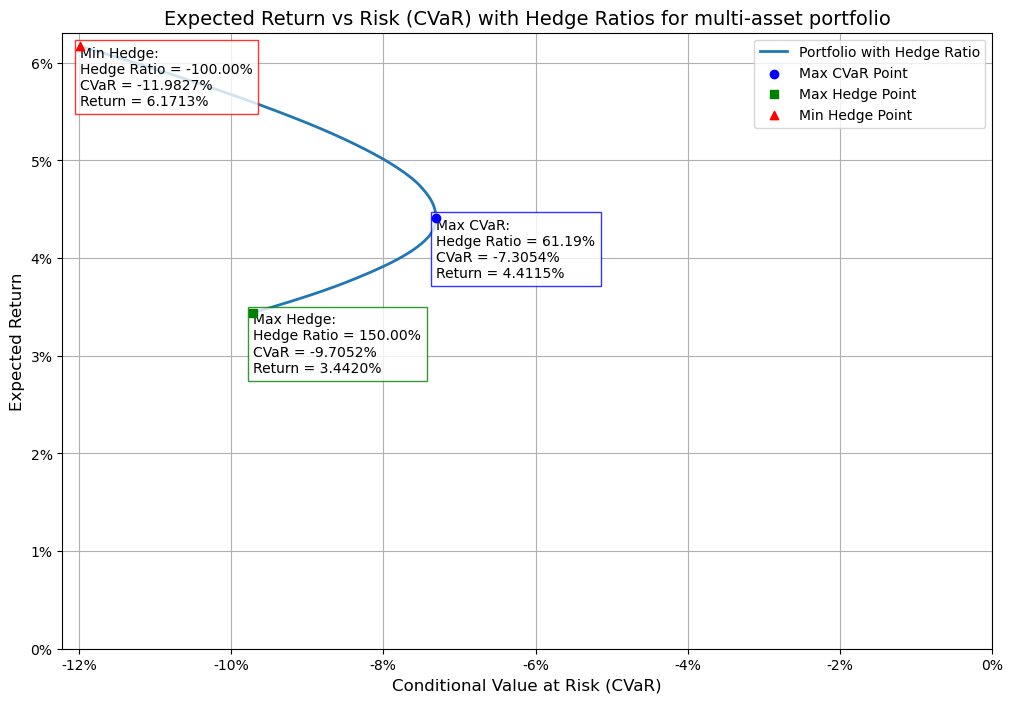

Optimal CVaR Hedge Ratio: 0.611911191119112


In [68]:
last_two_h1_values_range = np.linspace(h1_for_hedge_percentage[-2], h1_for_hedge_percentage[-1], 10000)

calculate_and_plot_min_cvar_points, optimal_cvar_hedge_ratio = calculate_and_plot_min_cvar_with_hedge_ratio(
    PnL_matrix=PnL_matrix,
    portfolio_holdings=portfolio_3_holdings,
    h1_values=last_two_h1_values_range,
)

print("Optimal CVaR Hedge Ratio:", optimal_cvar_hedge_ratio)


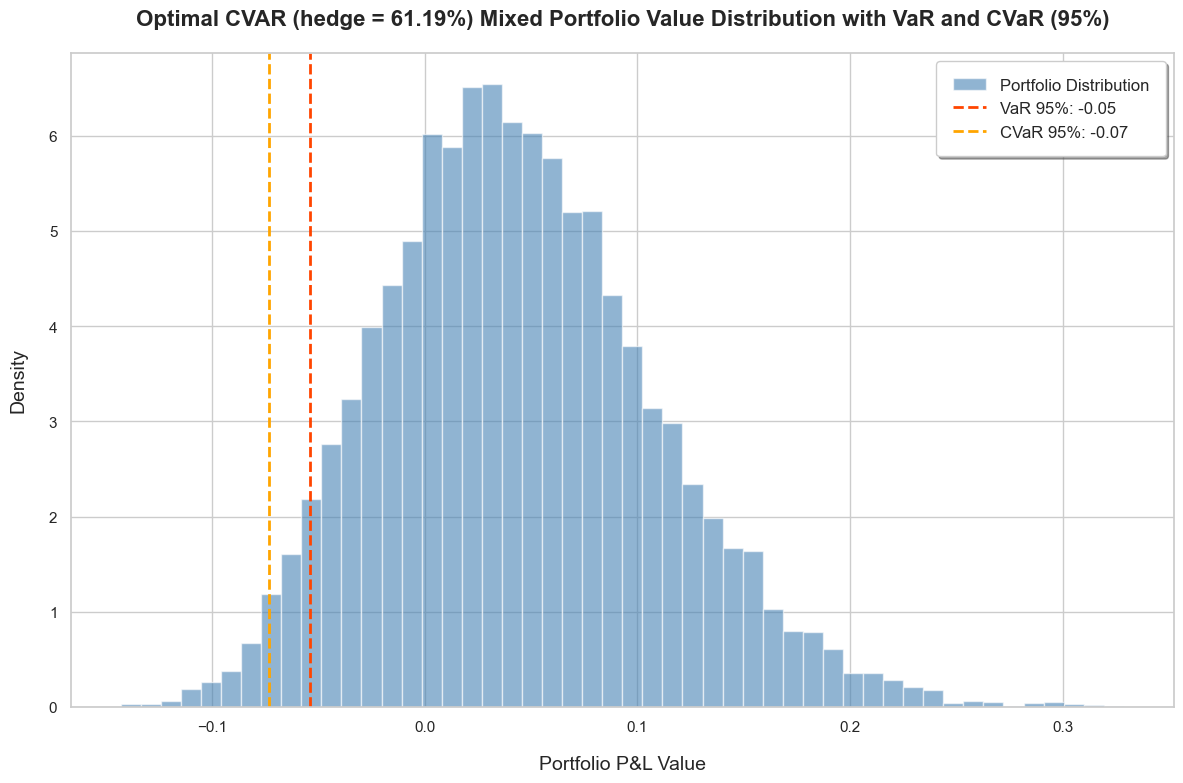

In [69]:
CVAR_Optimal_port3 = np.append([calculate_h1_from_hedge_percentage(optimal_cvar_hedge_ratio, portfolio_3_holdings)], portfolio_3_holdings)
CVAR_Optimal_port3

portfolio_values = np.dot(PnL_matrix, CVAR_Optimal_port3)

# Calculate Value at Risk (VaR) 95%
VaR_95 = np.percentile(portfolio_values, 5)  # 5% quantile for 95% VaR

# Calculate Conditional Value at Risk (CVaR) 95%
CVaR_95 = portfolio_values[portfolio_values <= VaR_95].mean()  # Average loss below VaR

# Set the style for a professional look
sns.set_theme(style="whitegrid")  # Elegant theme

# Plot the histogram with improved styling
plt.figure(figsize=(12, 8))
plt.hist(portfolio_values, bins=50, density=True, alpha=0.6, color='#4682B4', label='Portfolio Distribution')

# Highlight VaR
plt.axvline(x=VaR_95, color='#FF4500', linestyle='--', linewidth=2, label=f'VaR 95%: {VaR_95:.2f}')

# Highlight CVaR
plt.axvline(x=CVaR_95, color='#FFA500', linestyle='--', linewidth=2, label=f'CVaR 95%: {CVaR_95:.2f}')

# Title and axis labels with larger font size
plt.title(f"Optimal CVAR (hedge = {optimal_cvar_hedge_ratio:.2%}) Mixed Portfolio Value Distribution with VaR and CVaR (95%)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Portfolio P&L Value", fontsize=14, labelpad=15)
plt.ylabel("Density", fontsize=14, labelpad=15)

plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True, borderpad=1)


plt.tight_layout()
plt.savefig("Mixed Portfolio Value Distribution with VaR and CVaR.png")
# Show the plot
plt.show()


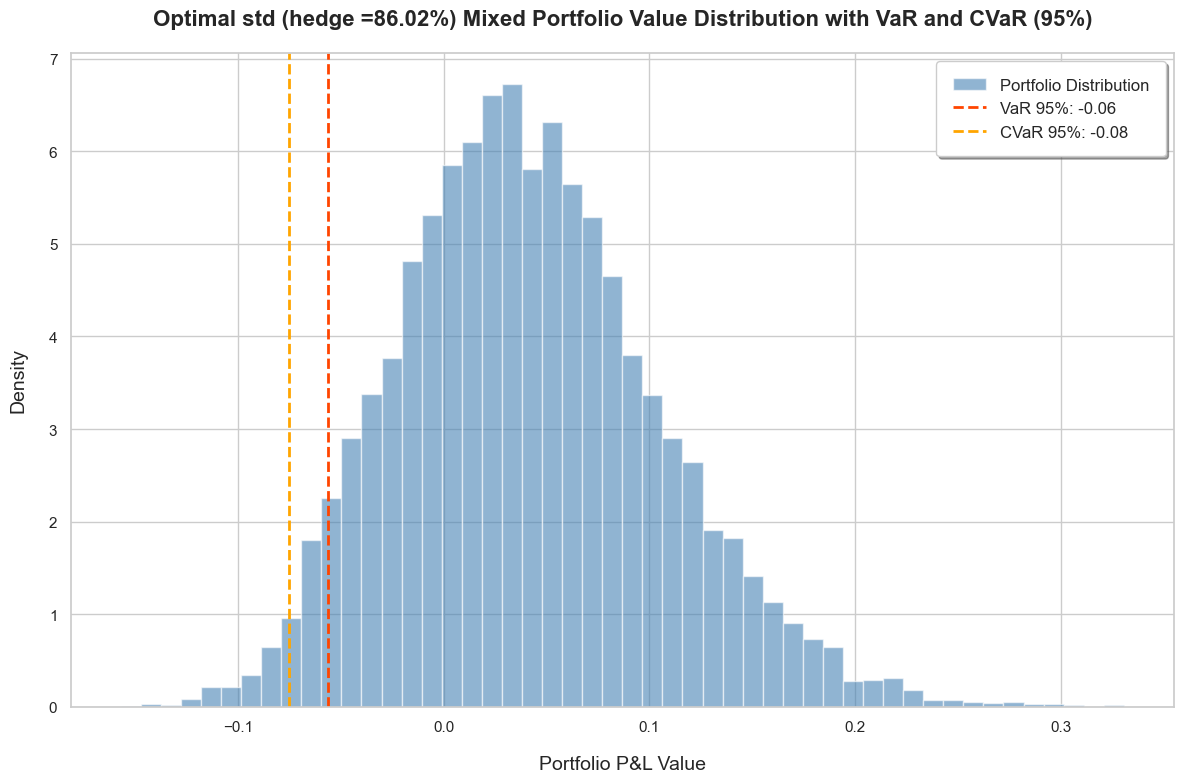

In [70]:
std_Optimal_port3 = np.append(calculate_h1_from_hedge_percentage(last_hedge_percentage, portfolio_3_holdings), portfolio_3_holdings)

portfolio_values = np.dot(PnL_matrix, std_Optimal_port3)

# Calculate Value at Risk (VaR) 95%
VaR_95 = np.percentile(portfolio_values, 5)  # 5% quantile for 95% VaR

# Calculate Conditional Value at Risk (CVaR) 95%
CVaR_95 = portfolio_values[portfolio_values <= VaR_95].mean()  # Average loss below VaR

sns.set_theme(style="whitegrid") 

plt.figure(figsize=(12, 8))
plt.hist(portfolio_values, bins=50, density=True, alpha=0.6, color='#4682B4', label='Portfolio Distribution')

# Highlight VaR
plt.axvline(x=VaR_95, color='#FF4500', linestyle='--', linewidth=2, label=f'VaR 95%: {VaR_95:.2f}')

# Highlight CVaR
plt.axvline(x=CVaR_95, color='#FFA500', linestyle='--', linewidth=2, label=f'CVaR 95%: {CVaR_95:.2f}')

plt.title("Optimal std (hedge =86.02%) Mixed Portfolio Value Distribution with VaR and CVaR (95%)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Portfolio P&L Value", fontsize=14, labelpad=15)
plt.ylabel("Density", fontsize=14, labelpad=15)

plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.savefig("Optimal std hedge Mixed Portfolio Value Distribution with VaR and CVaR.png")
plt.show()


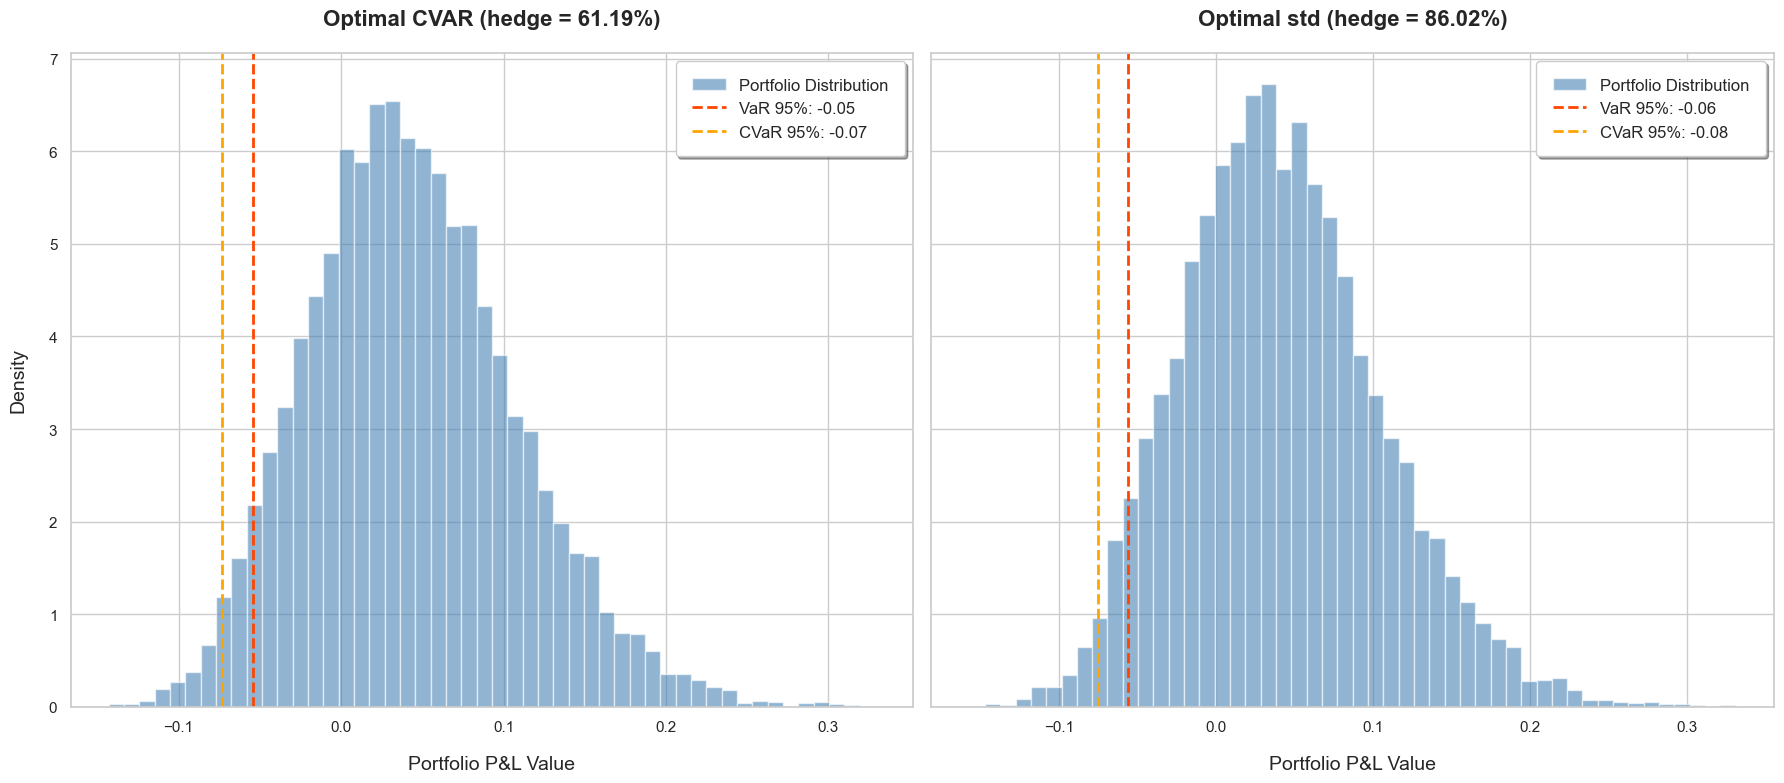

In [71]:
# Calculate values for the first hedge (61.19%)
CVAR_Optimal_port3 = np.append([calculate_h1_from_hedge_percentage(optimal_cvar_hedge_ratio, portfolio_3_holdings)], portfolio_3_holdings)
portfolio_values_1 = np.dot(PnL_matrix, CVAR_Optimal_port3)
VaR_95_1 = np.percentile(portfolio_values_1, 5)
CVaR_95_1 = portfolio_values_1[portfolio_values_1 <= VaR_95_1].mean()

# Calculate values for the second hedge (86.02%)
CVAR_Optimal_port3_2 = np.append([calculate_h1_from_hedge_percentage(last_hedge_percentage, portfolio_3_holdings)], portfolio_3_holdings)
portfolio_values_2 = np.dot(PnL_matrix, CVAR_Optimal_port3_2)
VaR_95_2 = np.percentile(portfolio_values_2, 5)
CVaR_95_2 = portfolio_values_2[portfolio_values_2 <= VaR_95_2].mean()

# Set up the plot
sns.set_theme(style="whitegrid") 
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Plot for the first hedge (61.19%)
axes[0].hist(portfolio_values_1, bins=50, density=True, alpha=0.6, color='#4682B4', label='Portfolio Distribution')
axes[0].axvline(x=VaR_95_1, color='#FF4500', linestyle='--', linewidth=2, label=f'VaR 95%: {VaR_95_1:.2f}')
axes[0].axvline(x=CVaR_95_1, color='#FFA500', linestyle='--', linewidth=2, label=f'CVaR 95%: {CVaR_95_1:.2f}')
axes[0].set_title(f"Optimal CVAR (hedge = {optimal_cvar_hedge_ratio:.2%})", fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel("Portfolio P&L Value", fontsize=14, labelpad=15)
axes[0].set_ylabel("Density", fontsize=14, labelpad=15)
axes[0].legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True, borderpad=1)

# Plot for the second hedge (86.02%)
axes[1].hist(portfolio_values_2, bins=50, density=True, alpha=0.6, color='#4682B4', label='Portfolio Distribution')
axes[1].axvline(x=VaR_95_2, color='#FF4500', linestyle='--', linewidth=2, label=f'VaR 95%: {VaR_95_2:.2f}')
axes[1].axvline(x=CVaR_95_2, color='#FFA500', linestyle='--', linewidth=2, label=f'CVaR 95%: {CVaR_95_2:.2f}')
axes[1].set_title(f"Optimal std (hedge = {last_hedge_percentage:.2%})", fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel("Portfolio P&L Value", fontsize=14, labelpad=15)
axes[1].legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.savefig("Side_by_Side_Mixed_Portfolio_Value_Distributions.png")
plt.show()


### Appendix (Calculate and plot multiple portfolio returns from different hedges)

In [72]:
def calculate_and_plot_multiple_portfolio_returns(PnL_matrix, h2_list, h1_values, h2_labels=None):
    """
    Calculates and plots the portfolio return as a function of h1 for multiple portfolios.

    Parameters:
    - PnL_matrix (numpy.ndarray): A matrix of PnL simulations (rows = scenarios, columns = portfolio components).
    - h2_list (list of numpy.ndarray): A list of weight vectors for different portfolios (excluding h1).
    - h1_values (numpy.ndarray): Test values for h1 (hedging component).
    - h2_labels (list of str, optional): Descriptions of each portfolio for the plot legend.

    Returns:
    - portfolio_returns_list (list of lists): A list of calculated returns for each portfolio and h1 value.
    """

    portfolio_returns_list = []

    if h2_labels is None:
        h2_labels = [f"Portfolio {i+1}" for i in range(len(h2_list))]

    plt.figure(figsize=(12, 8))

    for i, h2 in enumerate(h2_list):
        portfolio_returns = []

        for h1_test in h1_values:
            weights = np.concatenate(([h1_test], h2))
            
            portfolio_pnl = np.dot(PnL_matrix, weights)
            
            portfolio_return = np.mean(portfolio_pnl)
            portfolio_returns.append(portfolio_return)

        portfolio_returns_list.append(portfolio_returns)

        line, = plt.plot(h1_values, portfolio_returns, label=h2_labels[i], linewidth=2)

        line_color = line.get_color()

        max_return = max(portfolio_returns)
        max_index = portfolio_returns.index(max_return)
        max_h1 = h1_values[max_index]
        plt.scatter(max_h1, max_return, color=line_color, zorder=5, label=f"{h2_labels[i]} Max Return")
        plt.text(
            max_h1,
            max_return,
            f"Max h1 = {max_h1:.2f}\nReturn = {max_return:.5f}",
            fontsize=10,
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=line_color)
        )

        min_return = min(portfolio_returns)
        min_index = portfolio_returns.index(min_return)
        min_h1 = h1_values[min_index]
        plt.scatter(min_h1, min_return, color=line_color, zorder=5, label=f"{h2_labels[i]} Min Return")
        plt.text(
            min_h1,
            min_return,
            f"Min h1 = {min_h1:.2f}\nReturn = {min_return:.5f}",
            fontsize=10,
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=line_color)
        )

    plt.title("Portfolio Return as a Function of h1", fontsize=14)
    plt.xlabel("h1 (FX Forward Contracts)", fontsize=12)
    plt.ylabel("Portfolio Return", fontsize=12)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    return portfolio_returns_list


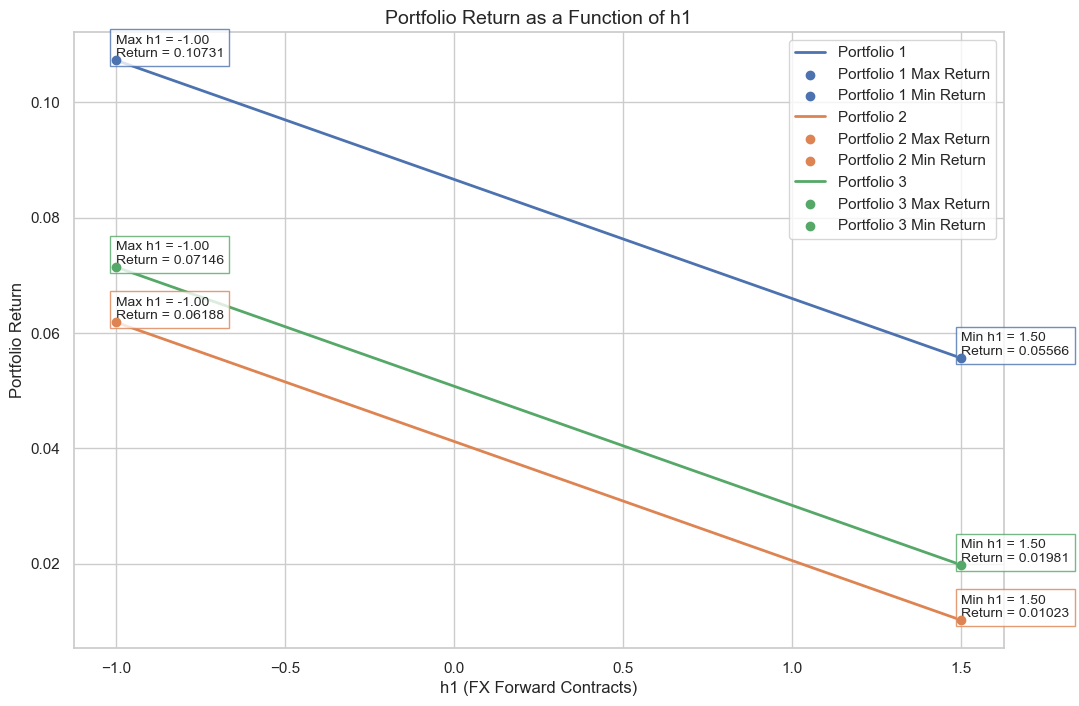

In [73]:
portfolio_returns_list = calculate_and_plot_multiple_portfolio_returns(
    PnL_matrix=PnL_matrix,
    h2_list=portfolio_holdings,
    h1_values=h1_values,
    h2_labels=h2_labels
)

# Part 3 - Estimation Uncertanity

In the beginnning we simulated for t = 1 year (52 weekw), here we need to do it for t = 2 years (104 weeks), so naturally we will us the same setup :D

### Set parameters

In [74]:
# Set parameters
#x0, mu, cov_matrix, delta_t, number of simulatoions are all the same

#Investemt horizion are now changed
num_steps2 = 104  # Number of time steps (2 years now)
num_simulations = 10000

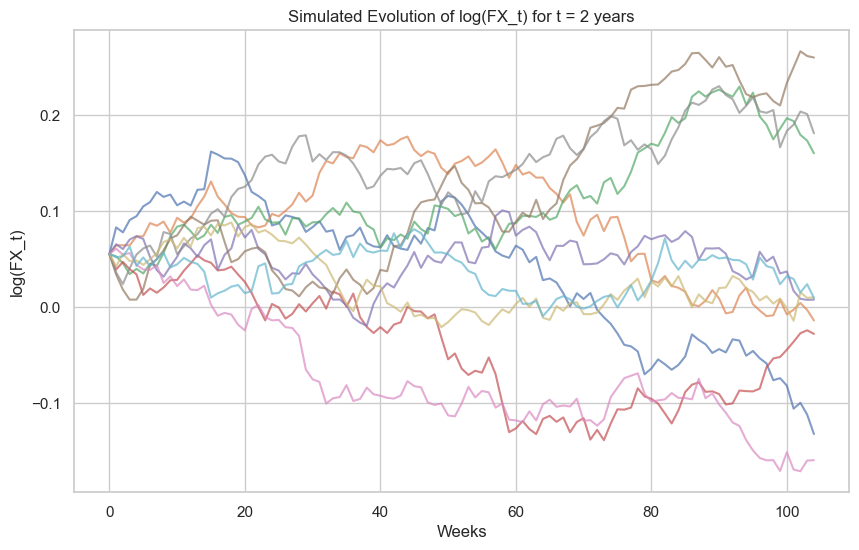

In [75]:
#We will use the functions again to simulate: def simulate_paths(x0, mu, cov_matrix, num_steps, delta_t, num_simulations):
#Just where we have changed the number of steps
np.random.seed(2000)  # Ensure reproducibility
# Run simulation
simulations2 = simulate_paths(x0, mu, cov_matrix, num_steps2, delta_t, num_simulations)

#Just checking that is was a succes: Extract log(FX_t) (first variable in X_t)
log_FX_t_2 = simulations2[:, 0, :]  # First variable represents log(FX_t)

# Plot log(FX_t) for a few simulated paths with weeks on the x-axis
weeks = np.arange(0, num_steps2 + 1)  # Create array of weeks (0 to 52)
plt.figure(figsize=(10, 6))
for i in range(10):  # Show 10 random simulated paths
    plt.plot(weeks, log_FX_t_2[:, i], alpha=0.7)
plt.title("Simulated Evolution of log(FX_t) for t = 2 years")
plt.xlabel("Weeks")
plt.ylabel("log(FX_t)")
plt.grid(True)
plt.savefig("simulated_log_FX_t2.png")  # Save the plot as an image
plt.show()

Theoretical mean of log(V^US,local): 0.140000
Theoretical variance of log(V^US,local): 0.044513
Simulated mean of log(V^US,local): 0.139974
Simulated variance of log(V^US,local): 0.044742


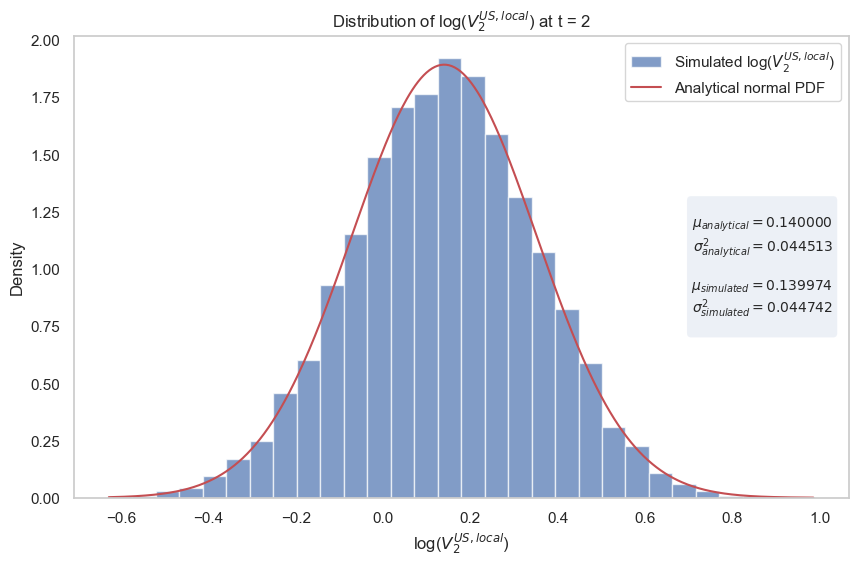

Analytical mean of V^US,local: 1.176162
Analytical variance of V^US,local: 0.062968
Simulated mean of V^US,local: 1.176216
Simulated variance of V^US,local: 0.062947


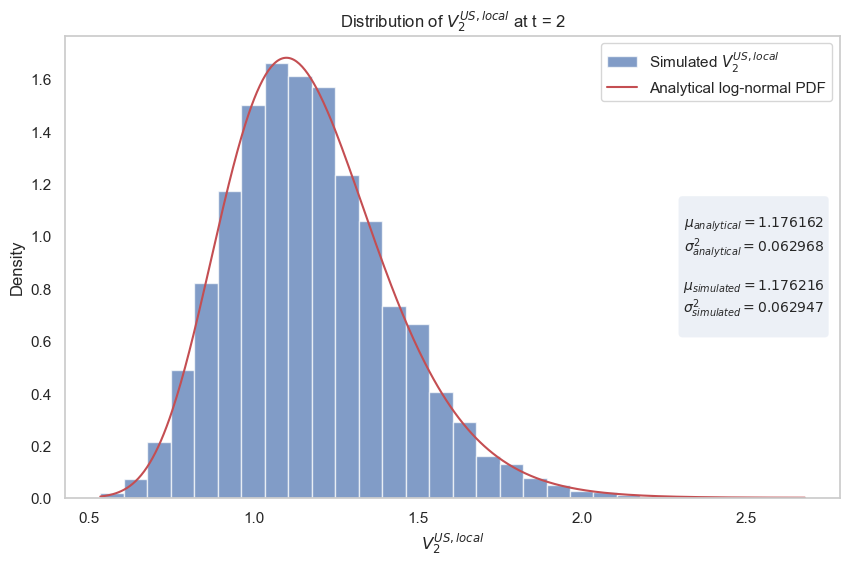

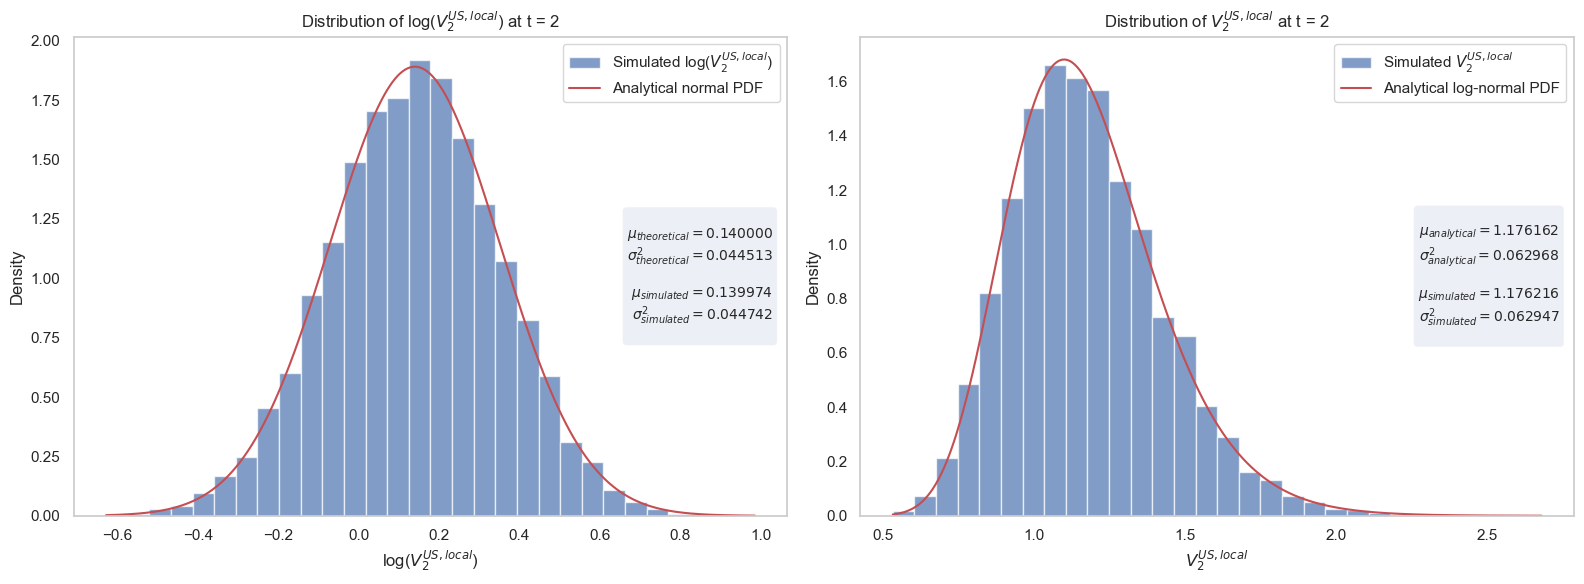

In [76]:
# Extract log(V_1^US,local)
log_V_US_local2 = simulations2[:, 1, :]  # Second component is log(V^US,local)

# Final distribution at t = 1
final_log_V_US_local2 = log_V_US_local2[-1, :]

# Theoretical mean and variance for log(V^US,local)
theoretical_mean_log2 = x0[1] + mu[1] * num_steps2
theoretical_variance_log2 = cov_matrix[1, 1] * num_steps2

# Simulated mean and variance
empirical_mean_log2 = np.mean(final_log_V_US_local2)
empirical_variance_log2 = np.var(final_log_V_US_local2)

print(f"Theoretical mean of log(V^US,local): {theoretical_mean_log2:.6f}")
print(f"Theoretical variance of log(V^US,local): {theoretical_variance_log2:.6f}")
print(f"Simulated mean of log(V^US,local): {empirical_mean_log2:.6f}")
print(f"Simulated variance of log(V^US,local): {empirical_variance_log2:.6f}")

# Plot histogram of log(V_1^US,local) and theoretical distribution
x_values_log = np.linspace(min(final_log_V_US_local2), max(final_log_V_US_local2), 500)
theoretical_pdf_log = norm.pdf(x_values_log, loc=theoretical_mean_log2, scale=np.sqrt(theoretical_variance_log2))

plt.figure(figsize=(10, 6))
plt.hist(final_log_V_US_local2, bins=30, density=True, alpha=0.7, label='Simulated log($V_2^{US,local}$)')
plt.plot(x_values_log, theoretical_pdf_log, 'r-', label='Analytical normal PDF')
plt.title("Distribution of log($V_2^{US,local}$) at t = 2")
plt.xlabel("log($V_2^{US,local}$)")
plt.ylabel("Density")
plt.legend()
# Add theoretical and simulated statistics as text with LaTeX symbols
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean_log2:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance_log2:.6f}$

$\\mu_{{simulated}} = {empirical_mean_log2:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_log2:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.show()

# Convert to V_1^US,local (exponentiate)
final_V_US_local2 = np.exp(final_log_V_US_local2)

# Theoretical mean and variance for V^US,local
theoretical_mean2 = np.exp(theoretical_mean_log2 + theoretical_variance_log2 / 2)
theoretical_variance2 = (
    (np.exp(theoretical_variance_log2) - 1)
    * np.exp(2 * theoretical_mean_log2 + theoretical_variance_log2)
)

# Simulated mean and variance
empirical_mean2 = np.mean(final_V_US_local2)
empirical_variance2 = np.var(final_V_US_local2)

print(f"Analytical mean of V^US,local: {theoretical_mean2:.6f}")
print(f"Analytical variance of V^US,local: {theoretical_variance2:.6f}")
print(f"Simulated mean of V^US,local: {empirical_mean2:.6f}")
print(f"Simulated variance of V^US,local: {empirical_variance2:.6f}")

# Plot histogram of V_1^US,local and theoretical distribution
x_values = np.linspace(min(final_V_US_local2), max(final_V_US_local2), 500)
theoretical_pdf = lognorm.pdf(x_values, s=np.sqrt(theoretical_variance_log2),
                              scale=np.exp(theoretical_mean_log2))

plt.figure(figsize=(10, 6))
plt.hist(final_V_US_local2, bins=30, density=True, alpha=0.7, label='Simulated $V_2^{US,local}$')
plt.plot(x_values, theoretical_pdf, 'r-', label='Analytical log-normal PDF')
plt.title("Distribution of $V_2^{US,local}$ at t = 2")
plt.xlabel("$V_2^{US,local}$")
plt.ylabel("Density")
plt.legend()
# Add theoretical and simulated statistics as text with LaTeX symbols
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean2:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance2:.6f}$

$\\mu_{{simulated}} = {empirical_mean2:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance2:.6f}$
"""
plt.gca().text(0.98, 0.5, textstr, transform=plt.gca().transAxes, fontsize=10, 
               verticalalignment='center', horizontalalignment='right',
               bbox=dict(boxstyle="round", alpha=0.1))
plt.grid()
plt.show()


# Set up the figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot histogram of log(V_1^US,local) and theoretical distribution on the left
axes[0].hist(final_log_V_US_local2, bins=30, density=True, alpha=0.7, label='Simulated log($V_2^{US,local}$)')
axes[0].plot(x_values_log, theoretical_pdf_log, 'r-', label='Analytical normal PDF')
axes[0].set_title("Distribution of log($V_2^{US,local}$) at t = 2")
axes[0].set_xlabel("log($V_2^{US,local}$)")
axes[0].set_ylabel("Density")
axes[0].legend()
textstr_log = f"""
$\\mu_{{theoretical}} = {theoretical_mean_log2:.6f}$
$\\sigma^2_{{theoretical}} = {theoretical_variance_log2:.6f}$

$\\mu_{{simulated}} = {empirical_mean_log2:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance_log2:.6f}$
"""
axes[0].text(0.98, 0.5, textstr_log, transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='center', horizontalalignment='right',
             bbox=dict(boxstyle="round", alpha=0.1))
axes[0].grid()

# Plot histogram of V_1^US,local and theoretical distribution on the right
axes[1].hist(final_V_US_local2, bins=30, density=True, alpha=0.7, label='Simulated $V_2^{US,local}$')
axes[1].plot(x_values, theoretical_pdf, 'r-', label='Analytical log-normal PDF')
axes[1].set_title("Distribution of $V_2^{US,local}$ at t = 2")
axes[1].set_xlabel("$V_2^{US,local}$")
axes[1].set_ylabel("Density")
axes[1].legend()
textstr = f"""
$\\mu_{{analytical}} = {theoretical_mean2:.6f}$
$\\sigma^2_{{analytical}} = {theoretical_variance2:.6f}$

$\\mu_{{simulated}} = {empirical_mean2:.6f}$
$\\sigma^2_{{simulated}} = {empirical_variance2:.6f}$
"""
axes[1].text(0.98, 0.5, textstr, transform=axes[1].transAxes, fontsize=10, 
             verticalalignment='center', horizontalalignment='right',
             bbox=dict(boxstyle="round", alpha=0.1))
axes[1].grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig("combined_plots_V2_US.png")
plt.show()


## Calculate $PnL$_2

### First P2 components (same method as $P_1$)

In [77]:
P2_components = np.zeros((num_simulations, 5))

for sim in range(num_simulations):
    log_FX_2 = simulations2[:, 0, sim]  # First component
    log_V2_US_local = simulations2[:, 1, sim]  # Second component
    log_V2_EUR = simulations2[:, 2, sim]  # Third component
    y3_1_US = simulations2[:, 12, sim]  # Assuming 4-year USD yield at horizon
    y3_1_EUR = simulations2[:,6, sim]  # Assuming 4-year EUR yield at horizon
    
    # Calculate P2 components
    FX_2 = np.exp(log_FX_2[-1])
    V2_US_local = np.exp(log_V2_US_local[-1])
    V2_EUR = np.exp(log_V2_EUR[-1])
    Z2_US_3Y_local = np.exp(-3 * y3_1_US[-1])
    Z2_EUR_3Y = np.exp(-3 * y3_1_EUR[-1])
    
    P2_components[sim, :] = [FX_2, V2_US_local, V2_EUR, Z2_US_3Y_local, Z2_EUR_3Y]

# Estimate mean vector and covariance matrix
mu_P2 = np.mean(P2_components, axis=0)
Sigma_P2 = np.cov(P2_components, rowvar=False)
# Print the results
print("Estimated Mean Vector (mu_P2):")
print(mu_P2)
print("\nEstimated Covariance Matrix (Sigma_P2):")
print(Sigma_P2)


Estimated Mean Vector (mu_P2):
[1.06406186 1.17621557 1.15377193 0.89429101 0.94182362]

Estimated Covariance Matrix (Sigma_P2):
[[ 1.36062722e-02  4.90659526e-03 -4.79154902e-04  9.33492849e-04
   9.63317816e-05]
 [ 4.90659526e-03  6.29528612e-02  4.79371104e-02 -6.05407867e-04
   1.12004471e-03]
 [-4.79154902e-04  4.79371104e-02  6.61405688e-02 -1.08057579e-03
   6.71483662e-04]
 [ 9.33492849e-04 -6.05407867e-04 -1.08057579e-03  8.59972449e-04
   4.93596425e-04]
 [ 9.63317816e-05  1.12004471e-03  6.71483662e-04  4.93596425e-04
   5.89472659e-04]]


### Second P2_EUR components (same method as $P_1EUR$)

In [78]:
# Compute P_EUR_2 components
P_EUR_2 = np.zeros_like(P2_components)

# Transformations
P_EUR_2[:, 0] = 1 / P2_components[:, 0]  # 1 / FX_2
P_EUR_2[:, 1] = P2_components[:, 1] * P_EUR_2[:, 0]  # V2_US_local / FX_2
P_EUR_2[:, 2] = P2_components[:, 2]  # V2_EUR
P_EUR_2[:, 3] = P2_components[:, 3] * P_EUR_2[:, 0] # Z2_US_4Y_local / FX_2
P_EUR_2[:, 4] = P2_components[:, 4]  # Z2_EUR_3Y

# Estimate mean vector and covariance matrix
mu_P2_EUR = np.mean(P_EUR_2, axis=0)
Sigma_P2_EUR = np.cov(P_EUR_2, rowvar=False)
# Print the results
print("Estimated Mean Vector (mu_P2_EUR):")
print(mu_P2_EUR)
print("\nEstimated Covariance Matrix (Sigma_P2_EUR):")
print(Sigma_P2_EUR)

Estimated Mean Vector (mu_P2_EUR):
[0.95108401 1.1143167  1.15377193 0.84971151 0.94182362]

Estimated Covariance Matrix (Sigma_P2_EUR):
[[ 1.08539231e-02  8.54255963e-03  4.49418566e-04  8.89409183e-03
  -8.52329133e-05]
 [ 8.54255963e-03  6.19285037e-02  4.59962605e-02  6.15803592e-03
   9.69528867e-04]
 [ 4.49418566e-04  4.59962605e-02  6.61405688e-02 -6.16762174e-04
   6.71483662e-04]
 [ 8.89409183e-03  6.15803592e-03 -6.16762174e-04  8.01064603e-03
   3.91770282e-04]
 [-8.52329133e-05  9.69528867e-04  6.71483662e-04  3.91770282e-04
   5.89472659e-04]]


### Third $PnL_2$ (same method as $PnL_1$)

In [79]:
forward_price = fx_linear * np.exp(rate_differential*2)

In [80]:
print(f"1-year FX forward price (EUR/USD): {forward_price:.8f}")
print(f"Interest rate differential (USD - EUR): {rate_differential:.8f}")
print(f"1-year : {V0_EUR:.8f}")
print(f"Z_USD_5Y: {Z0_USD_Y_price:.8f}")
print(f"Z0_USD_Y_price_eur: {Z0_USD_Y_price_eur:.8f}")
print(f"Z0_EUR_Y_price: {Z0_EUR_Y_price:.8f}")

1-year FX forward price (EUR/USD): 1.09823704
Interest rate differential (USD - EUR): 0.01920671
1-year : 1.00000000
Z_USD_5Y: 0.82940812
Z0_USD_Y_price_eur: 0.78479266
Z0_EUR_Y_price: 0.90462341


In [81]:
PNL2 = P_EUR_2.copy() #Need to be a copy otherwise we will change P_EUR_1
PNL2[:,0] = 1/forward_price-P_EUR_2[:, 0]
PNL2[:,1] = P_EUR_2[:, 1]-V0_US
PNL2[:,2] = P_EUR_2[:, 2]-V0_EUR
PNL2[:,3] = P_EUR_2[:, 3]-Z0_USD_Y_price_eur
PNL2[:,4] = P_EUR_2[:, 4]-Z0_EUR_Y_price

In [82]:
PNL2_FX = 1/forward_price-P_EUR_2[:, 0]
PNL2_VUS = P_EUR_2[:, 1]-V0_US
PNL2_VEUR = P_EUR_2[:, 2]-V0_EUR
PNL2_ZUSD = P_EUR_2[:, 3]-Z0_USD_Y_price_eur
PNL2_ZEUR = P_EUR_2[:, 4]-Z0_EUR_Y_price
PnL_vars2 = [PNL2_FX, PNL2_VUS, PNL2_VEUR, PNL2_ZUSD, PNL2_ZEUR]

In [83]:
PnL2_matrix = np.vstack([PNL2_FX, PNL2_VUS, PNL2_VEUR, PNL2_ZUSD, PNL2_ZEUR])

In [84]:
PnL2_matrix.shape

(5, 10000)

In [85]:
PnL2_matrix = np.array(PnL_vars2).T

PnL2_cov_matrix = np.cov(PnL2_matrix, rowvar=False)
print("Covariance-matrix:")
print(PnL2_cov_matrix)

Covariance-matrix:
[[ 1.08539231e-02 -8.54255963e-03 -4.49418566e-04 -8.89409183e-03
   8.52329133e-05]
 [-8.54255963e-03  6.19285037e-02  4.59962605e-02  6.15803592e-03
   9.69528867e-04]
 [-4.49418566e-04  4.59962605e-02  6.61405688e-02 -6.16762174e-04
   6.71483662e-04]
 [-8.89409183e-03  6.15803592e-03 -6.16762174e-04  8.01064603e-03
   3.91770282e-04]
 [ 8.52329133e-05  9.69528867e-04  6.71483662e-04  3.91770282e-04
   5.89472659e-04]]


In [86]:
mu_PnL2 = np.mean(PNL2, axis=0)
Sigma_PnL2 = np.cov(PNL2, rowvar=False)

print("Estimated Mean Vector (PnL_2):")
print(mu_PnL2)
print("\nEstimated Covariance Matrix (PnL_2):")
print(Sigma_PnL2)

Estimated Mean Vector (PnL_2):
[-0.04053377  0.16810863  0.15377193  0.06491885  0.0372002 ]

Estimated Covariance Matrix (PnL_2):
[[ 1.08539231e-02 -8.54255963e-03 -4.49418566e-04 -8.89409183e-03
   8.52329133e-05]
 [-8.54255963e-03  6.19285037e-02  4.59962605e-02  6.15803592e-03
   9.69528867e-04]
 [-4.49418566e-04  4.59962605e-02  6.61405688e-02 -6.16762174e-04
   6.71483662e-04]
 [-8.89409183e-03  6.15803592e-03 -6.16762174e-04  8.01064603e-03
   3.91770282e-04]
 [ 8.52329133e-05  9.69528867e-04  6.71483662e-04  3.91770282e-04
   5.89472659e-04]]


## Sampling uncertainty, here with wishart

In [87]:
#First we only want to keep the relevant indicies for the covariance-matrix, the mu-vector and also the intial values x[0]
indices_to_keep = [0, 1, 2, 12, 6]

reduced_cov_matrix = cov_matrix[np.ix_(indices_to_keep, indices_to_keep)]
reduced_mu = mu[np.ix_(indices_to_keep)]
reduced_x0 = x0[np.ix_(indices_to_keep)]

print("Reduced cov-matrix:")
print(reduced_cov_matrix)
print("Reduced mu:")
print(reduced_mu)
print("Reduced x0:")
print(reduced_x0)

Reduced cov-matrix:
[[ 1.12779512e-04  3.84203518e-05 -4.70984341e-06 -3.15174770e-06
  -3.89102971e-07]
 [ 3.84203518e-05  4.28008869e-04  3.36015614e-04  1.66597186e-06
  -3.14903150e-06]
 [-4.70984341e-06  3.36015614e-04  4.65448341e-04  3.44481039e-06
  -1.78206509e-06]
 [-3.15174770e-06  1.66597186e-06  3.44481039e-06  1.16941118e-06
   6.53767826e-07]
 [-3.89102971e-07 -3.14903150e-06 -1.78206509e-06  6.53767826e-07
   7.24487443e-07]]
Reduced mu:
[0.         0.00134615 0.00115385 0.         0.        ]
Reduced x0:
[0.05529279 0.         0.         0.03740859 0.02004731]


In [88]:
## Sampling uncertainty, here with wishart
num_steps2 = 52 * 2 #2 years
num_simulations_cov = 10000 #10.000 simulation as usual
t_horizon = 2
#cov_matrix - the weekly covariance-matrix from the xlsx-file




np.random.seed(2000)  # Ensure reproducibility
sim_cov_matrix_hat = stats.wishart.rvs(df = num_steps2 - 1, scale = reduced_cov_matrix, size = num_simulations_cov)
#sim_cov_matrix_hat is already at the horizon (2 years)

#A little smarter to use when we will calculate the bond price for 10.000 cov_matrices
bond_matrix = np.diag([1.0, 1.0, 1.0, -(5.0 - t_horizon), -(5.0 - t_horizon)])


#Keeping mu fixed (we will just use the analytical values)
mu_fixed = reduced_mu * num_steps2 + reduced_x0
true_cov_matrix = reduced_cov_matrix * num_steps2


#We need to transform to prices (the bond prices for both the Sigma-matrices and the fixed mu)
sim_cov_matrix_hat = np.array([bond_matrix @ sim_cov_matrix_hat[i] @ bond_matrix.T for i in range(num_simulations_cov)])
mu_fixed_new = mu_fixed  @ bond_matrix.T
true_cov_matrix_new = bond_matrix @ true_cov_matrix @ bond_matrix.T


#We now need to transform into domestric currency, both covariance and also the fixed mu 
sim_cov_matrix2_hat = np.array([weight_matrix @ sim_cov_matrix_hat[i] @ weight_matrix.T for i in range(num_simulations_cov)])
mu_fixed2_new = mu_fixed_new  @ weight_matrix.T
true_cov_matrix2_new = weight_matrix @ true_cov_matrix_new @ weight_matrix.T

#Transform to P2_EUR_cov_matrix
sim_cov_matrix_exp =  np.array([compute_exp_cov_matrix(mu_fixed2_new, sim_cov_matrix2_hat[i]) for i in range(num_simulations_cov)]) #We are keeping mu_fixed (only using one mu, the fixed true analytical)
mu_fixed_exp = compute_exp_mean_from_log(mu_fixed2_new, true_cov_matrix2_new) #The fixed P2_mu vector
true_cov_matrix_exp = compute_exp_cov_matrix(mu_fixed2_new, true_cov_matrix2_new) #The true covariance-matrix
sim_cov_matrix3_mean = np.mean(sim_cov_matrix_exp, axis = 0)

#For the final PnL cov-matrix
sim_cov_matrix4_hat = np.zeros_like(sim_cov_matrix_exp)


#Multipliing (-1) in 1. row and colum (not the diagonal) because of: - 1/FX_2
for i in range(num_simulations_cov):
    matrix = sim_cov_matrix_exp[i]  
    matrix[0, 1:] *= -1  
    matrix[1:, 0] *= -1 
    sim_cov_matrix4_hat[i] = matrix

true_cov_matrix_exp[0, 1:] *= -1
true_cov_matrix_exp[1:, 0] *= -1 

sim_cov_matrix4_mean = np.mean(sim_cov_matrix4_hat, axis=0)
#And now for the PnL, here we only need to be aware of 1/FX_1, as it is -1 * 1/FX_1, so we multiply -1 to first row and column but not the diagonal

# Printing to check
print("Mu_fixed P2_mu:")
print(mu_fixed_exp)

print("")

print("Mean of simulated covariance matrices (sim_cov_matrix_exp), this is the P2_EUR_cov_matrix:")
print(sim_cov_matrix3_mean)

print("")

print("Mean of simulated covariance matrices (sim_cov_matrix4_hat), this is the PNL_2_cov_matrix:")
print(sim_cov_matrix4_mean)

print("")
print("The true PnL_2 cov-matrix: ")
print(true_cov_matrix_exp)


forward_price = fx_linear * np.exp(rate_differential*2) #Here we assume that is the same formula but we multiply with 2

#PnL based on true mu
pnl2_true_means = [
    1 / forward_price - mu_fixed_exp[0],                  # PNL1_FX
    mu_fixed_exp[1] - V0_US,                             # PNL2_VUS
    mu_fixed_exp[2] - V0_EUR,                            # PNL3_VEUR
    mu_fixed_exp[3] - Z0_USD_Y_price_eur,                # PNL4_ZUSD
    mu_fixed_exp[4] - Z0_EUR_Y_price                     # PNL5_ZEUR
]
print("")
print("True PnL_2 means:")
print(pnl2_true_means)



print(sim_cov_matrix4_hat.shape)



Mu_fixed P2_mu:
[0.95177344 1.11497557 1.15511894 0.85036461 0.94195021]

Mean of simulated covariance matrices (sim_cov_matrix_exp), this is the P2_EUR_cov_matrix:
[[ 0.01057121  0.00811823  0.00048307  0.00864539 -0.00010845]
 [ 0.00811823  0.06100947  0.04617534  0.00584224  0.00090718]
 [ 0.00048307  0.04617534  0.06581942 -0.00060905  0.00060236]
 [ 0.00864539  0.00584224 -0.00060905  0.00780227  0.00038853]
 [-0.00010845  0.00090718  0.00060236  0.00038853  0.0005966 ]]

Mean of simulated covariance matrices (sim_cov_matrix4_hat), this is the PNL_2_cov_matrix:
[[ 0.01057121 -0.00811823 -0.00048307 -0.00864539  0.00010845]
 [-0.00811823  0.06100947  0.04617534  0.00584224  0.00090718]
 [-0.00048307  0.04617534  0.06581942 -0.00060905  0.00060236]
 [-0.00864539  0.00584224 -0.00060905  0.00780227  0.00038853]
 [ 0.00010845  0.00090718  0.00060236  0.00038853  0.0005966 ]]

The true PnL_2 cov-matrix: 
[[ 0.0106876  -0.00823848 -0.00053865 -0.008744    0.00010883]
 [-0.00823848  0.06

In [89]:
sim_cov_matrix4_hat[2]

array([[ 0.01043896, -0.00557333, -0.00254436, -0.00888303,  0.00010022],
       [-0.00557333,  0.05551034,  0.03820878,  0.0037962 ,  0.00109541],
       [-0.00254436,  0.03820878,  0.05254085,  0.00137433,  0.00055803],
       [-0.00888303,  0.0037962 ,  0.00137433,  0.00837979,  0.00045819],
       [ 0.00010022,  0.00109541,  0.00055803,  0.00045819,  0.00064305]])

In [90]:
is_positive_semidefinite(sim_cov_matrix4_hat[2232])

Eigenvalues >= 0: True
Cholesky decomposition: True
Principal minors non-negative: True
Symmetry: True
Is Positive Semidefinite: True


{'Eigenvalues': True,
 'Cholesky': True,
 'Principal Minors': True,
 'Symmetry': True,
 'Is Positive Semidefinite': True}

In [91]:
#The multi asset portfolio
portfolio_3_holdings

array([0.21137   , 0.2       , 0.38226657, 0.33162971])

## Based on simulated covariance matrices, calculate optimal hedge ratios

In [92]:
#Us exposure:
usd_exposure_3 = calculate_usd_exposure(portfolio_3_holdings, fx_linear) #Us exposure

#Initial check
optimal_hedge_0 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=sim_cov_matrix4_hat[0], portfolio_holdings123=portfolio_3_holdings) #nr og forward contracts
optimal_hedge_1 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=sim_cov_matrix4_hat[1], portfolio_holdings123=portfolio_3_holdings)
optimal_hedge_2 = calculate_min_var_hedge_ratio_with_holdings(cov_mat=sim_cov_matrix4_hat[2], portfolio_holdings123=portfolio_3_holdings)
hedge_percentage_3_0 = calculate_hedge_percentage(optimal_hedge_0, usd_exposure_3) #Hedge ratio
hedge_percentage_3_1 = calculate_hedge_percentage(optimal_hedge_1, usd_exposure_3)
hedge_percentage_3_2 = calculate_hedge_percentage(optimal_hedge_2, usd_exposure_3)
print(optimal_hedge_0)
print(optimal_hedge_1)
print(optimal_hedge_2)
print("")
print(hedge_percentage_3_0)
print(hedge_percentage_3_1)
print(hedge_percentage_3_2)



0.2826979839178666
0.41161680912874954
0.4837027748258782

0.534982228164577
0.7789502940412537
0.9153669391604828


Now set up as loop

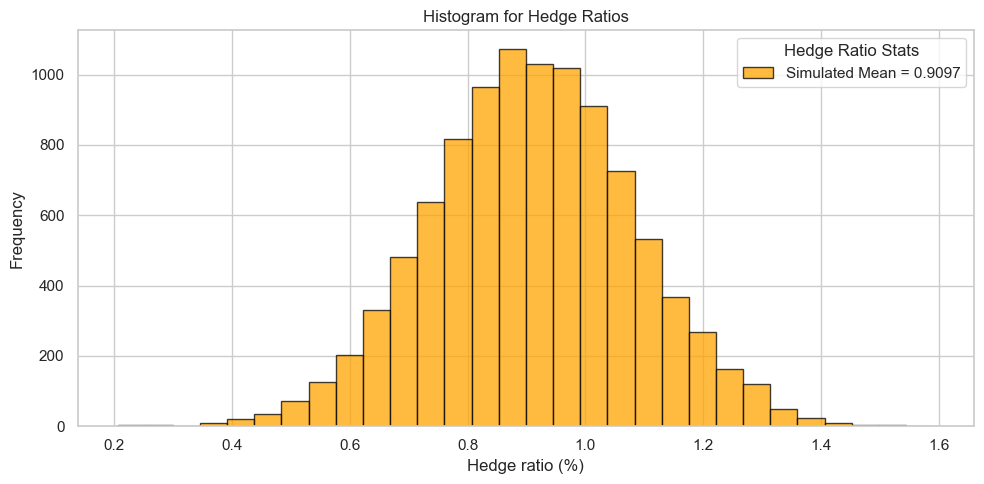

0.9096821943042182

In [93]:
# Number of covariance: num_simulations_cov
num_cov_matrices = len(sim_cov_matrix4_hat)
usd_exposure_3 = calculate_usd_exposure(portfolio_3_holdings, fx_linear) #Us exposure

# Initialize
optimal_forwards = []
hedge_ratios = []


for i in range(num_simulations_cov):
    optimal_forward = calculate_min_var_hedge_ratio_with_holdings(cov_mat=sim_cov_matrix4_hat[i], portfolio_holdings123=portfolio_3_holdings)
    hedge_ratio = calculate_hedge_percentage(optimal_forward, usd_exposure_3)
    
    optimal_forwards.append(optimal_forward)
    hedge_ratios.append(hedge_ratio)


mean_hedge = np.mean(hedge_ratios)
variance_hedge = np.var(hedge_ratios)

# Hist of hedge ratios
plt.figure(figsize=(10, 5))
plt.hist(hedge_ratios, bins=30, alpha=0.75, edgecolor='black', color='orange')
plt.title("Histogram for Hedge Ratios")
plt.xlabel("Hedge ratio (%)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.legend(
    title="Hedge Ratio Stats",
    labels=[
        f"Simulated Mean = {mean_hedge:.4f}",
        f"Simulated Variance = {variance_hedge:.4f}"
    ],
    loc="upper right"
)
plt.tight_layout()
plt.grid(True)
plt.savefig("Hedge_hist.png")
plt.show()

np.mean(hedge_ratios)

### Hedge ratios

<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\848190645.py:7: SyntaxWarning: invalid escape sequence '\S'
  ax.set_title("Hedge Ratios for simulated $\Sigma$-matrices", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\848190645.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hedge_ratios, shade=True, color="blue", ax=ax)


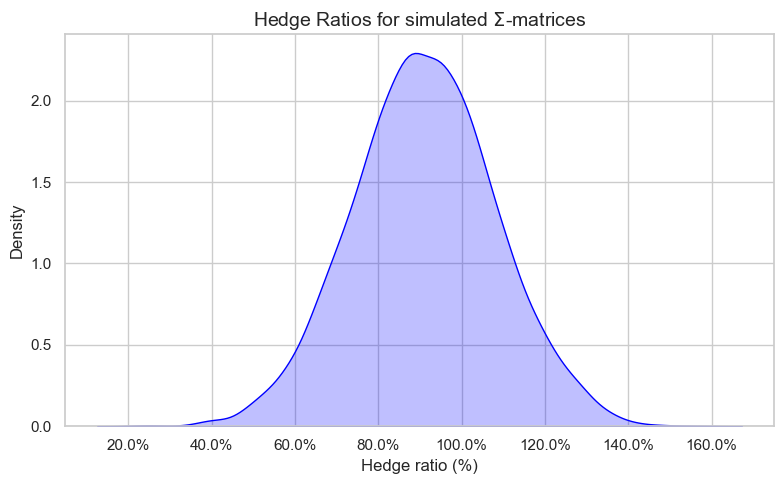

In [94]:
hedge_ratios = np.array(hedge_ratios)
# Plot for hedge ratios
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(hedge_ratios, shade=True, color="blue", ax=ax)
ax.set_xlabel("Hedge ratio (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Hedge Ratios for simulated $\Sigma$-matrices", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

plt.tight_layout()
plt.grid(True)
plt.savefig("Hedge_pdf.png")
plt.show()


### Expected PnL ($\mu$)

In [95]:
pnl2_true_means

[-0.04122320092750009,
 0.1687674978170488,
 0.15511893618277228,
 0.06557194432981095,
 0.03732679467592692]

In [96]:
optimal_forwards = np.array(optimal_forwards)
port_holdings_sim = np.array([np.r_[of, portfolio_3_holdings] for of in optimal_forwards])
port_holdings_sim

array([[0.28269798, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.41161681, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.48370277, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       ...,
       [0.5131135 , 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.65915881, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.48666796, 0.21137   , 0.2       , 0.38226657, 0.33162971]])

In [97]:
np.mean(optimal_forwards)

0.4806988135252065

In [98]:
optimal_hedge_mean_port=np.append(np.mean(optimal_forwards),portfolio_3_holdings)

In [99]:
pnl2_true_means

[-0.04122320092750009,
 0.1687674978170488,
 0.15511893618277228,
 0.06557194432981095,
 0.03732679467592692]

In [100]:
mu_port_pnl_sim = port_holdings_sim @ pnl2_true_means #With the true means
mu_port_pnl_sim

array([0.09248709, 0.08717265, 0.08420103, ..., 0.08298863, 0.07696817,
       0.0840788 ])

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\818093638.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("$\mu_{PnL_2}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\818093638.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("Expected $\mu_{PnL_2}$ for simulated $\Sigma$-matrices and optimal hedge ratios", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\818093638.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mu_port_pnl_sim, shade=True, color="green", ax=ax)


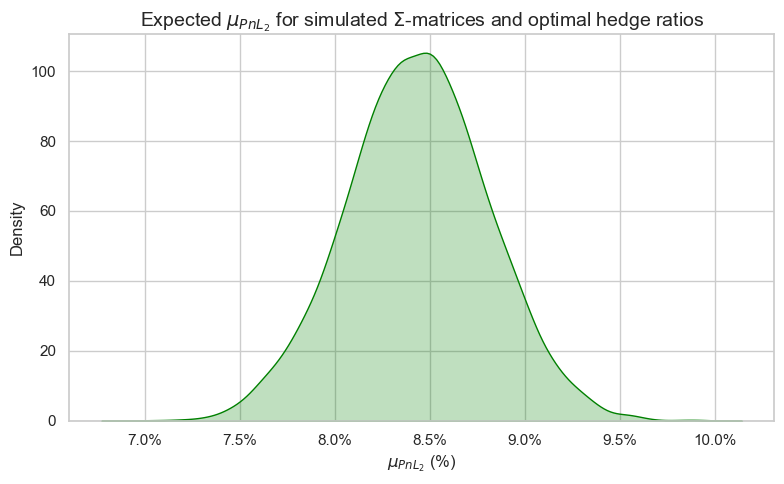

In [101]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(mu_port_pnl_sim, shade=True, color="green", ax=ax)

ax.set_xlabel("$\mu_{PnL_2}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\mu_{PnL_2}$ for simulated $\Sigma$-matrices and optimal hedge ratios", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

# Layout og visning
plt.tight_layout()
plt.grid(True)
plt.savefig("mu_pdf.png")
plt.show()

### Expected $\sigma_{\text{PnL}_2}$

In [102]:
print("The true PnL_2 cov-matrix: ")
print(true_cov_matrix_exp)
print(port_holdings_sim)

The true PnL_2 cov-matrix: 
[[ 0.0106876  -0.00823848 -0.00053865 -0.008744    0.00010883]
 [-0.00823848  0.06145435  0.0464566   0.00592554  0.00090476]
 [-0.00053865  0.0464566   0.06617775 -0.00057442  0.00060514]
 [-0.008744    0.00592554 -0.00057442  0.00789365  0.00039301]
 [ 0.00010883  0.00090476  0.00060514  0.00039301  0.00060188]]
[[0.28269798 0.21137    0.2        0.38226657 0.33162971]
 [0.41161681 0.21137    0.2        0.38226657 0.33162971]
 [0.48370277 0.21137    0.2        0.38226657 0.33162971]
 ...
 [0.5131135  0.21137    0.2        0.38226657 0.33162971]
 [0.65915881 0.21137    0.2        0.38226657 0.33162971]
 [0.48666796 0.21137    0.2        0.38226657 0.33162971]]


In [103]:
#Calculating the risk ny using the true covariance-matrix: true_cov_matrix_exp
sigma2_port_pnl_sim = np.apply_along_axis(lambda x: x @ true_cov_matrix_exp @ x, 1, port_holdings_sim)
sigma_port_pnl_sim = np.sqrt(sigma2_port_pnl_sim)
sigma_port_pnl_sim

array([0.09826448, 0.0963497 , 0.09607163, ..., 0.09612404, 0.09779424,
       0.09607255])

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\269937275.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("$\sigma_{PnL_2}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\269937275.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Expected $\sigma_{PnL_2}$ for simulated $\Sigma$-matrices", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\269937275.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_port_pnl_sim, shade=True, color="purple", ax=ax)


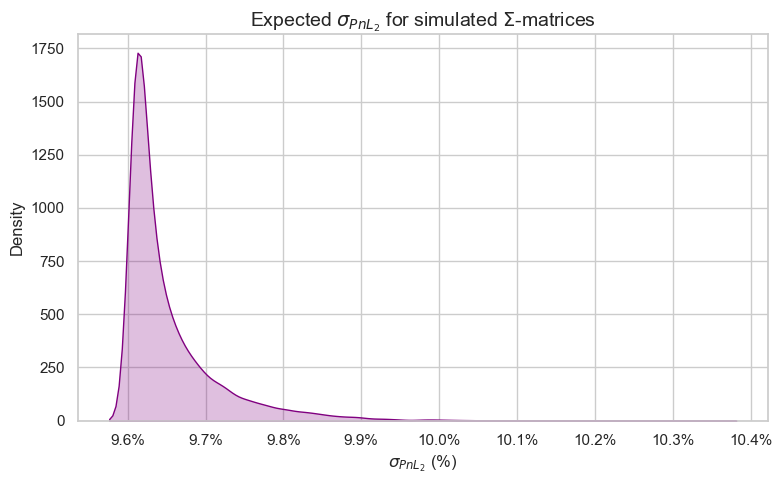

In [104]:
# Plot for sigma_port_pnl_sim
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(sigma_port_pnl_sim, shade=True, color="purple", ax=ax)

ax.set_xlabel("$\sigma_{PnL_2}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\sigma_{PnL_2}$ for simulated $\Sigma$-matrices", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

plt.tight_layout()
plt.grid(True)
plt.savefig("sigma_pdf.png")
plt.show()

### Expected $\text{CVAR}_{\text{PnL}_2}$

In [105]:
pnl.shape

(10000,)

In [106]:
pnl2_true_means

[-0.04122320092750009,
 0.1687674978170488,
 0.15511893618277228,
 0.06557194432981095,
 0.03732679467592692]

In [107]:
analytical_means

[0.9489866779587082,
 1.02713138521889,
 1.074764595705856,
 0.8169609715437517,
 0.9232198839123239]

In [108]:
sim_cov_matrix_hat

array([[[ 1.20329955e-02,  7.97989512e-03,  5.52888479e-03,
          9.33293889e-04,  1.86666987e-04],
        [ 7.97989512e-03,  4.92766405e-02,  3.33579277e-02,
         -5.25428655e-04,  1.14772421e-03],
        [ 5.52888479e-03,  3.33579277e-02,  4.05573910e-02,
          2.83819502e-04,  1.30774546e-03],
        [ 9.33293889e-04, -5.25428655e-04,  2.83819502e-04,
          1.13597204e-03,  6.12718891e-04],
        [ 1.86666987e-04,  1.14772421e-03,  1.30774546e-03,
          6.12718891e-04,  6.11511904e-04]],

       [[ 1.08914608e-02,  6.28205081e-03,  8.88833665e-05,
          9.82216510e-04,  5.82119742e-05],
        [ 6.28205081e-03,  5.44767184e-02,  4.39422681e-02,
         -3.29991451e-04,  1.18259982e-03],
        [ 8.88833665e-05,  4.39422681e-02,  5.45498186e-02,
         -9.82861506e-04,  8.62887716e-04],
        [ 9.82216510e-04, -3.29991451e-04, -9.82861506e-04,
          1.14927448e-03,  5.46867188e-04],
        [ 5.82119742e-05,  1.18259982e-03,  8.62887716e-04,
  

# New CVAR

In [109]:
port_holdings_sim

array([[0.28269798, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.41161681, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.48370277, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       ...,
       [0.5131135 , 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.65915881, 0.21137   , 0.2       , 0.38226657, 0.33162971],
       [0.48666796, 0.21137   , 0.2       , 0.38226657, 0.33162971]])

#### CVAR on mean best hedge ratio and simulated pnl from cov matrices

In [110]:

alpha = 0.05

def calculate_cvar(pnl, alpha):
    var = np.percentile(pnl*optimal_hedge_mean_port, (alpha) * 100)  # Value-at-Risk (VaR)
    cvar = pnl[pnl <= var].mean()  # Conditional Value-at-Risk (CVaR)
    return cvar

num_simulations = 10000

cvar_values = []

for cov in sim_cov_matrix4_hat:
    if np.all(np.linalg.eigvals(cov) > 0):
        pnl = np.random.multivariate_normal(pnl2_true_means, cov, size=num_simulations)
        pnllast=pnl
        cvar = calculate_cvar(pnl, alpha)
        cvar_values.append(cvar)
    else:
        cvar_values.append(np.nan) 

print(f"Mean: {np.mean(pnl)}, Std Dev: {np.std(pnl)}")
print(np.shape(pnllast))

cvar_values = np.array(cvar_values)

print(f"Calculated {len(cvar_values)} CVaR-values. First 5:")
print(cvar_values[:5])

Mean: 0.07772729791205889, Std Dev: 0.17286629926397734
(10000, 5)
Calculated 10000 CVaR-values. First 5:
[-0.15816809 -0.17012865 -0.15394705 -0.16420234 -0.16736912]


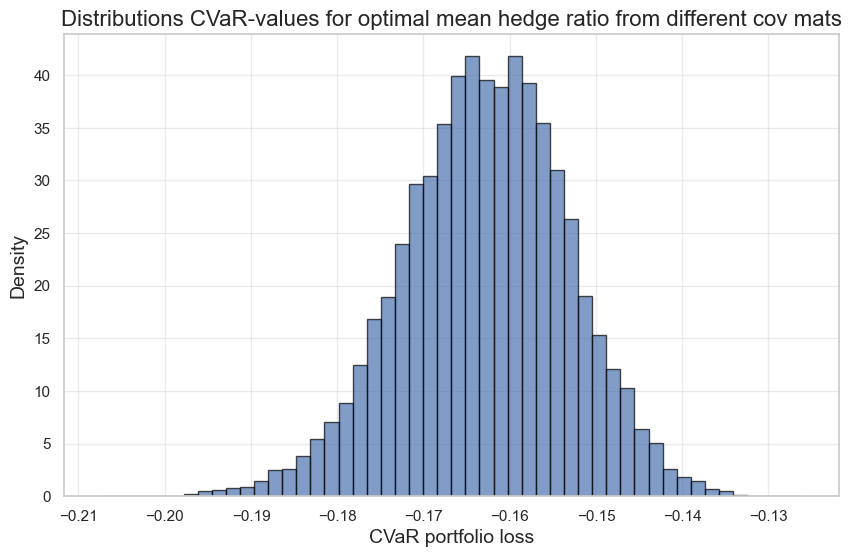

In [111]:
# CVAR values
plt.figure(figsize=(10, 6))
plt.hist(cvar_values, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.title("Distributions CVaR-values for optimal mean hedge ratio from different cov mats", fontsize=16)
plt.xlabel("CVaR portfolio loss", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(alpha=0.4)
plt.savefig("CVAR values covsim.png")
plt.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\4180097764.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sharpe_ratios, shade=True, color="blue", ax=ax)


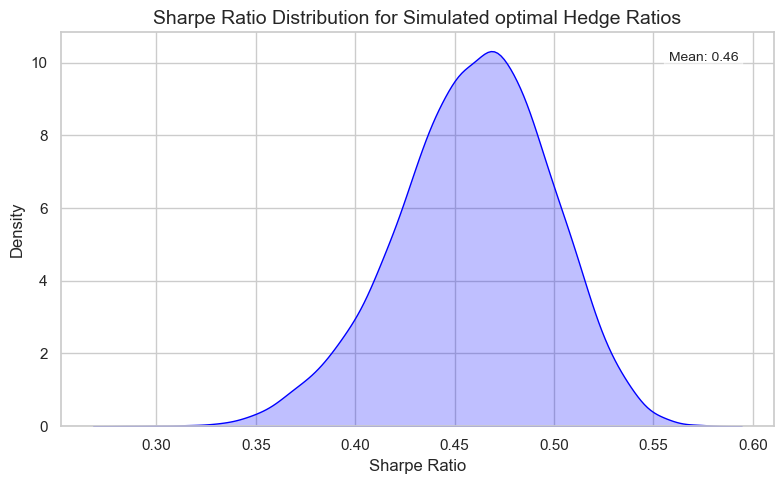

In [112]:
risk_free_rate =0.04 # just for fun
sharpe_ratios = (mu_port_pnl_sim - risk_free_rate) / sigma_port_pnl_sim  # Sharpe Ratio = Mean - riskfree_rate / Std Dev
mean_sim_sharpe_ratios= np.mean(sharpe_ratios)
# Plot Sharpe Ratio distribution
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(sharpe_ratios, shade=True, color="blue", ax=ax)

ax.set_xlabel("Sharpe Ratio", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Sharpe Ratio Distribution for Simulated optimal Hedge Ratios", fontsize=14)
ax.text(0.95, 0.95, f"Mean: {mean_sim_sharpe_ratios:.2}", transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Layout og visning
plt.tight_layout()
plt.grid(True)
plt.savefig("sharpe_ratio_pdf.png")
plt.show()

In [113]:
np.mean(pnl,axis=0)

array([-0.03950124,  0.17040498,  0.15579511,  0.0643778 ,  0.03755983])

In [114]:
print(pnl2_true_means)


[-0.04122320092750009, 0.1687674978170488, 0.15511893618277228, 0.06557194432981095, 0.03732679467592692]


In [115]:
print(sim_cov_matrix4_hat[0]) 

[[ 0.01096954 -0.0043043   0.00603892 -0.00903702  0.00016736]
 [-0.0043043   0.05750844  0.03615039  0.00245999  0.00100834]
 [ 0.00603892  0.03615039  0.0547963  -0.00511961  0.00141822]
 [-0.00903702  0.00245999 -0.00511961  0.008223    0.00034141]
 [ 0.00016736  0.00100834  0.00141822  0.00034141  0.00054271]]


C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\2966120911.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_cvar_port_pnl, shade=True, color="teal", ax=ax)


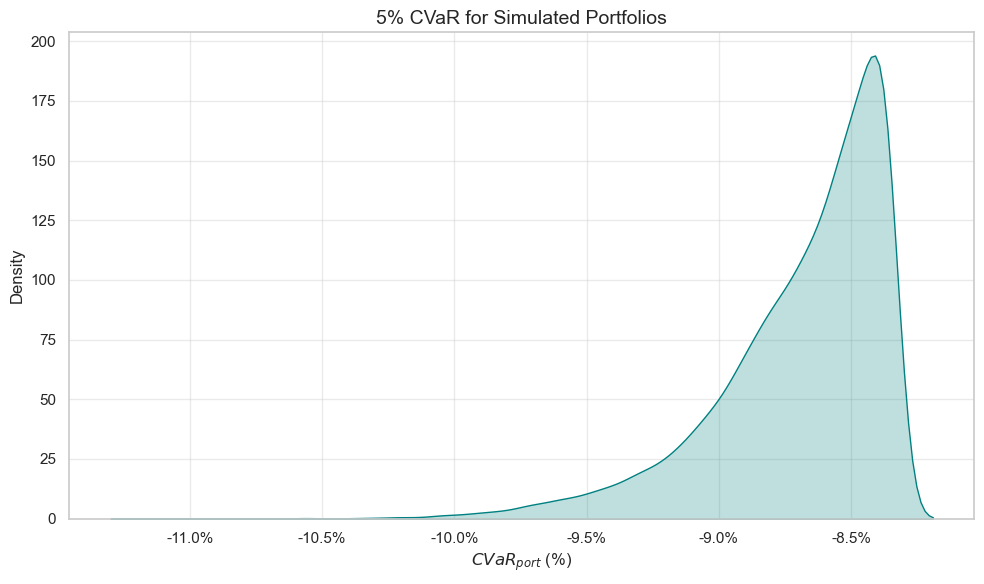

In [116]:
def conditional_value_at_risk(pnl, alpha):
    """Calculate the CVaR for a given PnL distribution and confidence level alpha."""
    VaR = np.percentile(pnl, alpha * 100)  # Value-at-Risk
    CVaR = np.mean(pnl[pnl <= VaR])  # Conditional Value-at-Risk
    return CVaR

sim_cvar_port_pnl = np.apply_along_axis(
    lambda x: conditional_value_at_risk(x @ pnllast.T, 0.05),  
    1,
    port_holdings_sim
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(sim_cvar_port_pnl, shade=True, color="teal", ax=ax)

ax.set_xlabel("$CVaR_{port}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("5% CVaR for Simulated Portfolios", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

plt.tight_layout()
plt.grid(alpha=0.4)
plt.savefig("Cvar_sim_sigmas.png")
plt.show()

In [117]:
print(f"Mean of PnL: {np.mean(pnllast, axis=0)}, Min of PnL: {np.min(pnl)}")


Mean of PnL: [-0.03950124  0.17040498  0.15579511  0.0643778   0.03755983], Min of PnL: -0.7734412547088511


In [118]:
def conditional_value_at_risk(pnl, alpha):
    """Calculate the CVaR for a given PnL distribution and confidence level alpha."""
    VaR = np.percentile(pnl, alpha * 100)  # Value-at-Risk
    CVaR = np.mean(pnl[pnl <= VaR])  # Conditional Value-at-Risk
    return CVaR

conditional_value_at_risk(sim_cvar_port_pnl*pnllast.T,0.05)

-0.04660127417743102

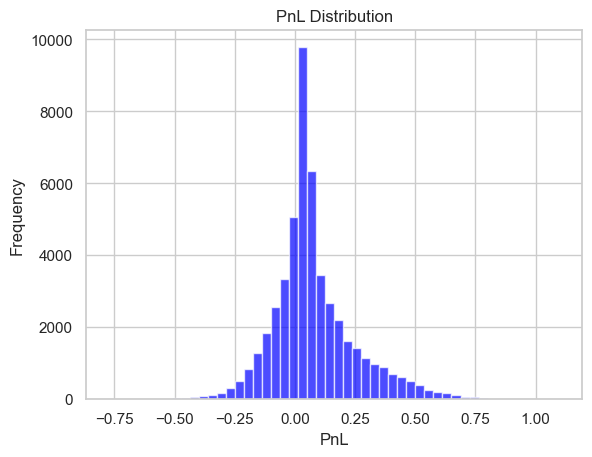

In [119]:
plt.hist(pnllast.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('PnL Distribution')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.show()

### All plots in one plot

<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\S'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\3569754506.py:9: SyntaxWarning: invalid escape sequence '\S'
  axes[0, 0].set_title("Hedge Ratios for simulated $\Sigma$-matrices", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\3569754506.py:19: SyntaxWarning: invalid escape sequence '\m'
  axes[0, 1].set_xlabel("$\mu_{PnL_2}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Loca

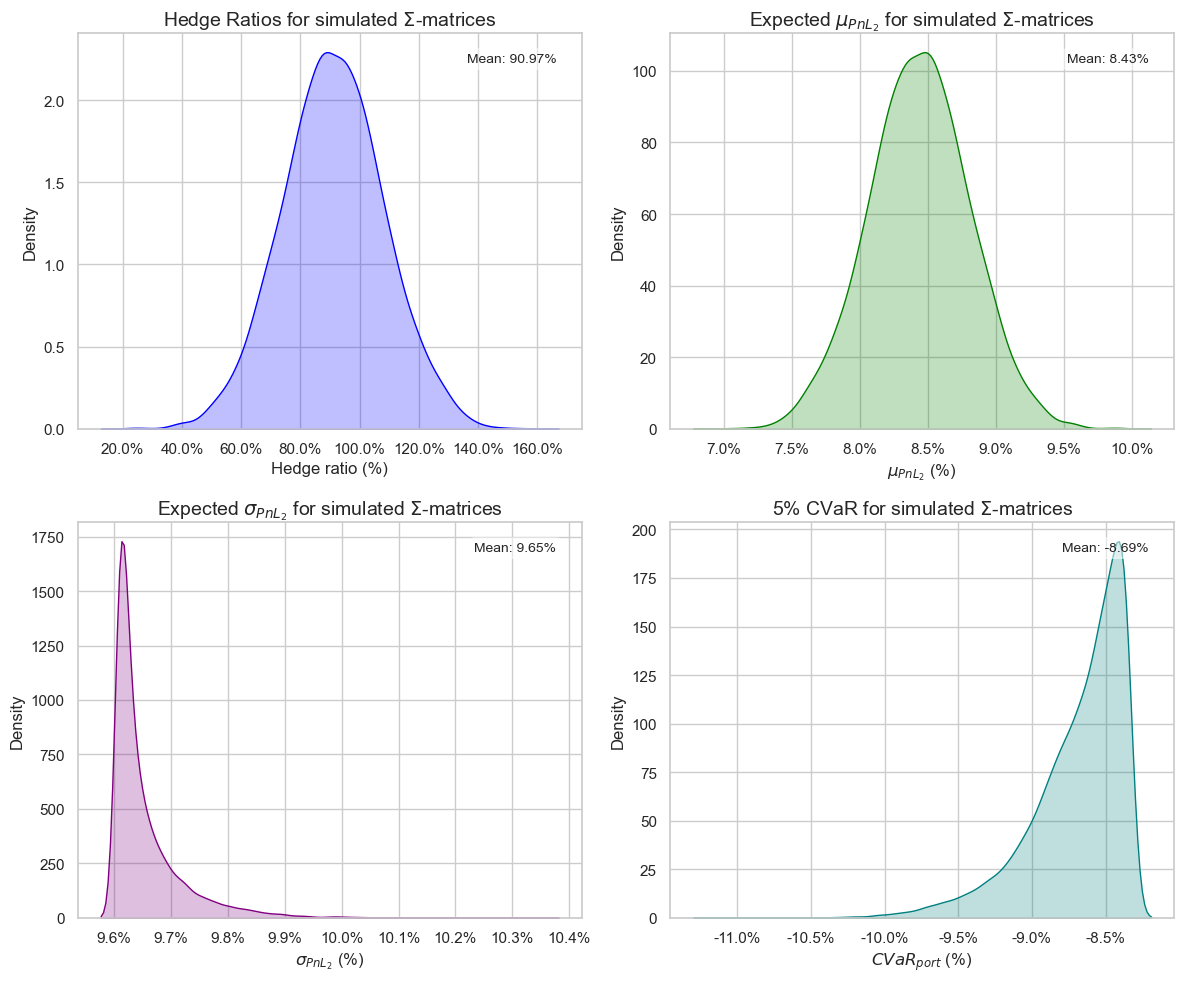

In [120]:
# 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Hedge Ratios
mean_hedge_ratios = np.mean(hedge_ratios)
sns.kdeplot(hedge_ratios, shade=True, color="blue", ax=axes[0, 0])
axes[0, 0].set_xlabel("Hedge ratio (%)", fontsize=12)
axes[0, 0].set_ylabel("Density", fontsize=12)
axes[0, 0].set_title("Hedge Ratios for simulated $\Sigma$-matrices", fontsize=14)
axes[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))
axes[0, 0].grid(True)
axes[0, 0].text(0.95, 0.95, f"Mean: {mean_hedge_ratios:.2%}", transform=axes[0, 0].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Plot 2: $\mu_{PnL_2}$
mean_mu_port_pnl_sim = np.mean(mu_port_pnl_sim)
sns.kdeplot(mu_port_pnl_sim, shade=True, color="green", ax=axes[0, 1])
axes[0, 1].set_xlabel("$\mu_{PnL_2}$ (%)", fontsize=12)
axes[0, 1].set_ylabel("Density", fontsize=12)
axes[0, 1].set_title("Expected $\mu_{PnL_2}$ for simulated $\Sigma$-matrices", fontsize=14)
axes[0, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))
axes[0, 1].grid(True)
axes[0, 1].text(0.95, 0.95, f"Mean: {mean_mu_port_pnl_sim:.2%}", transform=axes[0, 1].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Plot 3: $\sigma_{PnL_2}$
mean_sigma_port_pnl_sim = np.mean(sigma_port_pnl_sim)
sns.kdeplot(sigma_port_pnl_sim, shade=True, color="purple", ax=axes[1, 0])
axes[1, 0].set_xlabel("$\sigma_{PnL_2}$ (%)", fontsize=12)
axes[1, 0].set_ylabel("Density", fontsize=12)
axes[1, 0].set_title("Expected $\sigma_{PnL_2}$ for simulated $\Sigma$-matrices", fontsize=14)
axes[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))
axes[1, 0].grid(True)
axes[1, 0].text(0.95, 0.95, f"Mean: {mean_sigma_port_pnl_sim:.2%}", transform=axes[1, 0].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Plot 4: CVaR
mean_sim_cvar_port_pnl = np.mean(sim_cvar_port_pnl)
sns.kdeplot(sim_cvar_port_pnl, shade=True, color="teal", ax=axes[1, 1])
axes[1, 1].set_xlabel("$CVaR_{port}$ (%)", fontsize=12)
axes[1, 1].set_ylabel("Density", fontsize=12)
axes[1, 1].set_title("5% CVaR for simulated $\Sigma$-matrices", fontsize=14)
axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))
axes[1, 1].grid(True)
axes[1, 1].text(0.95, 0.95, f"Mean: {mean_sim_cvar_port_pnl:.2%}", transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

plt.tight_layout()

plt.savefig("combined_plot_sim_study.png")

# Vis figuren
plt.show()


In [121]:
print("Mean of optimal forwards: ", np.mean(optimal_forwards))
print("Mean of expected PnL: ", np.mean(mu_port_pnl_sim))

Mean of optimal forwards:  0.4806988135252065
Mean of expected PnL:  0.08432486591095212


# Part 4 - Portfolio optimization 


In [122]:
PnL_means, PnL_cov_matrix

([-0.0206601173981778,
  0.08198599360626171,
  0.07419134573538433,
  0.032351375181257254,
  0.018880747136756807],
 array([[ 5.24130698e-03, -3.85215533e-03, -2.66367231e-04,
         -4.01398646e-03,  5.87249870e-05],
        [-3.85215533e-03,  2.60536214e-02,  1.98550431e-02,
          2.43618805e-03,  5.61295410e-04],
        [-2.66367231e-04,  1.98550431e-02,  2.84326248e-02,
         -4.04594880e-04,  4.02083034e-04],
        [-4.01398646e-03,  2.43618805e-03, -4.04594880e-04,
          3.68003177e-03,  3.53201367e-04],
        [ 5.87249870e-05,  5.61295410e-04,  4.02083034e-04,
          3.53201367e-04,  5.08970551e-04]]))

In [123]:
prices_optim = np.append(0, prices)

#### Function to find optimal hedge contracts

In [124]:
def calculate_individual_and_total_hedges(cov_matrix: np.ndarray, weights: np.ndarray) -> (np.ndarray, float):
    """
    Calculate individual hedge ratios for each asset and the total hedge ratio for the portfolio.

    Parameters:
        cov_matrix (np.ndarray): Covariance matrix of PnL values.
        weights (np.ndarray): Portfolio weights for each asset (excluding the hedge).

    Returns:
        (np.ndarray, float): Individual hedge ratios and total portfolio hedge ratio.
    """
    sigma_pnl_12 = cov_matrix[0, 1:]

    sigma_pnl_11 = cov_matrix[0, 0]

    individual_hedges = -sigma_pnl_12 / sigma_pnl_11

    total_hedge = np.dot(individual_hedges, weights)

    return individual_hedges, total_hedge


### calculate_min_variance_with_target_return_fullscale

In [125]:
def calculate_min_variance_with_target_return_fullscale(cov_mat: np.ndarray, initial_market_values: np.ndarray, expected_returns: np.ndarray, target_return: float) -> np.ndarray:
    """
    Calculate the minimum-variance portfolio given a target return, respecting the constraints of calculate_min_variance_fullscale.
    
    Parameters:
        cov_mat (np.ndarray): Covariance matrix of asset returns.
        initial_market_values (np.ndarray): Initial market values for each asset.
        expected_returns (np.ndarray): Expected returns for each asset.
        target_return (float): The desired portfolio return.

    Returns:
        np.ndarray: Optimal weights for the minimum-variance portfolio with the target return.
    """
    # Number of assets
    n = len(initial_market_values)
    
    # Objective function: minimize portfolio variance
    def objective(weights):
        return weights.T @ cov_mat @ weights

    # Constraint: weights must sum to 1 (equilibrium constraint)
    def constraint_sum(weights):
        return np.sum(weights * initial_market_values) - 1.0

    # Constraint: portfolio return must match the target return
    def constraint_return(weights):
        return np.dot(weights, expected_returns) - target_return

    # Bounds for weights (all must be positive except for shorting)
    bounds = [(None, None)] + [(0, None) for _ in range(1, n)]

    # Initial guess for weights (calculate without the first asset)
    x0_without_first = initial_market_values[1:] / np.sum(initial_market_values[1:])
    x0 = np.concatenate([[0], x0_without_first])

    # Constraint definitions
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'eq', 'fun': constraint_return}
    ]

    # Optimization
    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    return result.x


C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


Minimum Variance Portfolio Weights: [0.14530516 0.00105224 0.01437155 0.20654414 0.90926066]


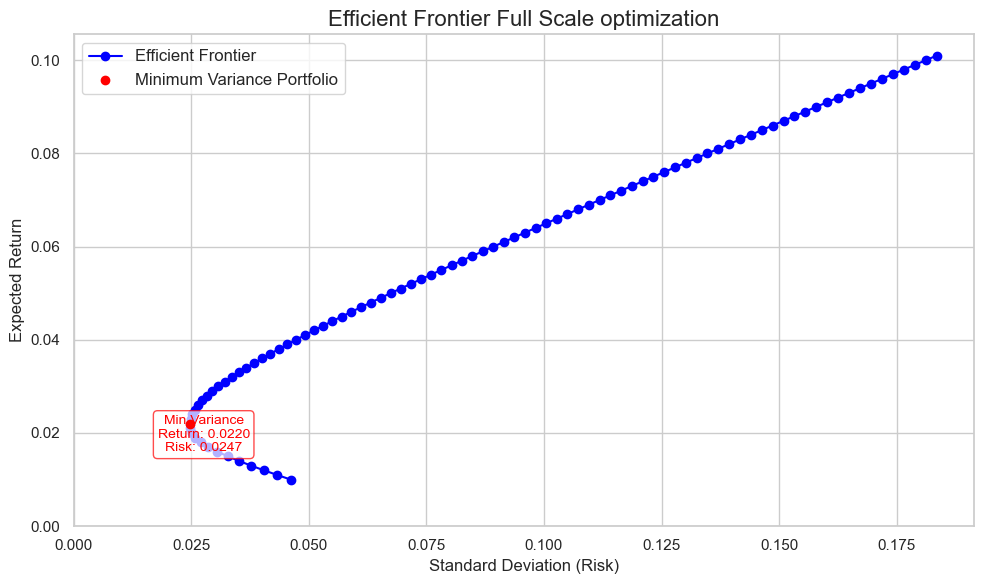

In [126]:

start_return = 0.01
end_return = 0.1
step = 0.001


results = []


weights_list = []

for target_return in np.arange(start_return, end_return + step, step):
    full_scale_optimal_weights = calculate_min_variance_with_target_return_fullscale(PnL_cov_matrix, prices_optim, PnL_means, target_return)
    
    min_var_port_return = full_scale_optimal_weights @ PnL_means
    min_var_port_std = np.sqrt(full_scale_optimal_weights.T @ PnL_cov_matrix @ full_scale_optimal_weights)
    
    results.append((min_var_port_std, min_var_port_return))
    weights_list.append(full_scale_optimal_weights)

results_array = np.array(results)

min_variance_index = np.argmin(results_array[:, 0])
min_variance_point = results_array[min_variance_index]
min_variance_weights = weights_list[min_variance_index]

print("Minimum Variance Portfolio Weights:", min_variance_weights)

efficient_frontier_fullscale = results_array  
min_variance_point_fullscale = min_variance_point  
min_variance_weights_fullscale = min_variance_weights  


plt.figure(figsize=(10, 6))
plt.plot(results_array[:, 0], results_array[:, 1], marker='o', label='Efficient Frontier', linestyle='-', color='blue')


plt.scatter(min_variance_point[0], min_variance_point[1], color='red', label='Minimum Variance Portfolio', zorder=5)


plt.annotate(
    f"Min Variance\nReturn: {min_variance_point[1]:.4f}\nRisk: {min_variance_point[0]:.4f}", 
    (min_variance_point[0], min_variance_point[1]), 
    textcoords="offset points", 
    xytext=(10, -20), 
    ha='center', 
    fontsize=10, 
    color='red',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.7)
)


plt.xlabel("Standard Deviation (Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Efficient Frontier Full Scale optimization", fontsize=16)

plt.xlim(0)  
plt.ylim(0)  

plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


In [127]:
def calculate_min_variance_with_target_return_two_steps(cov_mat: np.ndarray, initial_market_values: np.ndarray, 
                                                        expected_returns: np.ndarray, target_return: float) -> np.ndarray:
    """
    Calculate the minimum-variance portfolio given a target return and add hedge contracts at the end.
    
    Parameters:
        cov_mat (np.ndarray): Covariance matrix of asset returns.
        initial_market_values (np.ndarray): Initial market values for each asset.
        expected_returns (np.ndarray): Expected returns for each asset.
        target_return (float): The desired portfolio return.

    Returns:
        np.ndarray: Optimal weights for the minimum-variance portfolio with the target return.
    """
    # Remove the first asset to exclude the hedge component
    reduced_cov_mat = cov_mat[1:, 1:]
    reduced_initial_market_values = initial_market_values[1:]
    reduced_expected_returns = expected_returns[1:]

    # Number of remaining assets
    n = len(reduced_initial_market_values)
    # Bounds for weights (all must be positive)
    bounds = [(0, None) for _ in range(n)]
    # Objective function: minimize portfolio variance
    def objective(weights):
        return weights.T @ reduced_cov_mat @ weights

    # Constraint: weights must sum to 1 (no short selling)
    def constraint_sum(weights):
        return np.sum(weights * reduced_initial_market_values) - 1.0

    # Constraint: portfolio return must match the target return
    def constraint_return(weights):
        # Calculate the full portfolio including the hedge ratio
        return np.dot(weights, reduced_expected_returns) - target_return

    # Bounds for weights (all must be positive)
    bounds = [(0, None) for _ in range(n)]
    bounds = [(0, None), (0, None), (0, None), (0, None)]
    # Initial guess for weights (equal distribution)
    x0 = reduced_initial_market_values / np.sum(reduced_initial_market_values)

    # Constraint definitions
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'eq', 'fun': constraint_return}
    ]

    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)


    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")


    optimal_weights = result.x

 
    return optimal_weights


In [128]:

start_return = 0.01
end_return = 0.20
step = 0.001

valid_portfolios = []


for target_return in np.arange(start_return, end_return + step, step):

    acvb = calculate_min_variance_with_target_return_two_steps(PnL_cov_matrix, prices_optim, PnL_means, target_return)
    h1_two_steps = calculate_min_var_hedge_ratio_with_holdings(PnL_cov_matrix, acvb)
    two_steps_opt = np.append(h1_two_steps, acvb)

    if np.all(two_steps_opt[-4:] >= 0):
        portfolio_std = np.sqrt(two_steps_opt.T @ PnL_cov_matrix @ two_steps_opt)
        portfolio_return = two_steps_opt @ PnL_means
        valid_portfolios.append((portfolio_return, portfolio_std, two_steps_opt))

valid_portfolios_array = np.array(valid_portfolios, dtype=object)




C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


Minimum Risk Portfolio (weights): [0.01708319 0.00227736 0.00797834 0.03515409 1.06373339]


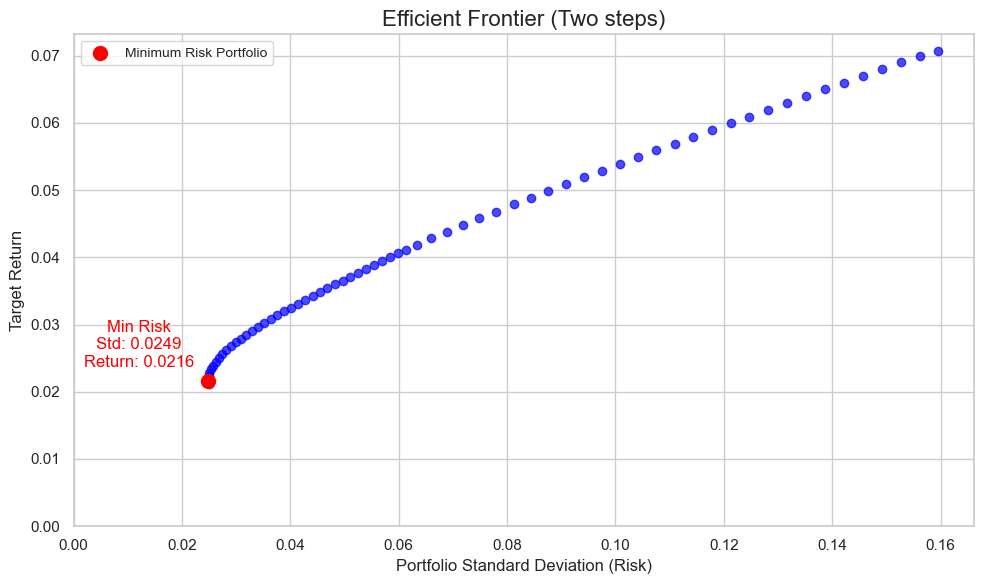

In [129]:

min_risk_portfolio = min(valid_portfolios, key=lambda x: x[1]) 
min_risk_std = min_risk_portfolio[1]
min_risk_return = min_risk_portfolio[0]


efficient_frontier_two_steps = np.array([(portfolio_std, portfolio_return) for portfolio_return, portfolio_std, _ in valid_portfolios])
min_variance_point_two_steps = (min_risk_std, min_risk_return)  
min_variance_weights_two_steps = min_risk_portfolio[2]  
print("Minimum Risk Portfolio (weights):", min_risk_portfolio[2])

plt.figure(figsize=(10, 6))

for target_return, portfolio_std, portfolio in valid_portfolios:
    plt.scatter(portfolio_std, target_return, color='blue', alpha=0.7)

plt.scatter(min_risk_std, min_risk_return, color='red', s=100, label="Minimum Risk Portfolio")
plt.annotate(f"Min Risk\nStd: {min_risk_std:.4f}\nReturn: {min_risk_return:.4f}",
             (min_risk_std, min_risk_return),
             textcoords="offset points", xytext=(-50, 10), ha='center', color='red')

plt.xlim(0)
plt.ylim(0)

plt.xlabel("Portfolio Standard Deviation (Risk)", fontsize=12)
plt.ylabel("Target Return", fontsize=12)
plt.title("Efficient Frontier (Two steps)", fontsize=16)

plt.grid(True)

plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


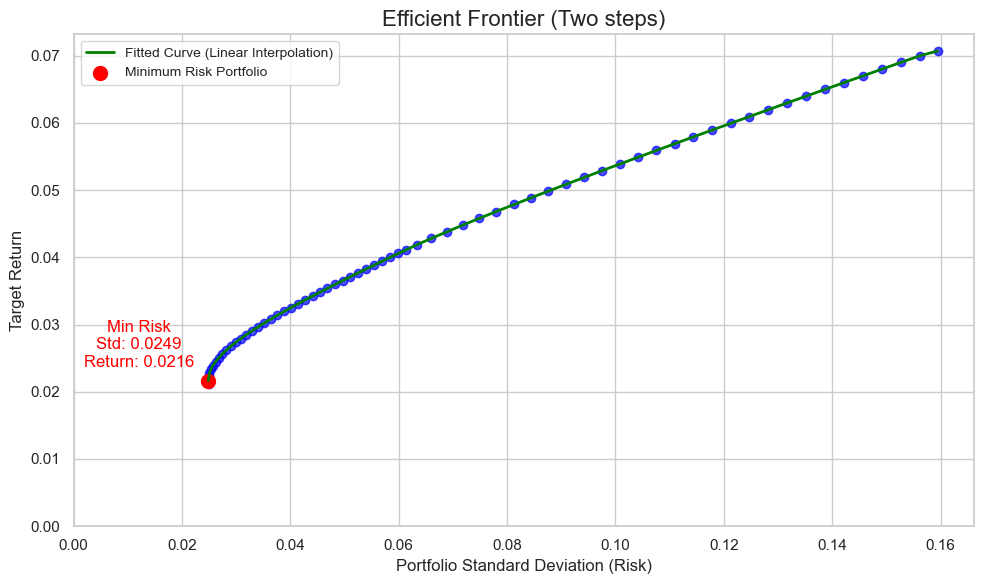

Minimum Variance Portfolio:
Standard Deviation (Risk): 0.0249
Target Return: 0.0216
Weights (including hedge ratio): [0.01708319 0.00227736 0.00797834 0.03515409 1.06373339]


In [130]:

std_values = np.array([portfolio_std for _, portfolio_std, _ in valid_portfolios])
return_values = np.array([target_return for target_return, _, _ in valid_portfolios])

sorted_indices = np.argsort(std_values)
std_values = std_values[sorted_indices]
return_values = return_values[sorted_indices]


interp_function = make_interp_spline(std_values, return_values, k=1)
std_fit = np.linspace(std_values.min(), std_values.max(), 500) 
return_fit = interp_function(std_fit)

plt.figure(figsize=(10, 6))


for target_return, portfolio_std, portfolio in valid_portfolios:
    plt.scatter(portfolio_std, target_return, color='blue', alpha=0.7)


plt.plot(std_fit, return_fit, color='green', linewidth=2, label="Fitted Curve (Linear Interpolation)")

plt.scatter(min_risk_std, min_risk_return, color='red', s=100, label="Minimum Risk Portfolio")
plt.annotate(f"Min Risk\nStd: {min_risk_std:.4f}\nReturn: {min_risk_return:.4f}",
             (min_risk_std, min_risk_return),
             textcoords="offset points", xytext=(-50, 10), ha='center', color='red')


plt.xlim(0)
plt.ylim(0)

plt.xlabel("Portfolio Standard Deviation (Risk)", fontsize=12)
plt.ylabel("Target Return", fontsize=12)
plt.title("Efficient Frontier (Two steps)", fontsize=16)

plt.grid(True)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.show()

print("Minimum Variance Portfolio:")
print(f"Standard Deviation (Risk): {min_risk_std:.4f}")
print(f"Target Return: {min_risk_return:.4f}")
min_var_portfolio = min(valid_portfolios, key=lambda x: x[1]) 
print(f"Weights (including hedge ratio): {min_var_portfolio[2]}")


## Individually with optimize hedge in the optimization

In [131]:
def calculate_min_variance_with_target_return_individually_hedges(
    cov_mat: np.ndarray, 
    initial_market_values: np.ndarray,
    expected_returns: np.ndarray, 
    target_return: float
) -> np.ndarray:
    """
    Calculate the minimum-variance portfolio given a target return and include hedge ratios directly in the optimization.
    
    Parameters:
        cov_mat (np.ndarray): Covariance matrix of asset returns.
        initial_market_values (np.ndarray): Initial market values for each asset.
        expected_returns (np.ndarray): Expected returns for each asset.
        target_return (float): The desired portfolio return.

    Returns:
        np.ndarray: Optimal weights for the minimum-variance portfolio with the target return.
    """
    # Number of assets (including hedge)
    n = len(initial_market_values)

    # Objective function: minimize portfolio variance
    def objective(weights):
        # Extract weights for the non-hedge assets
        asset_weights = weights[1:]  # Exclude hedge weight
        # Calculate individual hedge ratios
        individual_hedges = -cov_mat[0, 1:] / cov_mat[0, 0]
        # Calculate the total hedge ratio
        hedge_ratio = np.dot(individual_hedges, asset_weights)
        # Full weight vector (including hedge)
        full_weights = np.concatenate([[hedge_ratio], asset_weights])
        # Calculate portfolio variance
        return full_weights.T @ cov_mat @ full_weights

    # Constraint: weights must sum to 1 (only for assets, not the hedge)
    def constraint_sum(weights):
        asset_weights = weights[1:]  # Exclude hedge weight
        return np.sum(asset_weights * initial_market_values[1:]) - 1.0

    # Constraint: portfolio return must match the target return
    def constraint_return(weights):
        # Extract weights for the non-hedge assets
        asset_weights = weights[1:]
        # Calculate individual hedge ratios
        individual_hedges = -cov_mat[0, 1:] / cov_mat[0, 0]
        # Calculate the total hedge ratio
        hedge_ratio = np.dot(individual_hedges, asset_weights)
        # Full weight vector (including hedge)
        full_weights = np.concatenate([[hedge_ratio], asset_weights])
        # Calculate portfolio return
        return np.dot(full_weights, expected_returns) - target_return

    # Bounds for weights (only for non-hedge assets)
    bounds = [(0, None)] + [(0, None) for _ in range(1, n)]

    # Initial guess for weights (equal distribution for non-hedge assets, zero hedge)
    x0 = np.concatenate([[0], initial_market_values[1:] / np.sum(initial_market_values[1:])])

    # Constraint definitions
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'eq', 'fun': constraint_return}
    ]

    # Optimization
    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)

    # Check if the optimization was successful
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    # Extract optimized weights
    optimized_weights = result.x
    asset_weights = optimized_weights[1:]

    # Calculate individual hedge ratios
    individual_hedges = -cov_mat[0, 1:] / cov_mat[0, 0]
    # Calculate the total hedge ratio
    total_hedge = np.dot(individual_hedges, asset_weights)

    # Return full weights including hedge ratio
    return np.concatenate([[total_hedge], asset_weights])


In [132]:
start_return = 0.01
end_return = 0.20
step = 0.001

valid_portfolios = []

for target_return in np.arange(start_return, end_return + step, step):


    # Calculate the total hedge ratio
    acvb = calculate_min_variance_with_target_return_individually_hedges(PnL_cov_matrix, prices_optim, PnL_means, target_return)


    if np.all(acvb[-4:] >= 0):
        portfolio_std = np.sqrt(acvb.T @ PnL_cov_matrix @ acvb)
        portfolio_return = acvb @ PnL_means
        valid_portfolios.append((portfolio_return, portfolio_std, acvb))

valid_portfolios_array = np.array(valid_portfolios, dtype=object)

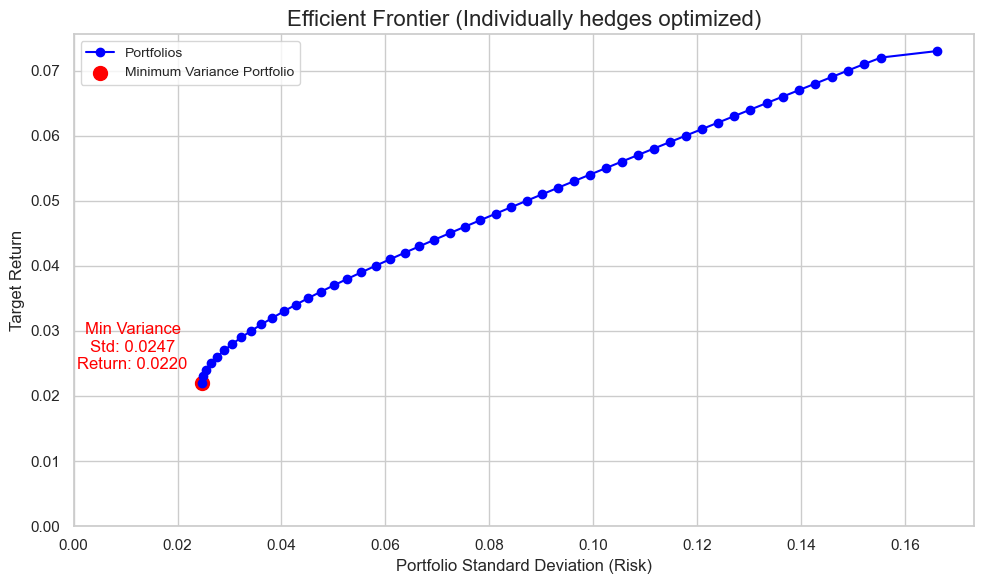

Minimum Variance Portfolio:
Standard Deviation (Risk): 0.0247
Target Return: 0.0220
Weights (including hedge ratio): [0.15441101 0.00186511 0.01530974 0.21202342 0.90261985]


In [133]:
min_var_portfolio = min(valid_portfolios, key=lambda x: x[1])  
min_var_std = min_var_portfolio[1]
min_var_return = min_var_portfolio[0]

efficient_frontier_individual_hedges = np.array([(portfolio_std, target_return) for target_return, portfolio_std, _ in valid_portfolios])
min_variance_point_individual_hedges = (min_var_std, min_var_return) 
min_variance_weights_individual_hedges = min_var_portfolio[2]  


plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier_individual_hedges[:, 0], efficient_frontier_individual_hedges[:, 1], marker='o', linestyle='-', color='blue', label='Portfolios')


plt.scatter(min_var_std, min_var_return, color='red', s=100, label="Minimum Variance Portfolio")
plt.annotate(f"Min Variance\nStd: {min_var_std:.4f}\nReturn: {min_var_return:.4f}",
             (min_var_std, min_var_return),
             textcoords="offset points", xytext=(-50, 10), ha='center', color='red')

plt.xlim(0)
plt.ylim(0)

plt.xlabel("Portfolio Standard Deviation (Risk)", fontsize=12)
plt.ylabel("Target Return", fontsize=12)
plt.title("Efficient Frontier (Individually hedges optimized)", fontsize=16)

plt.grid(True)

plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("Minimum Variance Portfolio:")
print(f"Standard Deviation (Risk): {min_var_std:.4f}")
print(f"Target Return: {min_var_return:.4f}")
print(f"Weights (including hedge ratio): {min_var_portfolio[2]}")

### All methods in one plot

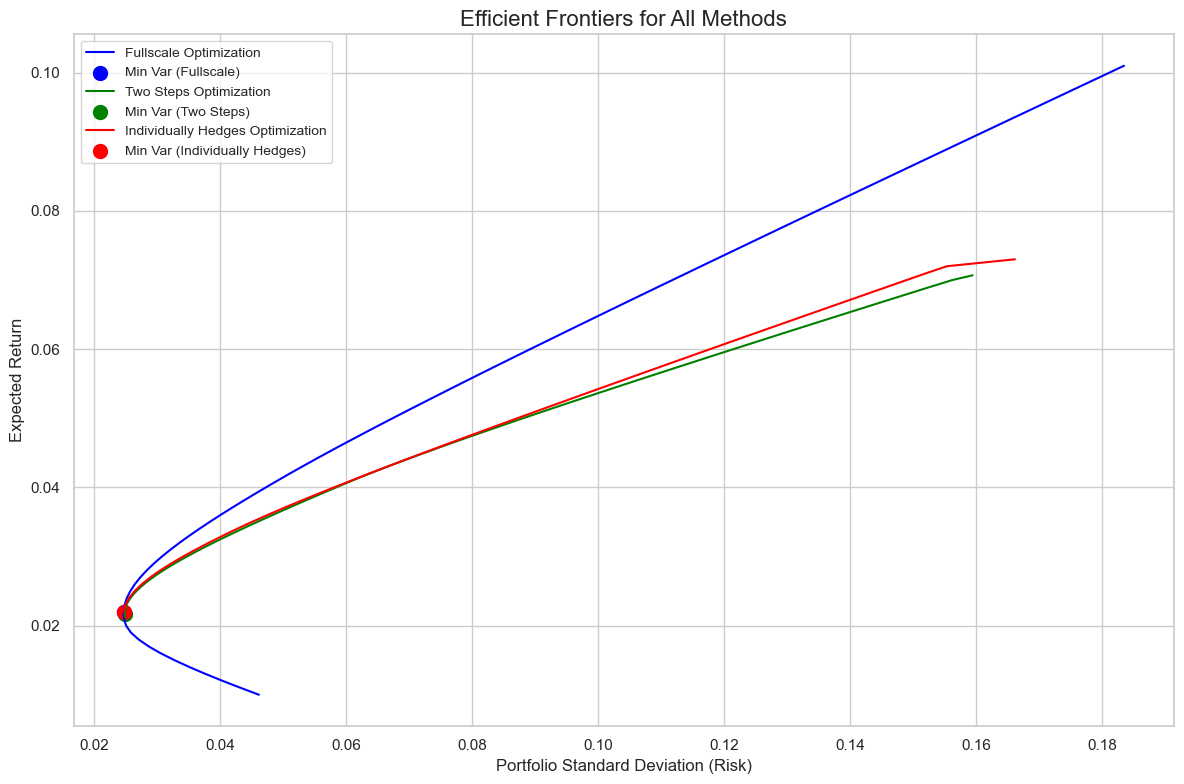

In [134]:
plt.figure(figsize=(12, 8))

plt.plot(
    efficient_frontier_fullscale[:, 0],  # Standard deviation (risk)
    efficient_frontier_fullscale[:, 1],  # Expected return
    label="Fullscale Optimization", color='blue'
)
plt.scatter(
    min_variance_point_fullscale[0], min_variance_point_fullscale[1],
    color='blue', s=100, label="Min Var (Fullscale)"
)

plt.plot(
    efficient_frontier_two_steps[:, 0],  # Standard deviation (risk)
    efficient_frontier_two_steps[:, 1],  # Expected return
    label="Two Steps Optimization", color='green'
)
plt.scatter(
    min_variance_point_two_steps[0], min_variance_point_two_steps[1],
    color='green', s=100, label="Min Var (Two Steps)"
)

plt.plot(
    efficient_frontier_individual_hedges[:, 0],  # Standard deviation (risk)
    efficient_frontier_individual_hedges[:, 1],  # Expected return
    label="Individually Hedges Optimization", color='red'
)
plt.scatter(
    min_variance_point_individual_hedges[0], min_variance_point_individual_hedges[1],
    color='red', s=100, label="Min Var (Individually Hedges)"
)

plt.xlabel("Portfolio Standard Deviation (Risk)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Efficient Frontiers for All Methods", fontsize=16)

plt.grid(True)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig("Efficient Frontiers for All Methods.png")
plt.show()


# Minimum Variance portfolios for all 3 types 

In [135]:
def calculate_min_variance_fullscale(cov_mat: np.ndarray, initial_market_values: np.ndarray) -> np.ndarray:
    # Number of assets
    n = len(initial_market_values)
    
    # Objective function: minimize portfolio variance
    def objective(weights):
        return weights.T @ cov_mat @ weights

    # Constraint: weights must sum to 1 (equilibrium constraint)
    def constraint_sum(weights):
        return np.sum(weights * initial_market_values) - 1.0

    # Bounds for weights (all must be positive except for shorting)
    bounds = [(None, None)] + [(0, None) for _ in range(1, n)]
    # bounds = [(0, None) for _ in range(n)]  # all must be positive

    # Initial guess for weights (equal distribution)
    # Calculate weights without the first asset
    x0_without_first = initial_market_values[1:] / np.sum(initial_market_values[1:])
    # x0_without_first = initial_market_values / np.sum(initial_market_values)

    # Add zero in front
    x0 = np.concatenate([[0], x0_without_first])

    # Constraint definition
    constraints = [{'type': 'eq', 'fun': constraint_sum}]

    # Optimization
    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)

    return result.x

def calculate_min_variance_with_two_steps(cov_mat: np.ndarray, initial_market_values: np.ndarray) -> np.ndarray:
    """
    Calculate the minimum-variance portfolio and add the hedge contracts at the end.
    """
    # Remove the first asset to exclude the hedge component
    reduced_cov_mat = cov_mat[1:, 1:]
    reduced_initial_market_values = initial_market_values[1:]

    # Number of remaining assets
    n = len(reduced_initial_market_values)
    
    # Objective function: minimize portfolio variance
    def objective(weights):
        return weights.T @ reduced_cov_mat @ weights

    # Constraint: weights must sum to 1 (no short selling)
    def constraint_sum(weights):
        return np.sum(weights * reduced_initial_market_values) - 1.0

    # Bounds for weights (all must be positive)
    bounds = [(0, None) for _ in range(n)]

    # Initial guess for weights (equal distribution)
    x0 = reduced_initial_market_values / np.sum(reduced_initial_market_values)

    # Constraint definition
    constraints = [{'type': 'eq', 'fun': constraint_sum}]

    # Optimization
    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)

    optimal_weights = result.x

    # Calculate hedge ratio
    h1 = calculate_min_var_hedge_ratio_with_holdings(PnL_cov_matrix, result.x)
    done = np.append(h1, optimal_weights)
    return done

def calculate_min_variance_with_individual_hedges(cov_mat: np.ndarray, initial_market_values: np.ndarray) -> np.ndarray:
    """
    Calculate the minimum-variance portfolio and add the hedge contracts at the end.
    """
    # Remove the first asset to exclude the hedge component
    reduced_cov_mat = cov_mat[1:, 1:]
    reduced_initial_market_values = initial_market_values[1:]

    # Number of remaining assets
    n = len(initial_market_values)
    
    # Objective function: minimize portfolio variance
    def objective(weights):
        # Extract weights for the non-hedge assets
        asset_weights = weights[1:]  # Exclude hedge weight
        # Calculate individual hedge ratios
        individual_hedges = -cov_mat[0, 1:] / cov_mat[0, 0]
        # Calculate the total hedge ratio
        hedge_ratio = np.dot(individual_hedges, asset_weights)
        # Full weight vector (including hedge)
        full_weights = np.concatenate([[hedge_ratio], asset_weights])
        # Calculate portfolio variance
        return full_weights.T @ cov_mat @ full_weights

    # Constraint: weights must sum to 1 (no short selling)
    def constraint_sum(weights):
        asset_weights = weights[1:]  # Exclude hedge weight
        return np.sum(asset_weights * initial_market_values[1:]) - 1.0

    # Bounds for weights (all must be positive)
    bounds = [(0, None)] + [(0, None) for _ in range(1, n)]

    # Initial guess for weights (equal distribution)
    x0 = np.concatenate([[0], initial_market_values[1:] / np.sum(initial_market_values[1:])])

    # Constraint definition
    constraints = [{'type': 'eq', 'fun': constraint_sum}]

    # Optimization
    result = minimize(objective, x0, method='trust-constr', bounds=bounds, constraints=constraints)

    # Define individual assets for hedge ratio calculation
    optimized_weights = result.x
    asset_weights = optimized_weights[1:]

    individual_hedges = -cov_mat[0, 1:] / cov_mat[0, 0]
    total_hedge = np.dot(individual_hedges, asset_weights)
    
    # Return full weights including hedge ratio
    return np.concatenate([[total_hedge], asset_weights])


#### Full-scale minimum variance portfolio

In [136]:
full_scale = calculate_min_variance_fullscale(PnL_cov_matrix, prices_optim)
print(f"full_scale portfolio: {[f'{value:.5f}' for value in full_scale]}")
print(np.sum(full_scale*prices_optim))
min_var_port_return = full_scale @ PnL_means

min_var_port_std = np.sqrt(full_scale.T @ PnL_cov_matrix @ full_scale)
print(f"Port return of minimum variance portfolio: {min_var_port_return}")
print(f"Standard deviation (std) of minimum variance portfolio: {min_var_port_std}")

full_scale portfolio: ['0.14255', '0.00024', '0.01250', '0.19852', '0.91914']
1.0000000000151348
Port return of minimum variance portfolio: 0.02177849844288982
Standard deviation (std) of minimum variance portfolio: 0.024691840069570068


#### Two steps minimum variance portfolio

In [137]:
two_steps =calculate_min_variance_with_two_steps(PnL_cov_matrix,prices_optim)
print(f"Two Steps portfolio: {[f'{value:.5f}' for value in two_steps]}")
print(np.sum(two_steps*prices_optim))
min_var_port_return = two_steps @ PnL_means

min_var_port_std = np.sqrt(two_steps.T @ PnL_cov_matrix @ two_steps)
print(f"Port return of minimum variance portfolio: {min_var_port_return}")
print(f"Standard deviation (std) of minimum variance portfolio: {min_var_port_std}")

Two Steps portfolio: ['0.01549', '0.00281', '0.00718', '0.03266', '1.06622']
1.0000000000356075
Port return of minimum variance portfolio: 0.021630643181026494
Standard deviation (std) of minimum variance portfolio: 0.024862173278651558


#### Individual hedges minimum variance portfolio

In [138]:
individual_hedges =calculate_min_variance_with_individual_hedges(PnL_cov_matrix,prices_optim)
print(f"individual hedges portfolio: {[f'{value:.5f}' for value in individual_hedges]}")
print(np.sum(individual_hedges*prices_optim))
min_var_port_return = individual_hedges @ PnL_means

min_var_port_std = np.sqrt(individual_hedges.T @ PnL_cov_matrix @ individual_hedges)
print(f"Port return of minimum variance portfolio: {min_var_port_return}")
print(f"Standard deviation (std) of minimum variance portfolio: {min_var_port_std}")

individual hedges portfolio: ['0.14256', '0.00035', '0.01241', '0.19844', '0.91919']
0.9999999999728342
Port return of minimum variance portfolio: 0.02177908679480388
Standard deviation (std) of minimum variance portfolio: 0.024692400556893382


# Part 5:  Perform a simulation study that examines the effect of estimation uncertainty 

We will just be using the same setup as in out other simulation setup, just for a 1 year sample of the market invariants

In [139]:
num_steps2 = 52 * 1 #2 years
num_simulations_cov = 10000 #10.000 simulation as usual
t_horizon = 1

np.random.seed(2000)  # Ensure reproducibility
sim_cov_matrix_hat = stats.wishart.rvs(df = num_steps2 - 1, scale = reduced_cov_matrix, size = num_simulations_cov)
#sim_cov_matrix_hat is already at the horizon (2 years)

#A little smarter to use when we will calculate the bond price for 10.000 cov_matrices
bond_matrix = np.diag([1.0, 1.0, 1.0, -(5.0 - t_horizon), -(5.0 - t_horizon)])

#Keeping mu fixed (we will just use the analytical values)
mu_fixed = reduced_mu * num_steps2 + reduced_x0
true_cov_matrix = reduced_cov_matrix * num_steps2

#We need to transform to prices (the bond prices for both the Sigma-matrices and the fixed mu)
sim_cov_matrix_hat = np.array([bond_matrix @ sim_cov_matrix_hat[i] @ bond_matrix.T for i in range(num_simulations_cov)])
mu_fixed_new = mu_fixed  @ bond_matrix.T
true_cov_matrix_new = bond_matrix @ true_cov_matrix @ bond_matrix.T


#We now need to transform into domestric currency, both covariance and also the fixed mu 
sim_cov_matrix2_hat = np.array([weight_matrix @ sim_cov_matrix_hat[i] @ weight_matrix.T for i in range(num_simulations_cov)])
mu_fixed2_new = mu_fixed_new  @ weight_matrix.T
true_cov_matrix2_new = weight_matrix @ true_cov_matrix_new @ weight_matrix.T

#Transform to P2_EUR_cov_matrix
sim_cov_matrix_exp =  np.array([compute_exp_cov_matrix(mu_fixed2_new, sim_cov_matrix2_hat[i]) for i in range(num_simulations_cov)]) #We are keeping mu_fixed (only using one mu, the fixed true analytical)
mu_fixed_exp = compute_exp_mean_from_log(mu_fixed2_new, true_cov_matrix2_new) #The fixed P2_mu vector
true_cov_matrix_exp = compute_exp_cov_matrix(mu_fixed2_new, true_cov_matrix2_new) #The true covariance-matrix
sim_cov_matrix3_mean = np.mean(sim_cov_matrix_exp, axis = 0)

#For the final PnL cov-matrix
sim_cov_matrix4_hat = np.zeros_like(sim_cov_matrix_exp)


#Multipliing (-1) in 1. row and colum (not the diagonal) because of: - 1/FX_2
for i in range(num_simulations_cov):
    matrix = sim_cov_matrix_exp[i]  
    matrix[0, 1:] *= -1  
    matrix[1:, 0] *= -1 
    sim_cov_matrix4_hat[i] = matrix

true_cov_matrix_exp[0, 1:] *= -1
true_cov_matrix_exp[1:, 0] *= -1 

sim_cov_matrix4_mean = np.mean(sim_cov_matrix4_hat, axis=0)
#And now for the PnL, here we only need to be aware of 1/FX_1, as it is -1 * 1/FX_1, so we multiply -1 to first row and column but not the diagonal

# Printing to check
print("Mu_fixed P1_mu:")
print(mu_fixed_exp)

print("")

print("Mean of simulated covariance matrices (sim_cov_matrix_exp), this is the P1_EUR_cov_matrix:")
print(sim_cov_matrix3_mean)

print("")

print("Mean of simulated covariance matrices (sim_cov_matrix4_hat), this is the PNL_1_cov_matrix:")
print(sim_cov_matrix4_mean)

print("")
print("The true PnL_1 cov-matrix: ")
print(true_cov_matrix_exp)


forward_price = fx_linear * np.exp(rate_differential*1) #Here we assume that is the same formula but we multiply with 2

#PnL based on true mu
pnl1_true_means = [
    1 / forward_price - mu_fixed_exp[0],                  # PNL1_FX
    mu_fixed_exp[1] - V0_US,                             # PNL2_VUS
    mu_fixed_exp[2] - V0_EUR,                            # PNL3_VEUR
    mu_fixed_exp[3] - Z0_USD_Y_price_eur,                # PNL4_ZUSD
    mu_fixed_exp[4] - Z0_EUR_Y_price                     # PNL5_ZEUR
]
print("")
print("True PnL_1 means:")
print(pnl1_true_means)



print(sim_cov_matrix4_hat.shape)




Mu_fixed P1_mu:
[0.94898668 1.02713139 1.0747646  0.81696097 0.92321988]

Mean of simulated covariance matrices (sim_cov_matrix_exp), this is the P1_EUR_cov_matrix:
[[ 5.18497177e-03  3.67571431e-03  2.10754625e-04  3.96031415e-03
  -7.04114249e-05]
 [ 3.67571431e-03  2.53391898e-02  1.94375939e-02  2.34592824e-03
   5.43617199e-04]
 [ 2.10754625e-04  1.94375939e-02  2.79022060e-02 -4.30278359e-04
   3.63758477e-04]
 [ 3.96031415e-03  2.34592824e-03 -4.30278359e-04  3.61575053e-03
   3.41527788e-04]
 [-7.04114249e-05  5.43617199e-04  3.63758477e-04  3.41527788e-04
   5.04486017e-04]]

Mean of simulated covariance matrices (sim_cov_matrix4_hat), this is the PNL_1_cov_matrix:
[[ 5.18497177e-03 -3.67571431e-03 -2.10754625e-04 -3.96031415e-03
   7.04114249e-05]
 [-3.67571431e-03  2.53391898e-02  1.94375939e-02  2.34592824e-03
   5.43617199e-04]
 [-2.10754625e-04  1.94375939e-02  2.79022060e-02 -4.30278359e-04
   3.63758477e-04]
 [-3.96031415e-03  2.34592824e-03 -4.30278359e-04  3.61575053e

Now finding 10.000 different minimum variance portfolios, where we find them for each new covariance-matrix and plotting them by using the true covariance-matrix and mu for PnL_1

In [140]:
#We hvae the true cov and mu:
print("The true PnL_1 cov-matrix:")
true_cov_matrix_exp_df = pd.DataFrame(true_cov_matrix_exp, columns=indices_to_keep, index=indices_to_keep)
print(cov_hor_exp_dom_df)
print("True PnL_1 means")
pnl1_true_means_df = pd.DataFrame(pnl1_true_means, index=indices_to_keep, columns=["True mu_PnL_1"])
print(pnl1_true_means_df)


The true PnL_1 cov-matrix:
          0         1         2         12        6 
0   0.005297 -0.003776 -0.000250 -0.004049  0.000071
1  -0.003776  0.025762  0.019733  0.002407  0.000545
2  -0.000250  0.019733  0.028299 -0.000414  0.000368
12 -0.004049  0.002407 -0.000414  0.003699  0.000349
6   0.000071  0.000545  0.000368  0.000349  0.000514
True PnL_1 means
    True mu_PnL_1
0       -0.020779
1        0.080923
2        0.074765
12       0.032168
6        0.018596


In [141]:
sim_cov_matrix4_hat[0]

array([[ 0.00544194, -0.00119318,  0.00408066, -0.00421572,  0.00012417],
       [-0.00119318,  0.02101941,  0.0121993 ,  0.00028802,  0.00056553],
       [ 0.00408066,  0.0121993 ,  0.02397866, -0.00293659,  0.00105529],
       [-0.00421572,  0.00028802, -0.00293659,  0.00393993,  0.00032745],
       [ 0.00012417,  0.00056553,  0.00105529,  0.00032745,  0.00048488]])

In [142]:
sim_cov_matrix4_hat[1]

array([[ 4.71451800e-03, -1.61867752e-03,  1.61268298e-04,
        -3.55411348e-03,  1.90528997e-05],
       [-1.61867752e-03,  2.06660776e-02,  1.87564521e-02,
         8.76545990e-04,  5.45873762e-04],
       [ 1.61268298e-04,  1.87564521e-02,  2.49496653e-02,
        -5.19831592e-04,  4.67611200e-04],
       [-3.55411348e-03,  8.76545990e-04, -5.19831592e-04,
         3.23020495e-03,  2.78944610e-04],
       [ 1.90528997e-05,  5.45873762e-04,  4.67611200e-04,
         2.78944610e-04,  3.16870494e-04]])

## Strategy 1: Minimum variance portfolio using pre-specified hedge ratios.

In [143]:
#Initial tests
indv_hedge0 = calculate_min_variance_with_individual_hedges(sim_cov_matrix4_hat[0], prices_optim)
indv_hedge1 = calculate_min_variance_with_individual_hedges(sim_cov_matrix4_hat[1], prices_optim)
print(indv_hedge0)
print(indv_hedge1)
true_port_indv = calculate_min_variance_with_individual_hedges(true_cov_matrix_exp, prices_optim)
print(true_port_indv)
#Nor we just need to set it up as a loop

C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


[-7.80793739e-03  1.65275387e-03  5.14430624e-04  2.18845654e-02
  1.08414934e+00]
[2.23044855e-03 8.16066625e-04 1.26463025e-03 8.51871312e-03
 1.09579054e+00]
[1.42991431e-01 2.14667914e-04 1.39581840e-02 2.02018597e-01
 9.14519756e-01]


In [144]:
optimal_ports_individuals = []

# Calculate the global minimum portfolio for each covariance for the first strategy
#Takes a long time to run, so be careful what you wish for
for i in range(num_simulations_cov):
    optimal_port_indv = calculate_min_variance_with_individual_hedges(sim_cov_matrix4_hat[i], prices_optim)
    
    optimal_ports_individuals.append(optimal_port_indv)

In [145]:
#Average weights: 
weights1 = np.mean(optimal_ports_individuals, axis = 0)
print(weights1)

[0.17939581 0.00597256 0.01514356 0.24405551 0.87071832]


In [146]:
negative_weights = []

for idx, weights in enumerate(optimal_ports_individuals):
    negative_values = weights[1:4] < 0
  
    if any(negative_values):
        negative_weights.append((idx, weights[1:4], negative_values))

if negative_weights:
    for item in negative_weights:
        print(f"Array index {item[0]} has negative weights: {item[1]} (negative: {item[2]})")
else:
    print("No negative values found in weights 1-4")

No negative values found in weights 1-4


In [147]:
#Calculating the risk by using the true covariance-matrix: true_cov_matrix_exp
sigma2_optimal_ports_individuals_sim = np.apply_along_axis(lambda x: x @ true_cov_matrix_exp @ x, 1, optimal_ports_individuals)
sigma_optimal_ports_individuals_sim = np.sqrt(sigma2_optimal_ports_individuals_sim)
sigma_optimal_ports_individuals_sim

array([0.02501281, 0.02502414, 0.02484983, ..., 0.02586221, 0.02549616,
       0.02870292])

In [148]:
np.mean(sigma_optimal_ports_individuals_sim) #The other: 0.025460407276821306

0.025461017724578896

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\73299112.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\73299112.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Individual strategy)", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\73299112.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_optimal_ports_individuals_sim, shade=True, color="green", ax=ax)


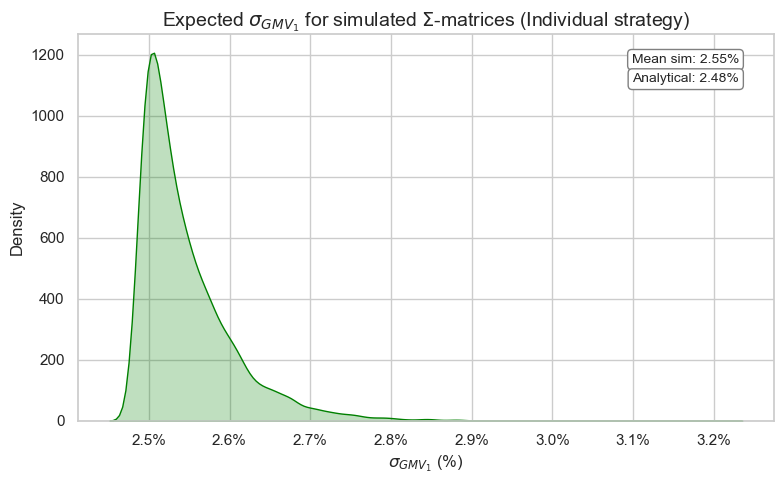

In [149]:
# Plot for sigma_port_pnl_sim
mean_value_indv = np.mean(sigma_optimal_ports_individuals_sim)
true_port_sigma2_indv = true_port_indv @ true_cov_matrix_exp @ true_port_indv
true_port_sigma_indv = np.sqrt(true_port_sigma2_indv)

fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(sigma_optimal_ports_individuals_sim, shade=True, color="green", ax=ax)

ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Individual strategy)", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white")

ax.text(0.95, 0.95, f"Mean sim: {mean_value_indv:.2%}", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)


ax.text(0.95, 0.90, f"Analytical: {true_port_sigma_indv:.2%}",
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)

plt.tight_layout()
plt.grid(True)
plt.savefig("sigma_optimal_ports_indi.png")
plt.show()


## Stretagy 2: Minimum variance portfolio using two steps hedge ratios.

In [150]:
#Initial tests
twostep_hedge0 = calculate_min_variance_with_two_steps(sim_cov_matrix4_hat[0], prices_optim)
twostep_hedge1 = calculate_min_variance_with_two_steps(sim_cov_matrix4_hat[1], prices_optim)
print(twostep_hedge0)
print(twostep_hedge1)
true_port_twostep = calculate_min_variance_with_two_steps(true_cov_matrix_exp, prices_optim)
print(true_port_twostep)
#Nor we just need to set it up as a loop

[0.01733641 0.00397291 0.00136579 0.03438708 1.06993502]
[6.72598411e-04 2.22241267e-03 3.08724216e-03 1.44458621e-02
 1.08716276e+00]
[0.01727692 0.00283751 0.00813144 0.03485212 1.06324022]


C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [151]:
optimal_ports_twosteps = []

# Calculate the global minimum portfolio for each covariance for the first strategy
#Takes a long time to run, so be careful what you wish for
for i in range(num_simulations_cov):
    optimal_port_two = calculate_min_variance_with_two_steps(sim_cov_matrix4_hat[i], prices_optim)
    
    optimal_ports_twosteps.append(optimal_port_two)

In [152]:
negative_weights = []

for idx, weights in enumerate(optimal_ports_twosteps):
    negative_values = weights[1:4] < 0
  
    if any(negative_values):
        negative_weights.append((idx, weights[1:4], negative_values))

if negative_weights:
    for item in negative_weights:
        print(f"Array index {item[0]} has negative weights: {item[1]} (negative: {item[2]})")
else:
    print("No negative values found in weights 1-4")

No negative values found in weights 1-4


In [153]:
#Calculating the risk ny using the true covariance-matrix: true_cov_matrix_exp
sigma2_optimal_ports_twosteps_sim = np.apply_along_axis(lambda x: x @ true_cov_matrix_exp @ x, 1, optimal_ports_twosteps)
sigma_optimal_ports_twosteps_sim = np.sqrt(sigma2_optimal_ports_twosteps_sim)
sigma_optimal_ports_twosteps_sim

array([0.02498501, 0.02500116, 0.02497232, ..., 0.02581875, 0.02532106,
       0.02868441])

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\2195003340.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\2195003340.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Two steps strategy)", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\2195003340.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_optimal_ports_twosteps_sim, shade=True, color="red", ax=ax)


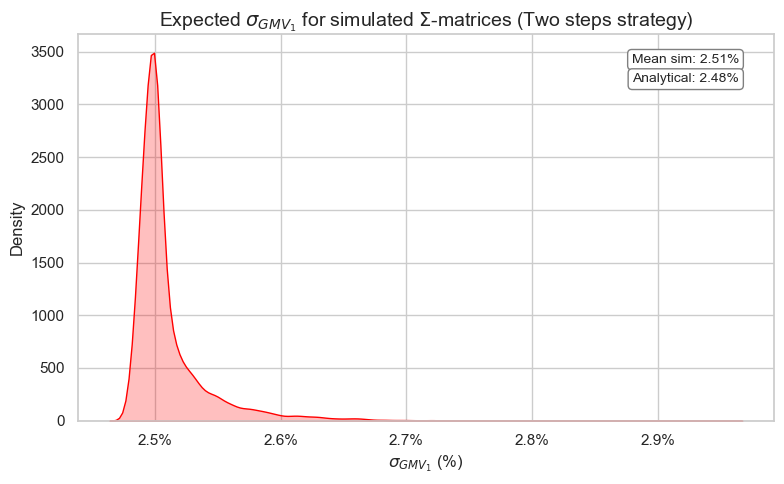

In [154]:
# Plot for sigma_port_pnl_sim
mean_value_twosteps = np.mean(sigma_optimal_ports_twosteps_sim)
true_port_sigma2_twostep = true_port_twostep @ true_cov_matrix_exp @ true_port_twostep
true_port_sigma_twostep = np.sqrt(true_port_sigma2_indv)

fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(sigma_optimal_ports_twosteps_sim, shade=True, color="red", ax=ax)

ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Two steps strategy)", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white")

ax.text(0.95, 0.95, f"Mean sim: {mean_value_twosteps:.2%}", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)

ax.text(0.95, 0.90, f"Analytical: {true_port_sigma_twostep:.2%}",
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)

plt.tight_layout()
plt.grid(True)
plt.savefig("sigma_optimal_ports_two_steps.png")
plt.show()


## Stratagy 3: Minimum variance Full scale 

In [155]:
#Initial tests
full_scale0 = calculate_min_variance_fullscale(sim_cov_matrix4_hat[0], prices_optim)
full_scale1 = calculate_min_variance_fullscale(sim_cov_matrix4_hat[1], prices_optim)
print(full_scale0)
print(full_scale1)
true_port = calculate_min_variance_fullscale(true_cov_matrix_exp, prices_optim)
print(true_port)
#Nor we just need to set it up as a loop

C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


[-2.22630437e-02  2.59242392e-04  5.50249576e-05  3.69702592e-03
  1.10189308e+00]
[1.70617836e-04 5.87484304e-04 9.68167691e-04 5.89223380e-03
 1.09863591e+00]
[1.43012244e-01 2.10655033e-04 1.39621525e-02 2.02048837e-01
 9.14493333e-01]


In [156]:
optimal_ports = []

# Calculate the global minimum portfolio for each covariance for the first strategy
#Takes a long time to run, so be careful what you wish for
for i in range(num_simulations_cov):
    optimal_port = calculate_min_variance_fullscale(sim_cov_matrix4_hat[i], prices_optim)
    
    optimal_ports.append(optimal_port)

In [157]:
negative_weights = []

for idx, weights in enumerate(optimal_ports):
    negative_values = weights[1:4] < 0
  
    if any(negative_values):
        negative_weights.append((idx, weights[1:4], negative_values))

if negative_weights:
    for item in negative_weights:
        print(f"Array index {item[0]} has negative weights: {item[1]} (negative: {item[2]})")
else:
    print("No negative values found in weights 1-4")

No negative values found in weights 1-4


In [158]:
#Calculating the risk ny using the true covariance-matrix: true_cov_matrix_exp
sigma2_optimal_ports_sim = np.apply_along_axis(lambda x: x @ true_cov_matrix_exp @ x, 1, optimal_ports)
sigma_optimal_ports_sim = np.sqrt(sigma2_optimal_ports_sim)
sigma_optimal_ports_sim

array([0.02504199, 0.02503049, 0.02484998, ..., 0.02586405, 0.02550507,
       0.02870315])

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\532778395.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\532778395.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Full scale strategy)", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\532778395.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_optimal_ports_sim, shade=True, color="purple", ax=ax)


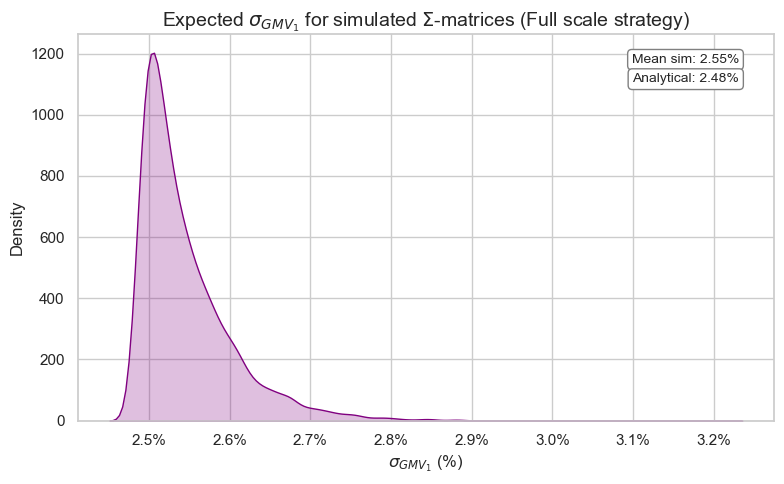

In [159]:
# Plot for sigma_port_pnl_sim
mean_value = np.mean(sigma_optimal_ports_sim)
true_port_sigma2 = true_port @ true_cov_matrix_exp @ true_port
true_port_sigma = np.sqrt(true_port_sigma2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(sigma_optimal_ports_sim, shade=True, color="purple", ax=ax)

ax.set_xlabel("$\sigma_{GMV_1}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\sigma_{GMV_1}$ for simulated $\Sigma$-matrices (Full scale strategy)", fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white")

ax.text(0.95, 0.95, f"Mean sim: {mean_value:.2%}", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)

ax.text(0.95, 0.90, f"Analytical: {true_port_sigma:.2%}",
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right',
        bbox=bbox_props)


plt.tight_layout()
plt.grid(True)
plt.savefig("sigma_optimal_ports_full_scale.png")
plt.show()


In [160]:
#Average weights for each strategy: 
weights1 = np.mean(optimal_ports_individuals, axis = 0)
weights2 = np.mean(optimal_ports_twosteps, axis = 0)
weights3 = np.mean(optimal_ports, axis = 0)
print("Individuals: ", weights1)
print("Two-step: ", weights2)
print("Full-scale: ", weights3)
min1 = np.min(sigma_optimal_ports_individuals_sim)
min2 = np.min(sigma_optimal_ports_twosteps_sim)
min3 = np.min(sigma_optimal_ports_sim)
max1 = np.max(sigma_optimal_ports_individuals_sim)
max2 = np.max(sigma_optimal_ports_twosteps_sim)
max3 = np.max(sigma_optimal_ports_sim)

print("Individuals min sigma: ", min1)
print("Two-step min sigma: ", min2)
print("Full-scale min sigma: ", min3)
print("Individuals max sigma: ", max1)
print("Two-step max sigma: ", max2)
print("Full-scale max sigma: ", max3)

Individuals:  [0.17939581 0.00597256 0.01514356 0.24405551 0.87071832]
Two-step:  [0.02772534 0.00390083 0.01320732 0.04688687 1.04607642]
Full-scale:  [0.1810299  0.00621775 0.01530049 0.24592444 0.86866703]
Individuals min sigma:  0.024793802160658972
Two-step min sigma:  0.024793561896961157
Full-scale min sigma:  0.024793669344942003
Individuals max sigma:  0.0320722483325183
Two-step max sigma:  0.029514671048920818
Full-scale max sigma:  0.03207238044888232


In [161]:
#Calculating the risk ny using the true covariance-matrix: true_cov_matrix_exp
#num_simulations_cov equal to 10.000
sigma2_optimal_ports_individuals_sim = np.apply_along_axis(lambda x: x @ sim_cov_matrix4_hat @ x, 1, optimal_ports_individuals)
sigma_optimal_ports_individuals_sim = np.sqrt(sigma2_optimal_ports_individuals_sim)
sigma_optimal_ports_individuals_sim

array([[0.02429516, 0.01977552, 0.02460781, ..., 0.03231703, 0.02393251,
        0.02439212],
       [0.02435301, 0.01970454, 0.02458953, ..., 0.03240171, 0.02383248,
        0.02421492],
       [0.02477861, 0.02002345, 0.02448414, ..., 0.03224451, 0.02384819,
        0.02369664],
       ...,
       [0.02619365, 0.0215521 , 0.02535709, ..., 0.0318221 , 0.0241112 ,
        0.02186238],
       [0.02581245, 0.02067498, 0.024887  , ..., 0.03218007, 0.02329167,
        0.02224992],
       [0.02986534, 0.02481229, 0.0274519 , ..., 0.03236455, 0.02519056,
        0.02067705]])

In [162]:
#For each individual covariance-matrix, here two steps should be the worst
sigma_optimal_indv_results = []
sigma_optimal_twosteps_results = []
sigma_optimal_fullscale_results = []


for i in range(num_simulations_cov):
    current_cov_matrix = sim_cov_matrix4_hat[i]
    current_portfolios = optimal_ports_individuals[i]  #Individuals
    current_portfolios2 = optimal_ports_twosteps[i] #Two steps
    current_portfolios3 = optimal_ports[i] #Full scale
    
    # sigma^2
    sigma2_individuals_sim_new =  current_portfolios @ current_cov_matrix @ current_portfolios
    sigma2_twosteps_sim_new =  current_portfolios2 @ current_cov_matrix @ current_portfolios2
    sigma2_fullscale_sim_new =  current_portfolios3 @ current_cov_matrix @ current_portfolios3
    
    # sigma
    sigma_individuals_sim_new = np.sqrt(sigma2_individuals_sim_new)
    sigma_twosteps_sim_new = np.sqrt(sigma2_twosteps_sim_new)
    sigma_fullscale_sim_new = np.sqrt(sigma2_fullscale_sim_new)
    
    sigma_optimal_indv_results.append(sigma_individuals_sim_new)
    sigma_optimal_twosteps_results.append(sigma_twosteps_sim_new)
    sigma_optimal_fullscale_results.append(sigma_fullscale_sim_new)



sigma_optimal_indv_results = np.array(sigma_optimal_indv_results)
sigma_optimal_twosteps_results = np.array(sigma_optimal_twosteps_results)
sigma_optimal_fullscale_results = np.array(sigma_optimal_fullscale_results)


print("Average sigma indvidual:", np.mean(sigma_optimal_indv_results))
print("Average sigma two step:", np.mean(sigma_optimal_twosteps_results))
print("Average sigma full scale:", np.mean(sigma_optimal_fullscale_results))



Average sigma indvidual: 0.02373663662020113
Average sigma two step: 0.024375469271586025
Average sigma full scale: 0.023740507317487072


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\205989144.py:19: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel("$\sigma_{GMV}$ (%)", fontsize=12)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\205989144.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Expected $\sigma_{GMV}$ for Simulated Strategies", fontsize=14)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\205989144.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_optimal_indv_results, shade=True, label="Individual Strategy", ax=ax)
C:\Users\jonas\AppData\Local\Temp\ipykernel_6808\205989144.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setti

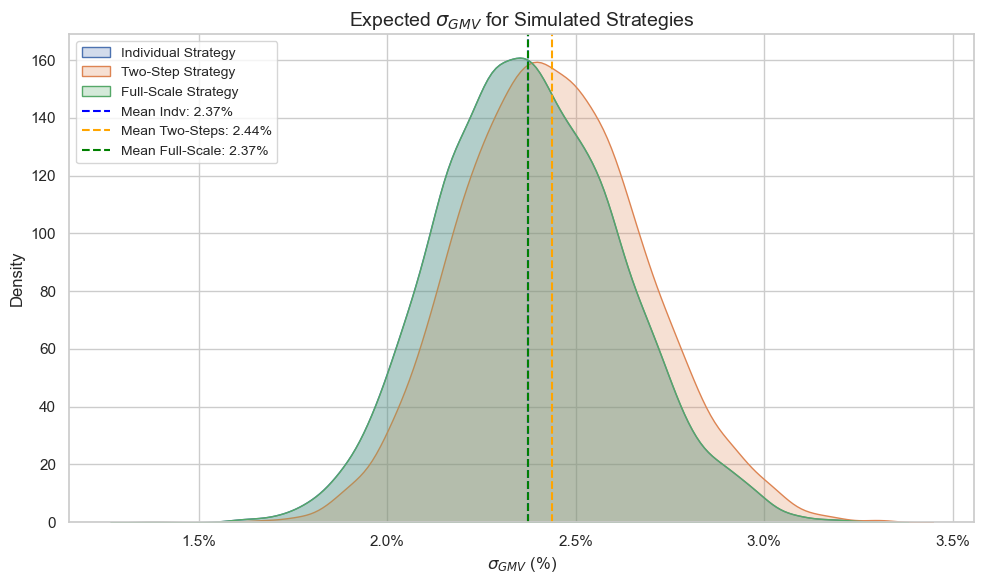

In [163]:

mean_indv = np.mean(sigma_optimal_indv_results)
mean_twosteps = np.mean(sigma_optimal_twosteps_results)
mean_fullscale = np.mean(sigma_optimal_fullscale_results)


fig, ax = plt.subplots(figsize=(10, 6))


sns.kdeplot(sigma_optimal_indv_results, shade=True, label="Individual Strategy", ax=ax)
sns.kdeplot(sigma_optimal_twosteps_results, shade=True, label="Two-Step Strategy", ax=ax)
sns.kdeplot(sigma_optimal_fullscale_results, shade=True, label="Full-Scale Strategy", ax=ax)


ax.axvline(mean_indv, color='blue', linestyle='--', label=f"Mean Indv: {mean_indv:.2%}")
ax.axvline(mean_twosteps, color='orange', linestyle='--', label=f"Mean Two-Steps: {mean_twosteps:.2%}")
ax.axvline(mean_fullscale, color='green', linestyle='--', label=f"Mean Full-Scale: {mean_fullscale:.2%}")


ax.set_xlabel("$\sigma_{GMV}$ (%)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Expected $\sigma_{GMV}$ for Simulated Strategies", fontsize=14)


ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))


ax.legend(loc='upper left', fontsize=10)


plt.grid(True)
plt.tight_layout()
plt.savefig("three_strategies_compared_final_plot_XD.png")
plt.show()
